# Data forecasting using time series 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy.stats as st
import math
from scipy.stats import boxcox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from pylab import rcParams
from pandas.plotting import autocorrelation_plot
import random 
rcParams['figure.figsize'] = 20, 10

### Dane wyjściowe - ładowanie i analiza danych 

In [2]:
data_load = pd.read_csv("wse_pko_pgn_pkn.csv", iterator=True, chunksize = 1000, parse_dates=["date"])#, index_col=0, parse_dates=True, dayfirst=True)#, parse_dates=["date"])
data_df = pd.concat(data_load, ignore_index=True)

In [3]:
data_df.columns

Index(['Unnamed: 0', 'date', 'symbol', 'daily_volume', 'daily_turnover',
       'daily_count', 'bob_volume', 'bob_turnover', 'bob_count', 'dark_volume',
       'dark_turnover', 'dark_count', 'dark_lis_volume', 'dark_lis_turnover',
       'dark_lis_count', 'dark_average_trade_size',
       'daily_continuous_turnover', 'daily_continuous_volume',
       'daily_continuous_count', 'average_trade_size',
       'auction_opening_volume', 'auction_opening_turnover',
       'auction_opening_count', 'auction_closing_volume',
       'auction_closing_turnover', 'auction_closing_count',
       'auction_periodic_volume', 'auction_periodic_turnover',
       'auction_periodic_count', 'auction_other_volume',
       'auction_other_turnover', 'auction_other_count', 'auction_edsp_volume',
       'auction_edsp_turnover', 'auction_edsp_count',
       'auction_volatility_volume', 'auction_volatility_turnover',
       'auction_volatility_count', 'auction_intraday_volume',
       'auction_intraday_turnover', 'a

In [4]:
data_df["date"] = pd.to_datetime(data_df["date"])
print(type(data_df["date"]))

<class 'pandas.core.series.Series'>


In [5]:
data = data_df[["date", "symbol", "daily_turnover"]]
print(data.head())

        date   symbol  daily_turnover
0 2018-01-03  PGE.WSE     22422908.06
1 2018-01-03  PKN.WSE     95552754.95
2 2018-01-03  PKO.WSE     86041634.68
3 2018-01-04  PGE.WSE     38983275.28
4 2018-01-04  PKN.WSE     98511451.45


In [6]:
data['symbol'] = data['symbol'].replace(r'.WSE', '', regex=True)

C:\Users\kubam\AppData\Local\Temp\ipykernel_3784\2734303368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['symbol'] = data['symbol'].replace(r'.WSE', '', regex=True)


In [7]:
data[data["symbol"].isin(['PKO', 'PKN', 'PGE'])].groupby(['symbol']).sum(['daily_turnover']).reset_index()

symbol  daily_turnover
0    PGE    2.939832e+10
1    PKN    1.307811e+11
2    PKO    1.261601e+11

In [8]:
selected_data = data[data["symbol"].isin(['PKO', 'PKN', 'PGE'])]
print(selected_data["date"][selected_data["symbol"] == "PGE"])

0      2018-01-03
3      2018-01-04
6      2018-01-05
9      2018-01-08
12     2018-01-09
          ...    
4341   2023-10-16
4344   2023-10-17
4347   2023-10-18
4350   2023-10-19
4353   2023-10-20
Name: date, Length: 1452, dtype: datetime64[ns]


### Analiza danych rzeczywistych - dane dzienne (5 dni w tygodniu)

In [9]:
# PGE
PGE = pd.DataFrame()
PGE["daily_turnover"] = data["daily_turnover"][data["symbol"] == "PGE"]
PGE = PGE.set_index(data["date"][data["symbol"] == "PGE"])
#PGE = PGE.set_index("date")
# PGE = data[data["symbol"] == "PGE"]
print(PGE)

            daily_turnover
date                      
2018-01-03    2.242291e+07
2018-01-04    3.898328e+07
2018-01-05    3.325880e+07
2018-01-08    2.242056e+07
2018-01-09    3.756841e+07
...                    ...
2023-10-16    3.718460e+07
2023-10-17    4.243298e+07
2023-10-18    2.500334e+07
2023-10-19    2.590816e+07
2023-10-20    1.119398e+07

[1452 rows x 1 columns]


In [10]:
# PKN
PKN = pd.DataFrame()
PKN["daily_turnover"] = data["daily_turnover"][data["symbol"] == "PKN"]
PKN = PKN.set_index(data["date"][data["symbol"] == "PKN"])
#PKN = data[data["symbol"] == "PKN"][["symbol", "daily_turnover"]]
# PKN = data[data["symbol"] == "PKN"]
PKN

daily_turnover
date                      
2018-01-03    9.555275e+07
2018-01-04    9.851145e+07
2018-01-05    9.786237e+07
2018-01-08    5.833312e+07
2018-01-09    7.971592e+07
...                    ...
2023-10-16    7.530384e+08
2023-10-17    3.223994e+08
2023-10-18    3.056536e+08
2023-10-19    1.735664e+08
2023-10-20    1.230241e+08

[1452 rows x 1 columns]

In [11]:
# PKO
PKO = pd.DataFrame()
PKO["daily_turnover"] = data["daily_turnover"][data["symbol"] == "PKO"]
PKO = PKO.set_index(data["date"][data["symbol"] == "PKO"])
# PKO = data[data["symbol"] == "PKO"]
PKO


daily_turnover
date                      
2018-01-03    8.604163e+07
2018-01-04    1.277076e+08
2018-01-05    9.375346e+07
2018-01-08    9.072367e+07
2018-01-09    1.036853e+08
...                    ...
2023-10-16    5.211608e+08
2023-10-17    2.342910e+08
2023-10-18    1.922527e+08
2023-10-19    9.575135e+07
2023-10-20    8.067337e+07

[1452 rows x 1 columns]

In [12]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

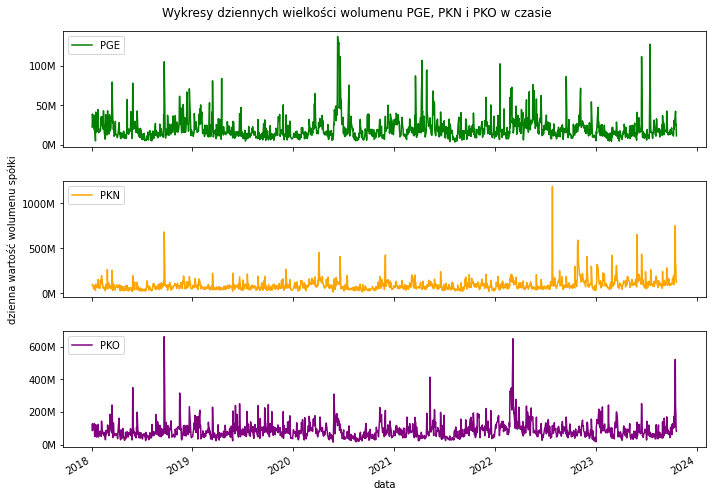

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(10,7))
ax1.plot(PGE["daily_turnover"], color="green", label="PGE")
ax2.plot(PKN["daily_turnover"], color="orange", label="PKN")
ax3.plot(PKO["daily_turnover"], color="purple", label="PKO")
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Wykresy dziennych wielkości wolumenu PGE, PKN i PKO w czasie")
plt.gcf().autofmt_xdate()
plt.savefig("1kopia.png")

### Dane brakujące

In [14]:
PGE_nan_values = [i for i in PGE["daily_turnover"] if math.isnan(i)] # sa wszystkie
PKN_nan_values = [i for i in PKN["daily_turnover"] if math.isnan(i)] # sa wszystkie
PKO_nan_values = [i for i in PKO["daily_turnover"] if math.isnan(i)] # sa wszystkie

In [15]:
PGE["daily_turnover"].isnull().count() # nie ma nulli 
PKN["daily_turnover"].isnull().count() # nie ma nulli 
PKO["daily_turnover"].isnull().count() # nie ma nulli 

1452

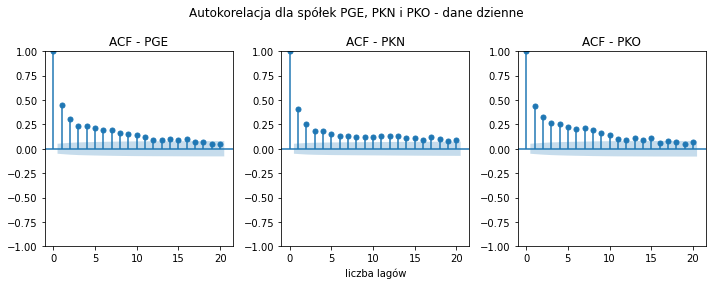

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
plot_acf(PGE["daily_turnover"], lags=20, ax=ax1)
plot_acf(PKN["daily_turnover"], lags=20, ax=ax2)
plot_acf(PKO["daily_turnover"], lags=20, ax=ax3)
ax1.set_title("ACF - PGE")
ax2.set_title("ACF - PKN")
ax3.set_title("ACF - PKO")
ax2.set_xlabel("liczba lagów")
fig.suptitle("Autokorelacja dla spółek PGE, PKN i PKO - dane dzienne")
plt.savefig("3.pdf")

### Sprawdzenie stacjonarności danych

In [17]:
PGE_test = adfuller(PGE["daily_turnover"])
PKN_test = adfuller(PKN["daily_turnover"])
PKO_test = adfuller(PKO["daily_turnover"])

PGE_test1 = kpss(PGE["daily_turnover"])
PKN_test1 = kpss(PKN["daily_turnover"])
PKO_test1 = kpss(PKO["daily_turnover"])

print("PGE: p-value z testu Augmented Dickey-Fuller'a", PGE_test[1]) # stacjonarne
print("PKN: p-value z testu Augmented Dickey-Fuller'a", PKN_test[1]) # stacjonarne
print("PKO: p-value z testu Augmented Dickey-Fuller'a", PKO_test[1]) # stacjonarne

print("PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PGE_test1[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKN_test1[1]) # nie stacjonarne
print("PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKO_test1[1]) # stacjonarne

PGE: p-value z testu Augmented Dickey-Fuller'a 1.3818290194854369e-15
PKN: p-value z testu Augmented Dickey-Fuller'a 3.766916559054291e-08
PKO: p-value z testu Augmented Dickey-Fuller'a 3.285202714323095e-14
PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.01
PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Dekompozycja danych (model addytywny)

In [18]:
def decomp_add(df, title):
    result = sm.tsa.seasonal_decompose(df, model='additive', period=int(len(df)/8)) #period=int(len(df)/4) <- było wcześniej
    results_df = pd.DataFrame({'trend': result.trend, 'seasonal': result.seasonal, 'resid': result.resid, 'observed': result.observed})
    
    # plot the graphs
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(20, 10))

    ax[0].plot(results_df['trend'], color='b')
    ax[0].set_title(title)
    ax[0].set_xlabel('Trend')
    ax[0].set_ylabel('Wartości')
    ax[0].yaxis.set_major_formatter(formatter)

    ax[1].plot(results_df['seasonal'], color='b')
    ax[1].set_xlabel('Sezonowość')
    ax[1].set_ylabel('Wartości')
    ax[1].yaxis.set_major_formatter(formatter)

    ax[2].plot(results_df['resid'], color='b', linestyle='dotted', linewidth = 3)
    ax[2].axhline(linewidth=2, color='r')
    ax[2].set_xlabel('Residua')
    ax[2].set_ylabel('Wartości')
    ax[2].yaxis.set_major_formatter(formatter)

    ax[3].plot(results_df['observed'], color='b')
    ax[3].set_xlabel('Dane rzeczywiste')
    ax[3].set_ylabel('Wartości')
    ax[3].yaxis.set_major_formatter(formatter)
    
    #plt.savefig(f'{title}.png')

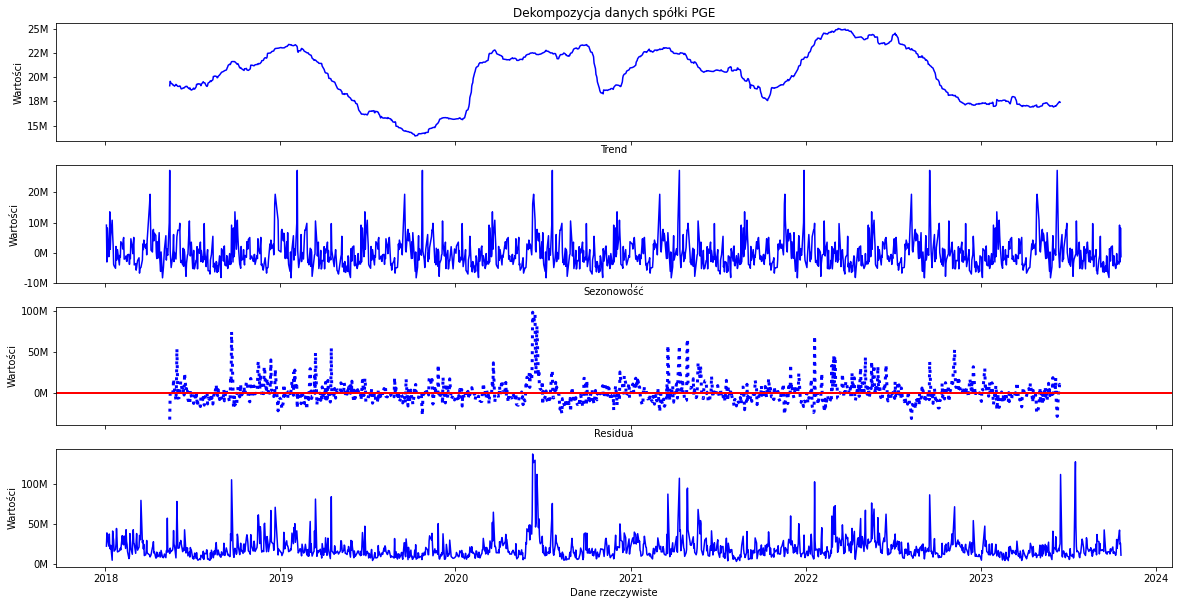

In [19]:
decomp_add(PGE["daily_turnover"],"Dekompozycja danych spółki PGE")

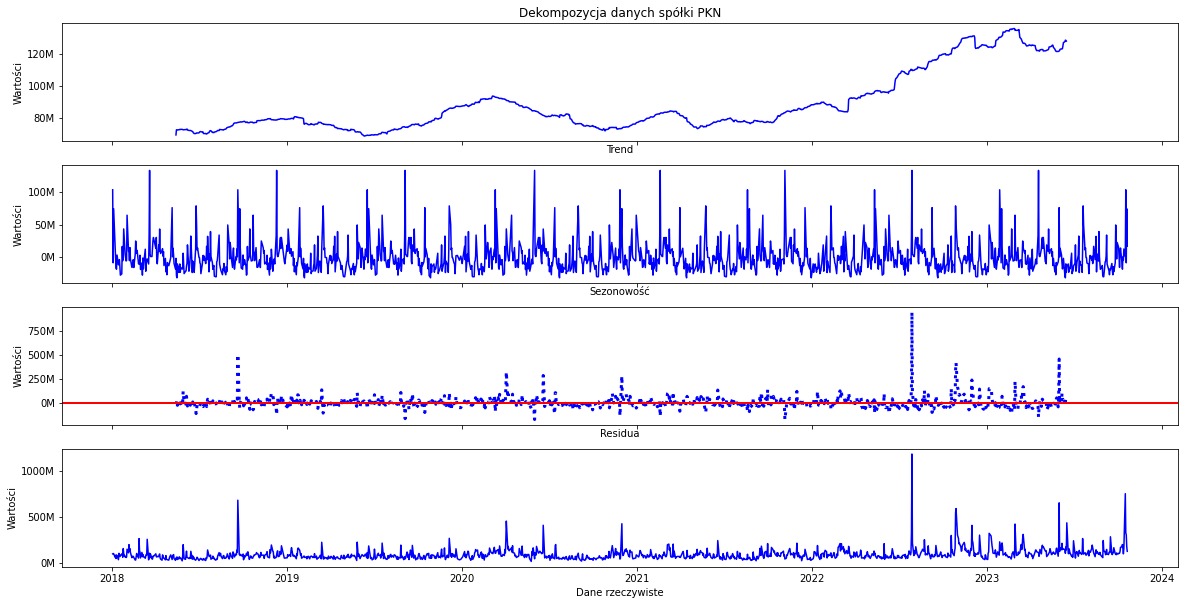

In [20]:
decomp_add(PKN["daily_turnover"],"Dekompozycja danych spółki PKN")

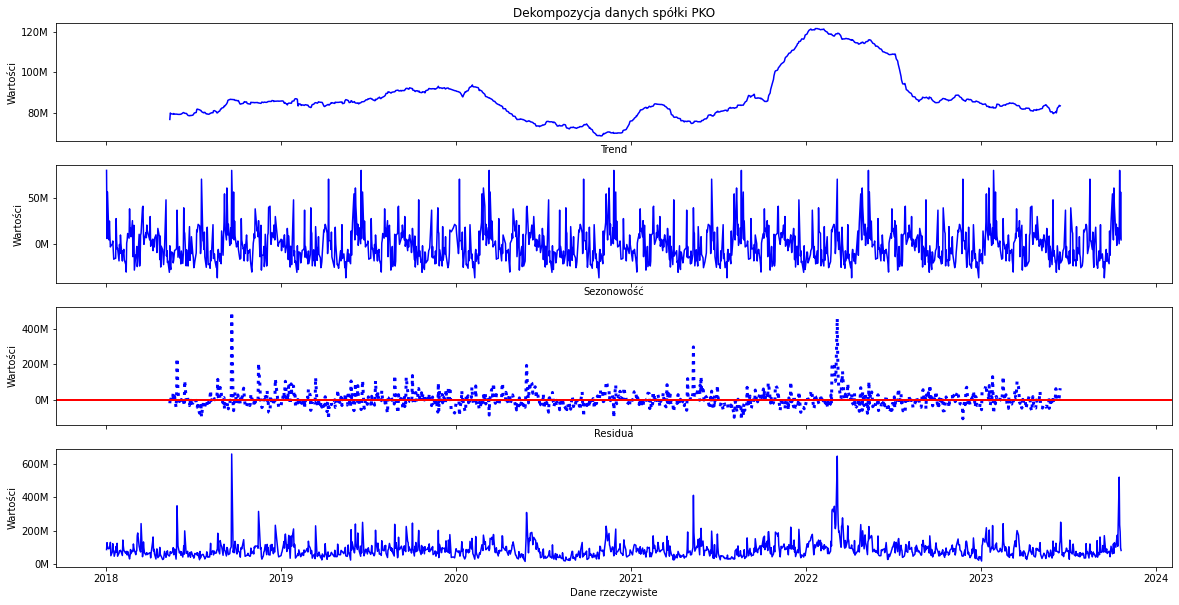

In [21]:
decomp_add(PKO["daily_turnover"],"Dekompozycja danych spółki PKO")

### Różnicowanie danych i powrót do oryginalnych - dane dzienne 

In [22]:
# cumulative_sum = np.cumsum(np.diff(PKN["daily_turnover"])) + 100000000 #10^6
# reverse_diff = np.insert(cumulative_sum, 0, PKN["daily_turnover"].iloc[0])
# PKN['reverse_diff_daily'] = reverse_diff

In [23]:
diff_daily = np.diff(PKN["daily_turnover"])
diff_daily_0 = np.insert(diff_daily, 0, PKN["daily_turnover"].iloc[0])
PKN['diff_daily'] = diff_daily_0

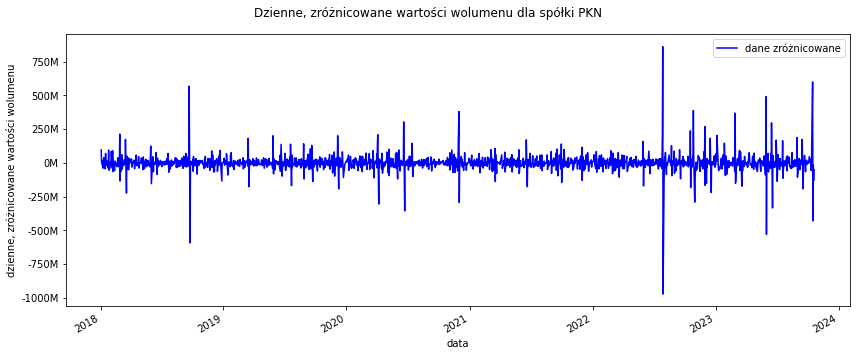

In [24]:
fig, (ax2) = plt.subplots(1,1, tight_layout=True, figsize=(12,5))
ax2.plot(PKN['diff_daily'], color="blue", label="dane zróżnicowane")
ax2.set_ylabel("dzienne, zróżnicowane wartości wolumenu")
ax2.set_xlabel("data")
fig.suptitle("Dzienne, zróżnicowane wartości wolumenu dla spółki PKN")
plt.gcf().autofmt_xdate()
ax2.yaxis.set_major_formatter(formatter)
ax2.legend()
plt.savefig('10.pdf')

In [25]:
returns_PKN_test_diff = adfuller(PKN["diff_daily"])
returns_PKN_test1_diff = kpss(PKN["diff_daily"])

print("PKN: p-value z testu Augmented Dickey-Fuller'a", returns_PKN_test_diff[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", returns_PKN_test1_diff[1]) # stacjonarne

PKN: p-value z testu Augmented Dickey-Fuller'a 6.073838224597942e-24
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Dane testowe i treningowe - dane dzienne 

In [26]:
df_train_PGE = PGE["daily_turnover"][:1307]
df_test_PGE = PGE["daily_turnover"][1307:]

df_train_PKN = PKN["diff_daily"][:1307]
df_test_PKN = PKN["diff_daily"][1307:]

df_train_PKO = PKO["daily_turnover"][:1307]
df_test_PKO = PKO["daily_turnover"][1307:]

### Znajdownanie rzędu modelu (p, q) za pomocą kryteriów informacyjnych (Najlepszy będzie model z p=2 i q=1 jak widać)

In [27]:
data_PGE_ARMA = df_train_PGE
data_PKN_ARMA = df_train_PKN
data_PKO_ARMA = df_train_PKO

df_PGE_ARMA = pd.DataFrame()
df_PKN_ARMA = pd.DataFrame()
df_PKO_ARMA = pd.DataFrame()

ps_PGE_ARMA = []
ps_PKN_ARMA = []
ps_PKO_ARMA = []
qs_PGE_ARMA = []
qs_PKN_ARMA = []
qs_PKO_ARMA = []
BIC_PGE_ARMA = []
BIC_PKN_ARMA = []
BIC_PKO_ARMA = []
AIC_PGE_ARMA = []
AIC_PKN_ARMA = []
AIC_PKO_ARMA = []
HQIC_PGE_ARMA = []
HQIC_PKN_ARMA = []
HQIC_PKO_ARMA = []

max_p = 4
max_q = 4

for p in range(1, max_p):
    for q in range(1, max_q):
        model_PGE = ARIMA(data_PGE_ARMA, order=(p, 0, q))
        model_PKN = ARIMA(data_PKN_ARMA, order=(p, 0, q))
        model_PKO = ARIMA(data_PKO_ARMA, order=(p, 0, q))
        model_fit_PGE = model_PGE.fit()
        model_fit_PKN = model_PKN.fit()
        model_fit_PKO = model_PKO.fit()
        ps_PGE_ARMA.append(p)
        qs_PGE_ARMA.append(q)
        ps_PKN_ARMA.append(p)
        qs_PKN_ARMA.append(q)
        ps_PKO_ARMA.append(p)
        qs_PKO_ARMA.append(q)
        AIC_PGE_ARMA.append(model_fit_PGE.aic)
        BIC_PGE_ARMA.append(model_fit_PGE.bic)
        HQIC_PGE_ARMA.append(model_fit_PGE.hqic)
        AIC_PKN_ARMA.append(model_fit_PKN.aic)
        BIC_PKN_ARMA.append(model_fit_PKN.bic)
        HQIC_PKN_ARMA.append(model_fit_PKN.hqic)
        AIC_PKO_ARMA.append(model_fit_PKO.aic)
        BIC_PKO_ARMA.append(model_fit_PKO.bic)
        HQIC_PKO_ARMA.append(model_fit_PKO.hqic)

df_PGE_ARMA['p']    = ps_PGE_ARMA
df_PGE_ARMA['q']    = qs_PGE_ARMA
df_PGE_ARMA['AIC']  = AIC_PGE_ARMA
df_PGE_ARMA['BIC']  = BIC_PGE_ARMA
df_PGE_ARMA['HQIC'] = HQIC_PGE_ARMA

df_PKN_ARMA['p']    = ps_PKN_ARMA
df_PKN_ARMA['q']    = qs_PKN_ARMA
df_PKN_ARMA['AIC']  = AIC_PKN_ARMA
df_PKN_ARMA['BIC']  = BIC_PKN_ARMA
df_PKN_ARMA['HQIC'] = HQIC_PKN_ARMA

df_PKO_ARMA['p']    = ps_PKO_ARMA
df_PKO_ARMA['q']    = qs_PKO_ARMA
df_PKO_ARMA['AIC']  = AIC_PKO_ARMA
df_PKO_ARMA['BIC']  = BIC_PKO_ARMA
df_PKO_ARMA['HQIC'] = HQIC_PKO_ARMA

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

### Dopasownie parametrów szeregu dla danych PGE

In [28]:
df_PGE_ARMA.sort_values(by='AIC').head()

p  q           AIC           BIC          HQIC
3  2  1  46413.000530  46438.877979  46422.707240
2  1  3  46413.589142  46444.642080  46425.237194
4  2  2  46414.684840  46445.737779  46426.332893
6  3  1  46414.852408  46445.905346  46426.500460
1  1  2  46415.510140  46441.387589  46425.216850

In [29]:
df_PGE_ARMA.sort_values(by='BIC').head()

p  q           AIC           BIC          HQIC
3  2  1  46413.000530  46438.877979  46422.707240
1  1  2  46415.510140  46441.387589  46425.216850
2  1  3  46413.589142  46444.642080  46425.237194
4  2  2  46414.684840  46445.737779  46426.332893
6  3  1  46414.852408  46445.905346  46426.500460

In [30]:
df_PGE_ARMA.sort_values(by='HQIC').head()

p  q           AIC           BIC          HQIC
3  2  1  46413.000530  46438.877979  46422.707240
1  1  2  46415.510140  46441.387589  46425.216850
2  1  3  46413.589142  46444.642080  46425.237194
4  2  2  46414.684840  46445.737779  46426.332893
6  3  1  46414.852408  46445.905346  46426.500460

### Dopasownie parametrów szeregu dla danych PKN

In [31]:
df_PKN_ARMA.sort_values(by='AIC').head()

p  q           AIC           BIC          HQIC
4  2  2  50378.999601  50410.052540  50390.647654
2  1  3  50381.775340  50412.828278  50393.423392
8  3  3  50381.967046  50423.370964  50397.497782
1  1  2  50384.182929  50410.060377  50393.889639
5  2  3  50384.362008  50420.590436  50397.951402

In [32]:
df_PKN_ARMA.sort_values(by='BIC').head()

p  q           AIC           BIC          HQIC
4  2  2  50378.999601  50410.052540  50390.647654
1  1  2  50384.182929  50410.060377  50393.889639
0  1  1  50391.113583  50411.815542  50398.878951
2  1  3  50381.775340  50412.828278  50393.423392
3  2  1  50389.741603  50415.619052  50399.448313

In [33]:
df_PKN_ARMA.sort_values(by='HQIC').head()

p  q           AIC           BIC          HQIC
4  2  2  50378.999601  50410.052540  50390.647654
2  1  3  50381.775340  50412.828278  50393.423392
1  1  2  50384.182929  50410.060377  50393.889639
8  3  3  50381.967046  50423.370964  50397.497782
5  2  3  50384.362008  50420.590436  50397.951402

### Dopasownie parametrów szeregu dla danych PKO

In [34]:
df_PKO_ARMA.sort_values(by='AIC').head()

p  q           AIC           BIC          HQIC
3  2  1  49791.839934  49817.717383  49801.546644
1  1  2  49792.059284  49817.936733  49801.765994
2  1  3  49793.346410  49824.399348  49804.994462
4  2  2  49793.541899  49824.594837  49805.189951
6  3  1  49793.802346  49824.855284  49805.450398

In [35]:
df_PKO_ARMA.sort_values(by='BIC').head()

p  q           AIC           BIC          HQIC
3  2  1  49791.839934  49817.717383  49801.546644
1  1  2  49792.059284  49817.936733  49801.765994
2  1  3  49793.346410  49824.399348  49804.994462
4  2  2  49793.541899  49824.594837  49805.189951
6  3  1  49793.802346  49824.855284  49805.450398

In [36]:
df_PKO_ARMA.sort_values(by='HQIC').head()

p  q           AIC           BIC          HQIC
3  2  1  49791.839934  49817.717383  49801.546644
1  1  2  49792.059284  49817.936733  49801.765994
2  1  3  49793.346410  49824.399348  49804.994462
4  2  2  49793.541899  49824.594837  49805.189951
6  3  1  49793.802346  49824.855284  49805.450398

### Dobieramy model ARMA według powyższych kryteriów

In [37]:
p1, q1 = 2, 1
p2, q2 = 2, 2


model_PGE_ARMA = ARIMA(data_PGE_ARMA, order=(p1,0,q1))
model_PKN_ARMA = ARIMA(data_PKN_ARMA, order=(p2,0,q2))
model_PKO_ARMA = ARIMA(data_PKO_ARMA, order=(p1,0,q1))
result_PGE_ARMA = model_PGE_ARMA.fit()
result_PKN_ARMA = model_PKN_ARMA.fit()
result_PKO_ARMA = model_PKO_ARMA.fit()
print(result_PGE_ARMA.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         daily_turnover   No. Observations:                 1307
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -23201.500
Date:                Sun, 04 Feb 2024   AIC                          46413.001
Time:                        11:31:13   BIC                          46438.878
Sample:                             0   HQIC                         46422.707
                               - 1307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.044e+07   5.05e-10   4.05e+16      0.000    2.04e+07    2.04e+07
ar.L1          1.1637      0.050     23.173      0.000       1.065       1.262
ar.L2         -0.2239      0.034     -6.509      0.0

In [38]:
predicted_result_PGE_ARMA = result_PGE_ARMA.predict(start=0, end=600)
predicted_result_PKN_ARMA = result_PKN_ARMA.predict(start=0, end=600)
predicted_result_PKO_ARMA = result_PKO_ARMA.predict(start=0, end=600)

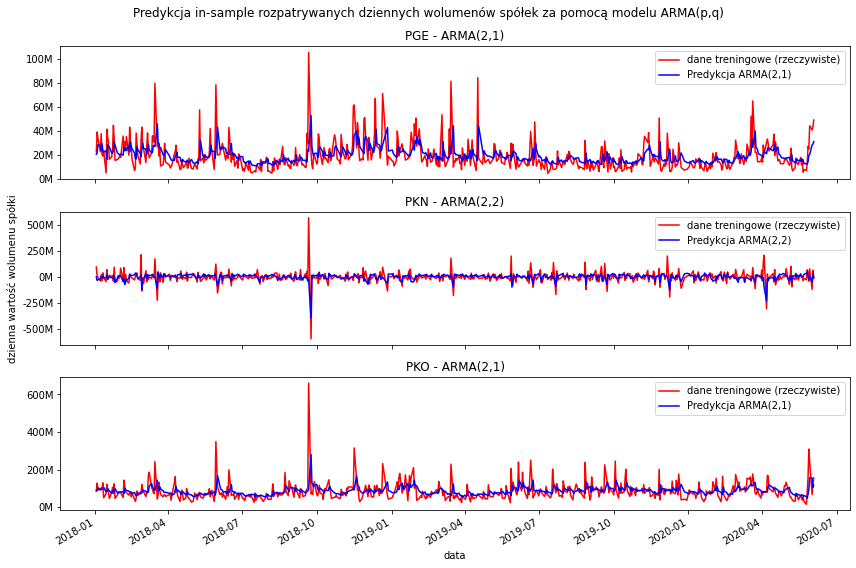

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARMA[:601], color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_ARMA, color='blue', label="Predykcja ARMA(2,1)")
ax2.plot(data_PKN_ARMA[:601], color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_ARMA, color='blue', label="Predykcja ARMA(2,2)")
ax3.plot(data_PKO_ARMA[:601], color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_ARMA, color='blue', label="Predykcja ARMA(2,1)")
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARMA(2,1)")
ax2.title.set_text("PKN - ARMA(2,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARMA(2,1)")
ax1.legend()
ax2.legend()
ax3.legend()
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja in-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARMA(p,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("13.pdf")

### Forecasting dla szeregu ARMA(p, q) - 1 rok do przodu 

In [40]:
forecast_test_PGE_ARMA = result_PGE_ARMA.get_forecast(len(df_test_PGE.index))
PGE_pred_df_ARMA = forecast_test_PGE_ARMA.conf_int(alpha = 0.05) 
PGE_pred_df_ARMA["Predictions"] = result_PGE_ARMA.predict(start = PGE_pred_df_ARMA.index[0], end = PGE_pred_df_ARMA.index[-1])
PGE_pred_df_ARMA.index = df_test_PGE.index
PGE_pred_out_ARMA = PGE_pred_df_ARMA["Predictions"] 

forecast_test_PKN_ARMA = result_PKN_ARMA.get_forecast(len(df_test_PKN.index))
PKN_pred_df_ARMA = forecast_test_PKN_ARMA.conf_int(alpha = 0.05) 
PKN_pred_df_ARMA["Predictions"] = result_PKN_ARMA.predict(start = PKN_pred_df_ARMA.index[0], end = PKN_pred_df_ARMA.index[-1])
PKN_pred_df_ARMA.index = df_test_PKN.index
PKN_pred_out_ARMA = PKN_pred_df_ARMA["Predictions"] 

forecast_test_PKO_ARMA = result_PKO_ARMA.get_forecast(len(df_test_PKO.index))
PKO_pred_df_ARMA = forecast_test_PKO_ARMA.conf_int(alpha = 0.05) 
PKO_pred_df_ARMA["Predictions"] = result_PKO_ARMA.predict(start = PKO_pred_df_ARMA.index[0], end = PKO_pred_df_ARMA.index[-1])
PKO_pred_df_ARMA.index = df_test_PKO.index
PKO_pred_out_ARMA = PKO_pred_df_ARMA["Predictions"] 

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program F

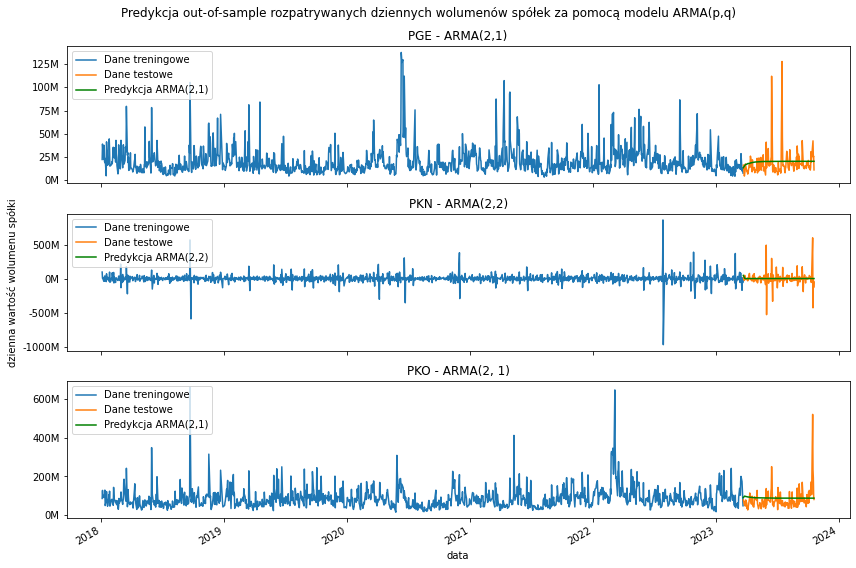

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARMA, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_ARMA, color='green', label = 'Predykcja ARMA(2,1)')
ax2.plot(data_PKN_ARMA, label="Dane treningowe")
ax2.plot(df_test_PKN, label="Dane testowe")
ax2.plot(PKN_pred_out_ARMA, color='green', label = 'Predykcja ARMA(2,2)')
ax3.plot(data_PKO_ARMA, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_ARMA, color='green', label = 'Predykcja ARMA(2,1)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARMA(2,1)")
ax2.title.set_text("PKN - ARMA(2,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARMA(2, 1)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARMA(p,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("14.pdf")

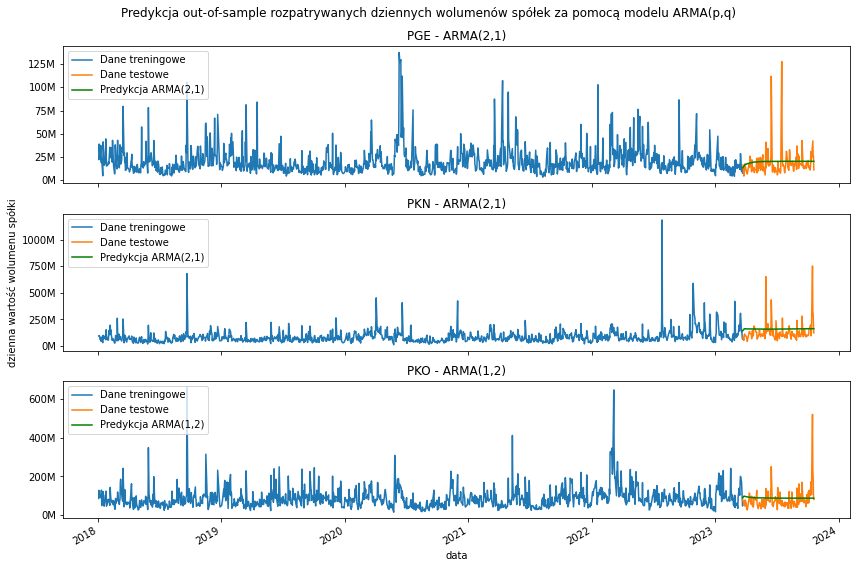

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARMA, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_ARMA, color='green', label = 'Predykcja ARMA(2,1)')
ax2.plot(PKN["daily_turnover"][:1307], label="Dane treningowe")
ax2.plot(PKN["daily_turnover"][1307:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_ARMA) + 100000000, color='green', label = 'Predykcja ARMA(2,1)')
ax3.plot(data_PKO_ARMA, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_ARMA, color='green', label = 'Predykcja ARMA(1,2)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARMA(2,1)")
ax2.title.set_text("PKN - ARMA(2,1)")
ax3.title.set_text("PKO - ARMA(1,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlabel("data")
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARMA(p,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("15.pdf")

### Podstawowe miary błędów dla powyższej ARMA

In [43]:
# PGE 
PGE_pred = PGE_pred_out_ARMA
PGE_true = df_test_PGE

mape_PGE_ARMA = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_ARMA = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_ARMA = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_ARMA = np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_ARMA = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [44]:
# PKN
PKN_pred = np.cumsum(PKN_pred_out_ARMA) + 100000000
PKN_true = PKN["daily_turnover"][1307:]

mape_PKN_ARMA = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_ARMA = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_ARMA = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_ARMA = np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_ARMA = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [45]:
# PKO
PKO_pred = PKO_pred_out_ARMA
PKO_true = df_test_PKO

mape_PKO_ARMA = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARMA = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARMA = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARMA = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARMA = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar dla ARMA

In [46]:
results_arma = pd.DataFrame({'Method':['ARMA - PGE', 'ARMA - PKN', 'ARMA - PKO'], 
                        'MAPE': [mape_PGE_ARMA, mape_PKN_ARMA, mape_PKO_ARMA],'MAE': [mae_PGE_ARMA,mae_PKN_ARMA, mae_PKO_ARMA], 'MPE': [mpe_PGE_ARMA, mpe_PKN_ARMA, mpe_PKO_ARMA], 'RMSE': [rmse_PGE_ARMA, rmse_PKN_ARMA, rmse_PGE_ARMA], 'CORR': [corr_PGE_ARMA,corr_PKN_ARMA,corr_PKO_ARMA]})
results_arma

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARMA - PGE  0.526955  8.092275e+06  0.381421  1.427743e+07  0.163508
1  ARMA - PKN  0.572662  6.201428e+07  0.492854  9.137914e+07  0.085998
2  ARMA - PKO  0.512299  3.436918e+07  0.365922  1.427743e+07 -0.137398

### Model ARIMA (wbudowany) 

In [47]:
data_PGE_ARIMA = df_train_PGE
data_PKN_ARIMA = df_train_PKN
data_PKO_ARIMA = df_train_PKO

df_PGE_ARIMA = pd.DataFrame()
df_PKN_ARIMA = pd.DataFrame()
df_PKO_ARIMA = pd.DataFrame()

ps_PGE_ARIMA = []
ps_PKN_ARIMA = []
ps_PKO_ARIMA = []
ds_PGE_ARIMA = []
ds_PKN_ARIMA = []
ds_PKO_ARIMA = []
qs_PGE_ARIMA = []
qs_PKN_ARIMA = []
qs_PKO_ARIMA = []
BIC_PGE_ARIMA = []
BIC_PKN_ARIMA = []
BIC_PKO_ARIMA = []
AIC_PGE_ARIMA = []
AIC_PKN_ARIMA = []
AIC_PKO_ARIMA = []
HQIC_PGE_ARIMA = []
HQIC_PKN_ARIMA = []
HQIC_PKO_ARIMA = []

max_p = 3
max_d = 3 
max_q = 3

for p in range(1, max_p):
    for d in range(1, max_d):
        for q in range(1, max_q):
            model_PGE_ = ARIMA(data_PGE_ARIMA, order=(p, d, q))
            model_PKN = ARIMA(data_PKN_ARIMA, order=(p, d, q))
            model_PKO = ARIMA(data_PKO_ARIMA, order=(p, d, q))
            model_fit_PGE = model_PGE.fit()
            model_fit_PKN = model_PKN.fit()
            model_fit_PKO = model_PKO.fit()
            ps_PGE_ARIMA.append(p)
            ds_PGE_ARIMA.append(d)
            qs_PGE_ARIMA.append(q)
            ps_PKN_ARIMA.append(p)
            ds_PKN_ARIMA.append(d)
            qs_PKN_ARIMA.append(q)
            ps_PKO_ARIMA.append(p)
            ds_PKO_ARIMA.append(d)
            qs_PKO_ARIMA.append(q)
            AIC_PGE_ARIMA.append(model_fit_PGE.aic)
            BIC_PGE_ARIMA.append(model_fit_PGE.bic)
            HQIC_PGE_ARIMA.append(model_fit_PGE.hqic)
            AIC_PKN_ARIMA.append(model_fit_PKN.aic)
            BIC_PKN_ARIMA.append(model_fit_PKN.bic)
            HQIC_PKN_ARIMA.append(model_fit_PKN.hqic)
            AIC_PKO_ARIMA.append(model_fit_PKO.aic)
            BIC_PKO_ARIMA.append(model_fit_PKO.bic)
            HQIC_PKO_ARIMA.append(model_fit_PKO.hqic)

df_PGE_ARIMA['p']    = ps_PGE_ARIMA
df_PGE_ARIMA['d']    = ds_PGE_ARIMA
df_PGE_ARIMA['q']    = qs_PGE_ARIMA
df_PGE_ARIMA['AIC']  = AIC_PGE_ARIMA
df_PGE_ARIMA['BIC']  = BIC_PGE_ARIMA
df_PGE_ARIMA['HQIC'] = HQIC_PGE_ARIMA

df_PKN_ARIMA['p']    = ps_PKN_ARIMA
df_PKN_ARIMA['d']    = ds_PKN_ARIMA
df_PKN_ARIMA['q']    = qs_PKN_ARIMA
df_PKN_ARIMA['AIC']  = AIC_PKN_ARIMA
df_PKN_ARIMA['BIC']  = BIC_PKN_ARIMA
df_PKN_ARIMA['HQIC'] = HQIC_PKN_ARIMA

df_PKO_ARIMA['p']    = ps_PKO_ARIMA
df_PKO_ARIMA['d']    = ds_PKO_ARIMA
df_PKO_ARIMA['q']    = qs_PKO_ARIMA
df_PKO_ARIMA['AIC']  = AIC_PKO_ARIMA
df_PKO_ARIMA['BIC']  = BIC_PKO_ARIMA
df_PKO_ARIMA['HQIC'] = HQIC_PKO_ARIMA

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

In [48]:
df_PGE_ARIMA.sort_values(by='AIC').head()

p  d  q          AIC           BIC          HQIC
0  1  1  1  46417.33381  46458.737728  46432.864547
1  1  1  2  46417.33381  46458.737728  46432.864547
2  1  2  1  46417.33381  46458.737728  46432.864547
3  1  2  2  46417.33381  46458.737728  46432.864547
4  2  1  1  46417.33381  46458.737728  46432.864547

In [49]:
df_PGE_ARIMA.sort_values(by='BIC').head()

p  d  q          AIC           BIC          HQIC
0  1  1  1  46417.33381  46458.737728  46432.864547
1  1  1  2  46417.33381  46458.737728  46432.864547
2  1  2  1  46417.33381  46458.737728  46432.864547
3  1  2  2  46417.33381  46458.737728  46432.864547
4  2  1  1  46417.33381  46458.737728  46432.864547

In [50]:
df_PGE_ARIMA.sort_values(by='HQIC').head()

p  d  q          AIC           BIC          HQIC
0  1  1  1  46417.33381  46458.737728  46432.864547
1  1  1  2  46417.33381  46458.737728  46432.864547
2  1  2  1  46417.33381  46458.737728  46432.864547
3  1  2  2  46417.33381  46458.737728  46432.864547
4  2  1  1  46417.33381  46458.737728  46432.864547

In [51]:
df_PKN_ARIMA.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
5  2  1  2     10.000000     35.873622     19.705643
1  1  1  2  50450.793857  50471.492754  50458.558371
4  2  1  1  50672.102332  50692.801229  50679.866847
0  1  1  1  50720.029657  50735.553830  50725.853043
7  2  2  2  50824.903020  50850.772812  50834.607596

In [52]:
df_PKN_ARIMA.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
5  2  1  2     10.000000     35.873622     19.705643
1  1  1  2  50450.793857  50471.492754  50458.558371
4  2  1  1  50672.102332  50692.801229  50679.866847
0  1  1  1  50720.029657  50735.553830  50725.853043
7  2  2  2  50824.903020  50850.772812  50834.607596

In [53]:
df_PKN_ARIMA.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
5  2  1  2     10.000000     35.873622     19.705643
1  1  1  2  50450.793857  50471.492754  50458.558371
4  2  1  1  50672.102332  50692.801229  50679.866847
0  1  1  1  50720.029657  50735.553830  50725.853043
7  2  2  2  50824.903020  50850.772812  50834.607596

In [54]:
df_PKO_ARIMA.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
5  2  1  2  49761.871181  49787.744803  49771.576825
1  1  1  2  49774.904626  49795.603524  49782.669141
4  2  1  1  49785.017751  49805.716649  49792.782266
0  1  1  1  49786.457277  49801.981450  49792.280663
7  2  2  2  49826.486709  49852.356500  49836.191285

In [55]:
df_PKO_ARIMA.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
5  2  1  2  49761.871181  49787.744803  49771.576825
1  1  1  2  49774.904626  49795.603524  49782.669141
0  1  1  1  49786.457277  49801.981450  49792.280663
4  2  1  1  49785.017751  49805.716649  49792.782266
7  2  2  2  49826.486709  49852.356500  49836.191285

In [56]:
df_PKO_ARIMA.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
5  2  1  2  49761.871181  49787.744803  49771.576825
1  1  1  2  49774.904626  49795.603524  49782.669141
0  1  1  1  49786.457277  49801.981450  49792.280663
4  2  1  1  49785.017751  49805.716649  49792.782266
7  2  2  2  49826.486709  49852.356500  49836.191285

### Dobieramy model ARIMA według powyższych kryteriów

In [57]:
p1, d1, q1 = 1,1,1
p2, d2, q2 = 1,1,2
p3, d3, q3 = 2,1,2

model_PGE_ARIMA = ARIMA(data_PGE_ARIMA, order=(p1,d1,q1))
model_PKN_ARIMA = ARIMA(data_PKN_ARIMA, order=(p2,d2,q2))
model_PKO_ARIMA = ARIMA(data_PKO_ARIMA, order=(p3,d3,q3))
result_PGE_ARIMA = model_PGE_ARIMA.fit()
result_PKN_ARIMA = model_PKN_ARIMA.fit()
result_PKO_ARIMA = model_PKO_ARIMA.fit()
print(result_PKO_ARIMA.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         daily_turnover   No. Observations:                 1307
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -24875.936
Date:                Sun, 04 Feb 2024   AIC                          49761.871
Time:                        11:31:41   BIC                          49787.745
Sample:                             0   HQIC                         49771.577
                               - 1307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1142      0.055     20.151      0.000       1.006       1.223
ar.L2         -0.1771      0.036     -4.948      0.000      -0.247      -0.107
ma.L1         -1.7742      0.052    -34.198      0.0

In [58]:
predicted_result_PGE_ARIMA = result_PGE_ARIMA.predict(start=0, end=600)
predicted_result_PKN_ARIMA = result_PKN_ARIMA.predict(start=0, end=600)
predicted_result_PKO_ARIMA = result_PKO_ARIMA.predict(start=0, end=600)

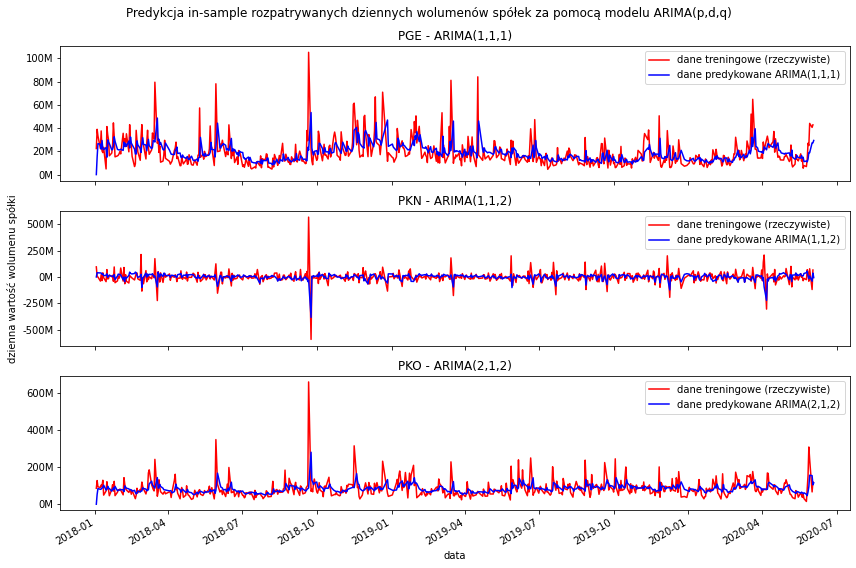

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA[0:600], color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_ARIMA, color='blue', label="dane predykowane ARIMA(1,1,1)")
ax2.plot(data_PKN_ARIMA[0:600], color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_ARIMA, color='blue', label="dane predykowane ARIMA(1,1,2)")
ax3.plot(data_PKO_ARIMA[0:600], color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_ARIMA, color='blue', label="dane predykowane ARIMA(2,1,2)")
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,1,1)")
ax2.title.set_text("PKN - ARIMA(1,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARIMA(2,1,2)")
ax1.legend()
ax2.legend()
ax3.legend()
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja in-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("16.pdf")

### Forecasting dla szeregu ARIMA(p, d, q) - 1 rok do przodu 

In [60]:
forecast_test_PGE_ARIMA = result_PGE_ARIMA.get_forecast(len(df_test_PGE.index))
PGE_pred_df_ARIMA = forecast_test_PGE_ARIMA.conf_int(alpha = 0.05) 
PGE_pred_df_ARIMA["Predictions"] = result_PGE_ARIMA.predict(start = PGE_pred_df_ARIMA.index[0], end = PGE_pred_df_ARIMA.index[-1])
PGE_pred_df_ARIMA.index = df_test_PGE.index
PGE_pred_out_ARIMA = PGE_pred_df_ARIMA["Predictions"] 

forecast_test_PKN_ARIMA = result_PKN_ARIMA.get_forecast(len(df_test_PKN.index))
PKN_pred_df_ARIMA = forecast_test_PKN_ARIMA.conf_int(alpha = 0.05) 
PKN_pred_df_ARIMA["Predictions"] = result_PKN_ARIMA.predict(start = PKN_pred_df_ARIMA.index[0], end = PKN_pred_df_ARIMA.index[-1])
PKN_pred_df_ARIMA.index = df_test_PKN.index
PKN_pred_out_ARIMA = PKN_pred_df_ARIMA["Predictions"] 

forecast_test_PKO_ARIMA = result_PKO_ARIMA.get_forecast(len(df_test_PKO.index))
PKO_pred_df_ARIMA = forecast_test_PKO_ARIMA.conf_int(alpha = 0.05) 
PKO_pred_df_ARIMA["Predictions"] = result_PKO_ARIMA.predict(start = PKO_pred_df_ARIMA.index[0], end = PKO_pred_df_ARIMA.index[-1])
PKO_pred_df_ARIMA.index = df_test_PKO.index
PKO_pred_out_ARIMA = PKO_pred_df_ARIMA["Predictions"] 


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program F

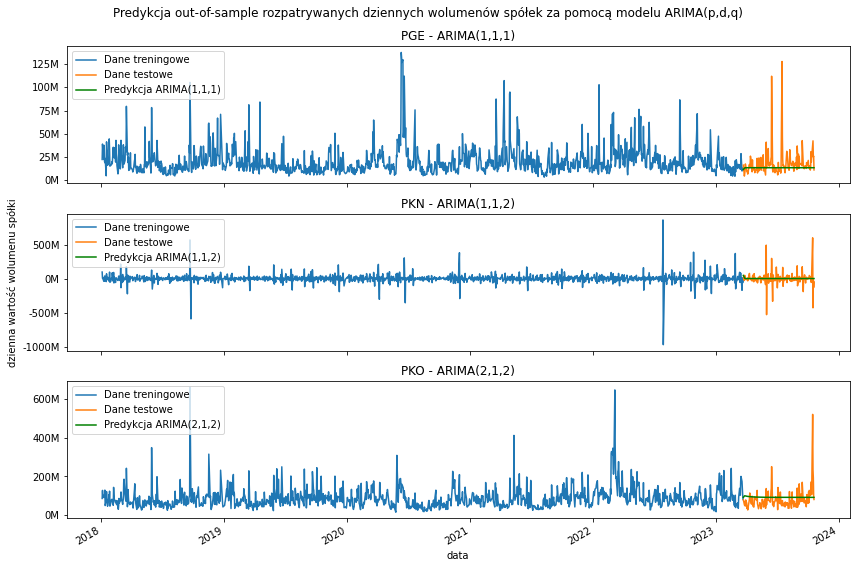

In [210]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_ARIMA, color='green', label = 'Predykcja ARIMA(1,1,1)')
ax2.plot(data_PKN_ARIMA, label="Dane treningowe")
ax2.plot(df_test_PKN, label="Dane testowe")
ax2.plot(PKN_pred_out_ARIMA, color='green', label = 'Predykcja ARIMA(1,1,2)')
ax3.plot(data_PKO_ARIMA, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_ARIMA, color='green', label = 'Predykcja ARIMA(2,1,2)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,1,1)")
ax2.title.set_text("PKN - ARIMA(1,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARIMA(2,1,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARIMA(p,d,q)") 
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)  
plt.gcf().autofmt_xdate()
plt.savefig("ARIMAobrona.png")

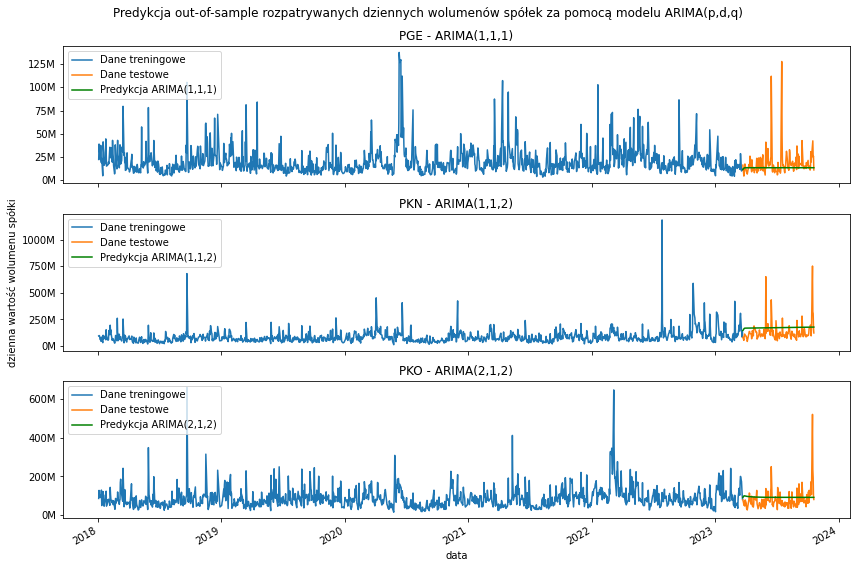

In [211]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_ARIMA, color='green', label = 'Predykcja ARIMA(1,1,1)')
ax2.plot(PKN["daily_turnover"][:1307], label="Dane treningowe")
ax2.plot(PKN["daily_turnover"][1307:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_ARIMA) + 100000000, color='green', label = 'Predykcja ARIMA(1,1,2)')
ax3.plot(data_PKO_ARIMA, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_ARIMA, color='green', label = 'Predykcja ARIMA(2,1,2)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,1,1)")
ax2.title.set_text("PKN - ARIMA(1,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARIMA(2,1,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("ARIMAobrona1.png")

### Podstawowe miary błędów dla powyższej ARIMA

In [63]:
# PGE 
PGE_pred = PGE_pred_out_ARIMA
PGE_true = df_test_PGE

mape_PGE_ARIMA = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_ARIMA = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_ARIMA = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_ARIMA = np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_ARIMA = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [64]:
# PKN
PKN_pred = np.cumsum(PKN_pred_out_ARIMA) + 100000000
PKN_true = PKN["daily_turnover"][1307:]

mape_PKN_ARIMA = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_ARIMA = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_ARIMA = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_ARIMA = np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_ARIMA = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [65]:
# PKO
PKO_pred = PKO_pred_out_ARIMA
PKO_true = df_test_PKO

mape_PKO_ARIMA = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARIMA = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARIMA = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARIMA = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARIMA = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar dla ARIMA 

In [66]:
results_arima = pd.DataFrame({'Method':['ARIMA - PGE', 'ARIMA - PKN', 'ARIMA - PKO'], 
                        'MAPE': [mape_PGE_ARIMA, mape_PKN_ARIMA, mape_PKO_ARIMA],'MAE': [mae_PGE_ARIMA,mae_PKN_ARIMA, mae_PKO_ARIMA], 'MPE': [mpe_PGE_ARIMA, mpe_PKN_ARIMA, mpe_PKO_ARIMA], 'RMSE': [rmse_PGE_ARIMA, rmse_PKN_ARIMA, rmse_PKO_ARIMA], 'CORR': [corr_PGE_ARIMA,corr_PKN_ARIMA,corr_PKO_ARIMA]})
results_arima

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARIMA - PGE  0.340189  7.357719e+06 -0.057507  1.519017e+07  0.046502
1  ARIMA - PKN  0.673669  7.121590e+07  0.608543  9.607957e+07  0.145546
2  ARIMA - PKO  0.555205  3.623892e+07  0.424554  5.388213e+07 -0.137181

### Model SARIMA (wbudowany)

In [67]:
data_PGE_SARIMA = df_train_PGE
data_PKN_SARIMA = df_train_PKN
data_PKO_SARIMA = df_train_PKO

df_PGE_SARIMA = pd.DataFrame()
df_PKN_SARIMA = pd.DataFrame()
df_PKO_SARIMA = pd.DataFrame()

ps_PGE_SARIMA = []
ps_PKN_SARIMA = []
ps_PKO_SARIMA = []
ds_PGE_SARIMA = []
ds_PKN_SARIMA = []
ds_PKO_SARIMA = []
qs_PGE_SARIMA = []
qs_PKN_SARIMA = []
qs_PKO_SARIMA = []
BIC_PGE_SARIMA = []
BIC_PKN_SARIMA = []
BIC_PKO_SARIMA = []
AIC_PGE_SARIMA = []
AIC_PKN_SARIMA = []
AIC_PKO_SARIMA = []
HQIC_PGE_SARIMA = []
HQIC_PKN_SARIMA = []
HQIC_PKO_SARIMA = []

max_p = 3
max_d = 3 
max_q = 3

for p in range(0, max_p):
    for d in range(0, max_d):
        for q in range(0, max_q):
            model_PGE = SARIMAX(data_PGE_SARIMA, order=(p, d, q))
            model_PKN = SARIMAX(data_PKN_SARIMA, order=(p, d, q))
            model_PKO = SARIMAX(data_PKO_SARIMA, order=(p, d, q))
            model_fit_PGE = model_PGE.fit()
            model_fit_PKN = model_PKN.fit()
            model_fit_PKO = model_PKO.fit()
            ps_PGE_SARIMA.append(p)
            ds_PGE_SARIMA.append(d)
            qs_PGE_SARIMA.append(q)
            ps_PKN_SARIMA.append(p)
            ds_PKN_SARIMA.append(d)
            qs_PKN_SARIMA.append(q)
            ps_PKO_SARIMA.append(p)
            ds_PKO_SARIMA.append(d)
            qs_PKO_SARIMA.append(q)
            AIC_PGE_SARIMA.append(model_fit_PGE.aic)
            BIC_PGE_SARIMA.append(model_fit_PGE.bic)
            HQIC_PGE_SARIMA.append(model_fit_PGE.hqic)
            AIC_PKN_SARIMA.append(model_fit_PKN.aic)
            BIC_PKN_SARIMA.append(model_fit_PKN.bic)
            HQIC_PKN_SARIMA.append(model_fit_PKN.hqic)
            AIC_PKO_SARIMA.append(model_fit_PKO.aic)
            BIC_PKO_SARIMA.append(model_fit_PKO.bic)
            HQIC_PKO_SARIMA.append(model_fit_PKO.hqic)

df_PGE_SARIMA['p']    = ps_PGE_SARIMA
df_PGE_SARIMA['d']    = ds_PGE_SARIMA
df_PGE_SARIMA['q']    = qs_PGE_SARIMA
df_PGE_SARIMA['AIC']  = AIC_PGE_SARIMA
df_PGE_SARIMA['BIC']  = BIC_PGE_SARIMA
df_PGE_SARIMA['HQIC'] = HQIC_PGE_SARIMA

df_PKN_SARIMA['p']    = ps_PKN_SARIMA
df_PKN_SARIMA['d']    = ds_PKN_SARIMA
df_PKN_SARIMA['q']    = qs_PKN_SARIMA
df_PKN_SARIMA['AIC']  = AIC_PKN_SARIMA
df_PKN_SARIMA['BIC']  = BIC_PKN_SARIMA
df_PKN_SARIMA['HQIC'] = HQIC_PKN_SARIMA

df_PKO_SARIMA['p']    = ps_PKO_SARIMA
df_PKO_SARIMA['d']    = ds_PKO_SARIMA
df_PKO_SARIMA['q']    = qs_PKO_SARIMA
df_PKO_SARIMA['AIC']  = AIC_PKO_SARIMA
df_PKO_SARIMA['BIC']  = BIC_PKO_SARIMA
df_PKO_SARIMA['HQIC'] = HQIC_PKO_SARIMA

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

In [68]:
df_PGE_SARIMA.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2  46385.940499  46411.814120  46395.646142
14  1  1  2  46401.737611  46422.436508  46409.502126
22  2  1  1  46406.612548  46427.311445  46414.377063
13  1  1  1  46409.134754  46424.658927  46414.958140
5   0  1  2  46418.968494  46434.492667  46424.791880

In [69]:
df_PGE_SARIMA.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2  46385.940499  46411.814120  46395.646142
14  1  1  2  46401.737611  46422.436508  46409.502126
13  1  1  1  46409.134754  46424.658927  46414.958140
22  2  1  1  46406.612548  46427.311445  46414.377063
5   0  1  2  46418.968494  46434.492667  46424.791880

In [70]:
df_PGE_SARIMA.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2  46385.940499  46411.814120  46395.646142
14  1  1  2  46401.737611  46422.436508  46409.502126
22  2  1  1  46406.612548  46427.311445  46414.377063
13  1  1  1  46409.134754  46424.658927  46414.958140
5   0  1  2  46418.968494  46434.492667  46424.791880

In [71]:
df_PKN_SARIMA.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2     10.000000     35.873622     19.705643
11  1  0  2  50382.878729  50403.580688  50390.644098
20  2  0  2  50383.303213  50409.180661  50393.009923
19  2  0  1  50388.312737  50409.014695  50396.078105
10  1  0  1  50389.447946  50404.974415  50395.271972

In [72]:
df_PKN_SARIMA.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2     10.000000     35.873622     19.705643
11  1  0  2  50382.878729  50403.580688  50390.644098
10  1  0  1  50389.447946  50404.974415  50395.271972
19  2  0  1  50388.312737  50409.014695  50396.078105
20  2  0  2  50383.303213  50409.180661  50393.009923

In [73]:
df_PKN_SARIMA.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2     10.000000     35.873622     19.705643
11  1  0  2  50382.878729  50403.580688  50390.644098
20  2  0  2  50383.303213  50409.180661  50393.009923
10  1  0  1  50389.447946  50404.974415  50395.271972
19  2  0  1  50388.312737  50409.014695  50396.078105

In [74]:
df_PKO_SARIMA.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2  49761.871181  49787.744803  49771.576825
14  1  1  2  49774.904626  49795.603524  49782.669141
22  2  1  1  49785.017751  49805.716649  49792.782266
13  1  1  1  49786.457277  49801.981450  49792.280663
5   0  1  2  49790.047309  49805.571482  49795.870695

In [75]:
df_PKO_SARIMA.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2  49761.871181  49787.744803  49771.576825
14  1  1  2  49774.904626  49795.603524  49782.669141
13  1  1  1  49786.457277  49801.981450  49792.280663
5   0  1  2  49790.047309  49805.571482  49795.870695
22  2  1  1  49785.017751  49805.716649  49792.782266

In [76]:
df_PKO_SARIMA.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
23  2  1  2  49761.871181  49787.744803  49771.576825
14  1  1  2  49774.904626  49795.603524  49782.669141
13  1  1  1  49786.457277  49801.981450  49792.280663
22  2  1  1  49785.017751  49805.716649  49792.782266
5   0  1  2  49790.047309  49805.571482  49795.870695

In [77]:
p1, d1, q1 = 1,1,1
p2, d2, q2 = 2,1,2
p3, d3, q3 = 1,1,1

model_PGE_SARIMA = SARIMAX(data_PGE_SARIMA, order=(p1,d1,q1), seasonal_order=(p1,d1,q1, 7))
model_PKN_SARIMA = SARIMAX(data_PKN_SARIMA, order=(p2,d2,q2), seasonal_order=(p2,d2,q2, 7))
model_PKO_SARIMA = SARIMAX(data_PKO_SARIMA, order=(p3,d3,q3), seasonal_order=(p3,d3,q3, 7))
result_PGE_SARIMA = model_PGE_SARIMA.fit()
result_PKN_SARIMA = model_PKN_SARIMA.fit()
result_PKO_SARIMA = model_PKO_SARIMA.fit()
print(result_PGE_SARIMA.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                    daily_turnover   No. Observations:                 1307
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -23240.255
Date:                           Sun, 04 Feb 2024   AIC                          46490.510
Time:                                   11:32:36   BIC                          46516.357
Sample:                                        0   HQIC                         46500.208
                                          - 1307                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3184      0.046      6.900      0.000       0.228       0.409
ma.L1         -0.8980      0.024    -37.820

In [78]:
predicted_result_PGE_SARIMA = result_PGE_SARIMA.predict(start=0, end=600)
predicted_result_PKN_SARIMA = result_PKN_SARIMA.predict(start=0, end=600)
predicted_result_PKO_SARIMA = result_PKO_SARIMA.predict(start=0, end=600)

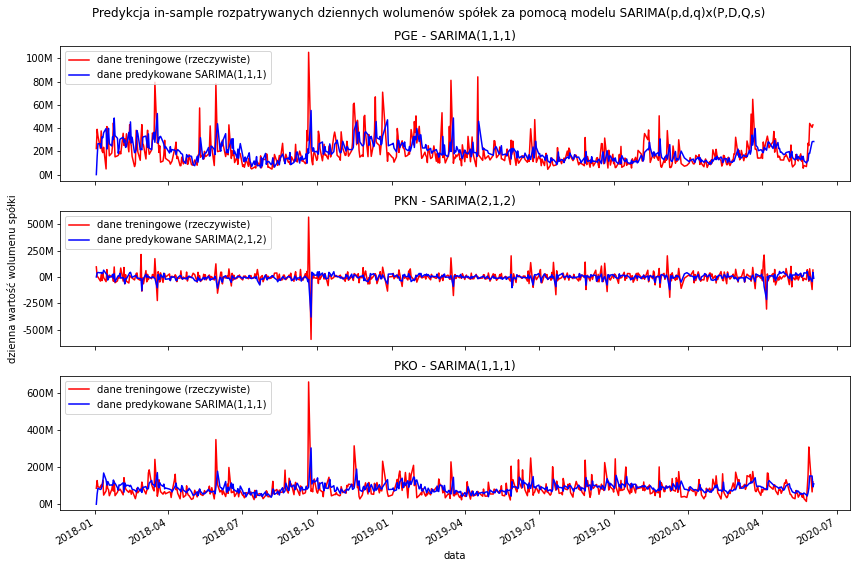

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA[0:600], color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_SARIMA, color='blue', label="dane predykowane SARIMA(1,1,1)")
ax2.plot(data_PKN_SARIMA[0:600], color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_SARIMA, color='blue', label="dane predykowane SARIMA(2,1,2)")
ax3.plot(data_PKO_SARIMA[0:600], color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_SARIMA, color='blue', label="dane predykowane SARIMA(1,1,1)")
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,1,1)")
ax2.title.set_text("PKN - SARIMA(2,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - SARIMA(1,1,1)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja in-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)")   
plt.gcf().autofmt_xdate()
plt.savefig("19.pdf")

### Forecasting dla szeregu SARIMA(p, d, q) - 1 rok do przodu

In [80]:
forecast_test_PGE_SARIMA = result_PGE_SARIMA.get_forecast(len(df_test_PGE.index))
PGE_pred_df_SARIMA = forecast_test_PGE_SARIMA.conf_int(alpha = 0.05) 
PGE_pred_df_SARIMA["Predictions"] = result_PGE_SARIMA.predict(start = PGE_pred_df_SARIMA.index[0], end = PGE_pred_df_SARIMA.index[-1])
PGE_pred_df_SARIMA.index = df_test_PGE.index
PGE_pred_out_SARIMA = PGE_pred_df_SARIMA["Predictions"] 

forecast_test_PKN_SARIMA = result_PKN_SARIMA.get_forecast(len(df_test_PKN.index))
PKN_pred_df_SARIMA = forecast_test_PKN_SARIMA.conf_int(alpha = 0.05) 
PKN_pred_df_SARIMA["Predictions"] = result_PKN_SARIMA.predict(start = PKN_pred_df_SARIMA.index[0], end = PKN_pred_df_SARIMA.index[-1])
PKN_pred_df_SARIMA.index = df_test_PKN.index
PKN_pred_out_SARIMA = PKN_pred_df_SARIMA["Predictions"] 

forecast_test_PKO_SARIMA = result_PKO_SARIMA.get_forecast(len(df_test_PKO.index))
PKO_pred_df_SARIMA = forecast_test_PKO_SARIMA.conf_int(alpha = 0.05) 
PKO_pred_df_SARIMA["Predictions"] = result_PKO_SARIMA.predict(start = PKO_pred_df_SARIMA.index[0], end = PKO_pred_df_SARIMA.index[-1])
PKO_pred_df_SARIMA.index = df_test_PKO.index
PKO_pred_out_SARIMA = PKO_pred_df_SARIMA["Predictions"] 


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program F

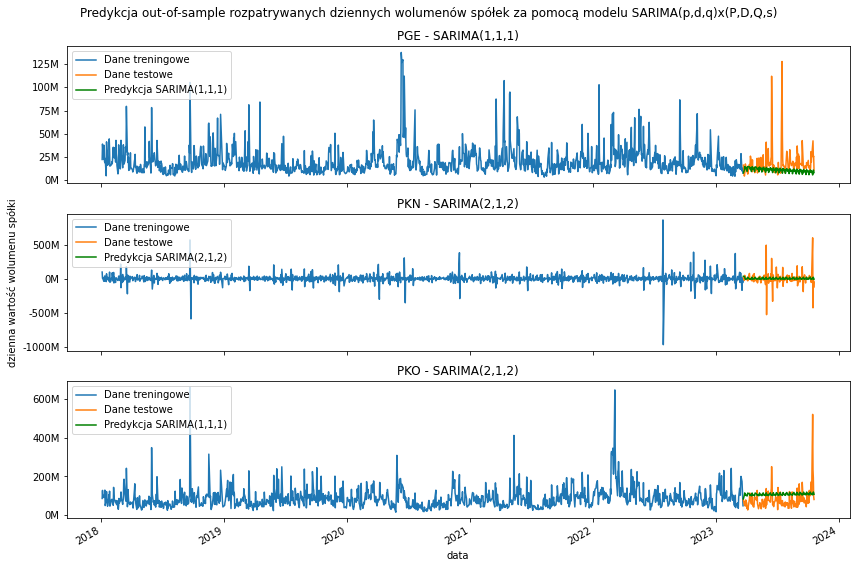

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_SARIMA, color='green', label = 'Predykcja SARIMA(1,1,1)')
ax2.plot(data_PKN_SARIMA, label="Dane treningowe")
ax2.plot(df_test_PKN, label="Dane testowe")
ax2.plot(PKN_pred_out_SARIMA, color='green', label = 'Predykcja SARIMA(2,1,2)')
ax3.plot(data_PKO_SARIMA, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_SARIMA, color='green', label = 'Predykcja SARIMA(1,1,1)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,1,1)")
ax2.title.set_text("PKN - SARIMA(2,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - SARIMA(2,1,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)")   
plt.gcf().autofmt_xdate()
plt.savefig("20.pdf")

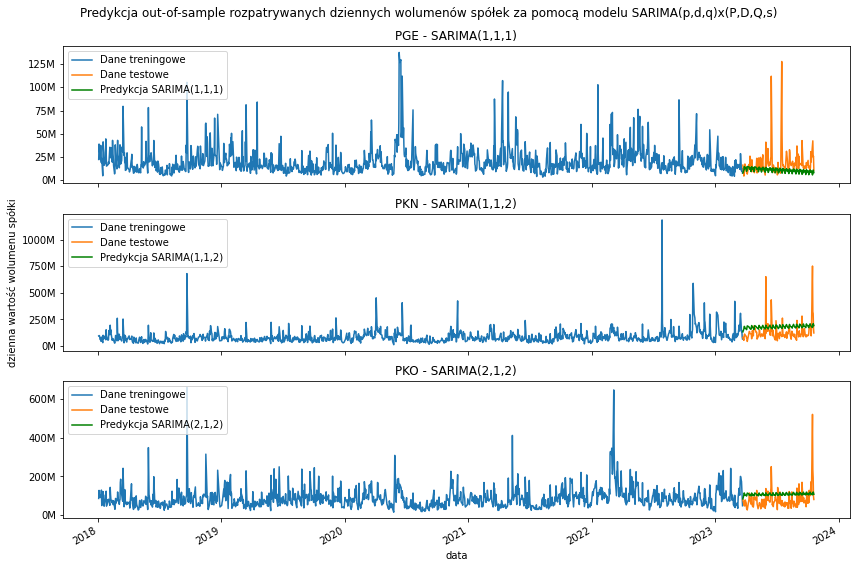

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_SARIMA, color='green', label = 'Predykcja SARIMA(1,1,1)')
ax2.plot(PKN["daily_turnover"][:1307], label="Dane treningowe")
ax2.plot(PKN["daily_turnover"][1307:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_SARIMA) + 100000000, color='green', label = 'Predykcja SARIMA(1,1,2)')
ax3.plot(data_PKO_SARIMA, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_SARIMA, color='green', label = 'Predykcja SARIMA(2,1,2)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,1,1)")
ax2.title.set_text("PKN - SARIMA(1,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - SARIMA(2,1,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)")   
plt.gcf().autofmt_xdate()
plt.savefig("21.pdf")

### Podstawowe miary błędów dla powyższej SARIMA

In [83]:
# PGE 
PGE_pred = PGE_pred_out_SARIMA
PGE_true = df_test_PGE

mape_PGE_SARIMA = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_SARIMA = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_SARIMA = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_SARIMA = np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_SARIMA = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [84]:
# PKN
PKN_pred = np.cumsum(PKN_pred_out_SARIMA) + 100000000
PKN_true = PKN["daily_turnover"][1307:]

mape_PKN_SARIMA = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_SARIMA = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_SARIMA = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_SARIMA = np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_SARIMA = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [85]:
# PKO
PKO_pred = PKO_pred_out_SARIMA
PKO_true = df_test_PKO

mape_PKO_SARIMA = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_SARIMA = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_SARIMA = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_SARIMA = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_SARIMA = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar dla SAMIRA

In [86]:
results_sarima = pd.DataFrame({'Method':['SARIMA - PGE', 'SARIMA - PKN', 'SARIMA - PKO'], 
                        'MAPE': [mape_PGE_SARIMA, mape_PKN_SARIMA, mape_PKO_SARIMA],'MAE': [mae_PGE_SARIMA,mae_PKN_SARIMA, mae_PKO_SARIMA], 'MPE': [mpe_PGE_SARIMA, mpe_PKN_SARIMA, mpe_PKO_SARIMA], 'RMSE': [rmse_PGE_SARIMA, rmse_PKN_SARIMA, rmse_PKO_SARIMA], 'CORR': [corr_PGE_SARIMA,corr_PKN_SARIMA,corr_PKO_SARIMA]})
results_sarima

Method      MAPE           MAE       MPE          RMSE      CORR
0  SARIMA - PGE  0.405542  9.055228e+06 -0.234301  1.649004e+07 -0.039672
1  SARIMA - PKN  0.739504  7.761165e+07  0.680426  1.000950e+08  0.105782
2  SARIMA - PKO  0.737687  4.515053e+07  0.654952  5.904587e+07  0.044592

### Podsumowanie dotychczasowych wyników 

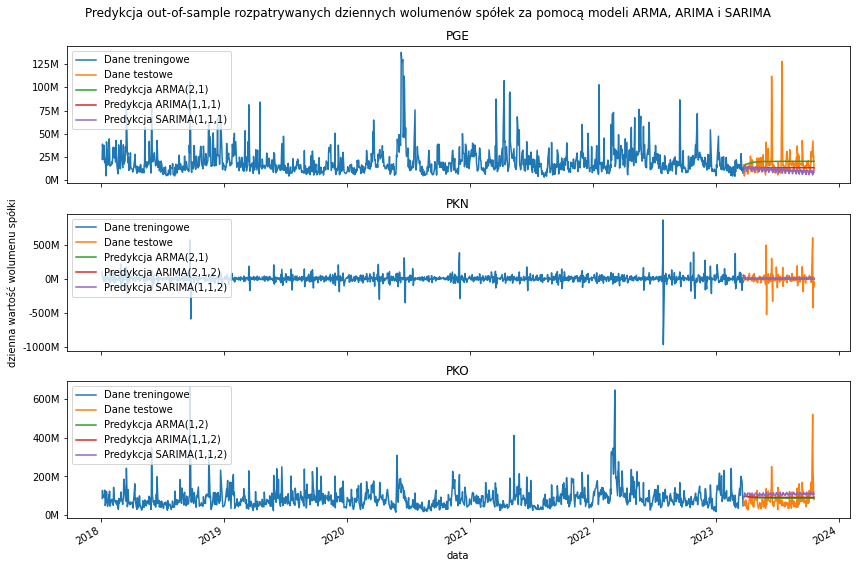

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(df_train_PGE, label="Dane treningowe")
ax1.plot(df_test_PGE, label="Dane testowe")
ax1.plot(PGE_pred_out_ARMA, label = 'Predykcja ARMA(2,1)')
ax1.plot(PGE_pred_out_ARIMA, label = 'Predykcja ARIMA(1,1,1)')
ax1.plot(PGE_pred_out_SARIMA, label = 'Predykcja SARIMA(1,1,1)')
ax2.plot(df_train_PKN, label="Dane treningowe")
ax2.plot(df_test_PKN, label="Dane testowe")
ax2.plot(PKN_pred_out_ARMA, label = 'Predykcja ARMA(2,1)')
ax2.plot(PKN_pred_out_ARIMA,  label = 'Predykcja ARIMA(2,1,2)')
ax2.plot(PKN_pred_out_SARIMA, label = 'Predykcja SARIMA(1,1,2)')
ax3.plot(df_train_PKO, label="Dane treningowe")
ax3.plot(df_test_PKO, label="Dane testowe")
ax3.plot(PKO_pred_out_ARMA, label = 'Predykcja ARMA(1,2)')
ax3.plot(PKO_pred_out_ARIMA, label = 'Predykcja ARIMA(1,1,2)')
ax3.plot(PKO_pred_out_SARIMA, label = 'Predykcja SARIMA(1,1,2)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE")
ax2.title.set_text("PKN")
ax3.set_xlabel("data")
ax3.title.set_text("PKO")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modeli ARMA, ARIMA i SARIMA")   
plt.gcf().autofmt_xdate()
plt.savefig("22.pdf")

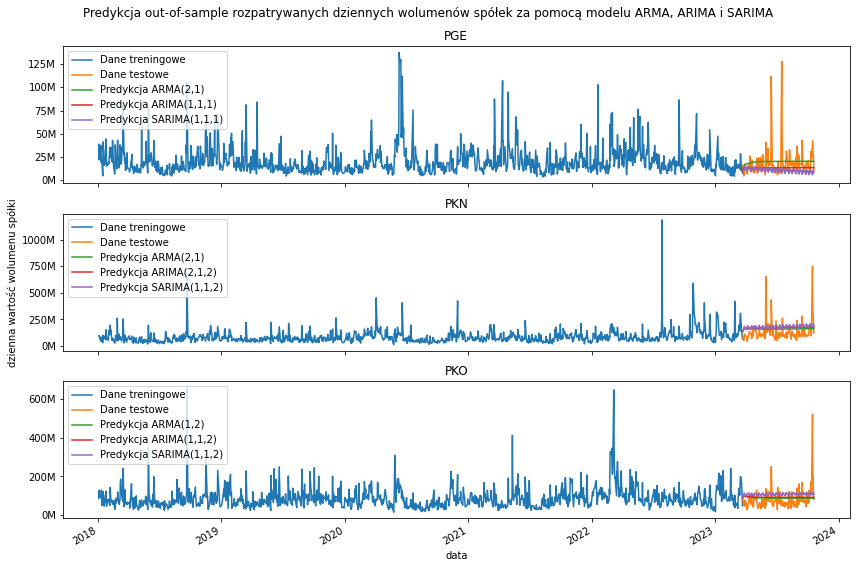

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(PGE["daily_turnover"][:1307], label="Dane treningowe")
ax1.plot(PGE["daily_turnover"][1307:], label="Dane testowe")
ax1.plot(PGE_pred_out_ARMA, label = 'Predykcja ARMA(2,1)')
ax1.plot(PGE_pred_out_ARIMA, label = 'Predykcja ARIMA(1,1,1)')
ax1.plot(PGE_pred_out_SARIMA, label = 'Predykcja SARIMA(1,1,1)')
ax2.plot(PKN["daily_turnover"][:1307], label="Dane treningowe")
ax2.plot(PKN["daily_turnover"][1307:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_ARMA) + 100000000, label = 'Predykcja ARMA(2,1)')
ax2.plot(np.cumsum(PKN_pred_out_ARIMA) + 100000000,  label = 'Predykcja ARIMA(2,1,2)')
ax2.plot(np.cumsum(PKN_pred_out_SARIMA) + 100000000, label = 'Predykcja SARIMA(1,1,2)')
ax3.plot(PKO["daily_turnover"][:1307], label="Dane treningowe")
ax3.plot(PKO["daily_turnover"][1307:], label="Dane testowe")
ax3.plot(PKO_pred_out_ARMA, label = 'Predykcja ARMA(1,2)')
ax3.plot(PKO_pred_out_ARIMA, label = 'Predykcja ARIMA(1,1,2)')
ax3.plot(PKO_pred_out_SARIMA, label = 'Predykcja SARIMA(1,1,2)')
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE")
ax2.title.set_text("PKN")
ax3.set_xlabel("data")
ax3.title.set_text("PKO")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARMA, ARIMA i SARIMA")   
plt.gcf().autofmt_xdate()
plt.savefig("23.pdf")

## Dane tygodniowe 

### Zmiana na dane tygodniowe 

In [89]:
PGE_resample = PGE.resample('W').mean()
PKN_resample = PKN.resample('W').mean()
PKO_resample = PKO.resample('W').mean()
PKN_resample

daily_turnover    diff_daily
date                                    
2018-01-07    9.730886e+07  3.262079e+07
2018-01-14    6.855602e+07 -4.285683e+06
2018-01-21    7.265556e+07  1.255637e+06
2018-01-28    9.871960e+07  3.110065e+06
2018-02-04    7.817080e+07  9.598872e+06
...                    ...           ...
2023-09-24    1.105573e+08 -2.397863e+07
2023-10-01    9.498199e+07 -1.392231e+07
2023-10-08    1.182602e+08  1.490655e+07
2023-10-15    1.542984e+08 -2.596920e+06
2023-10-22    3.355364e+08 -6.279736e+06

[303 rows x 2 columns]

### Sprawdzanie stacjonarności danych - dane tygodniowe 

In [90]:
PGE_test_resample = adfuller(PGE_resample["daily_turnover"])
PKN_test_resample = adfuller(PKN_resample["daily_turnover"])
PKO_test_resample = adfuller(PKO_resample["daily_turnover"])

PGE_test_resample1 = kpss(PGE_resample["daily_turnover"])
PKN_test_resample1 = kpss(PKN_resample["daily_turnover"])
PKO_test_resample1 = kpss(PKO_resample["daily_turnover"])

print("PGE: p-value z testu Augmented Dickey-Fuller'a", PGE_test_resample[1]) # stacjonarne
print("PKN: p-value z testu Augmented Dickey-Fuller'a", PKN_test_resample[1]) # niestacjonarne
print("PKO: p-value z testu Augmented Dickey-Fuller'a", PKO_test_resample[1]) # stacjonarne

print("PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PGE_test_resample1[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKN_test_resample1[1]) # niestacjonarne
print("PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKO_test_resample1[1]) # stacjonarne

PGE: p-value z testu Augmented Dickey-Fuller'a 4.804044125096476e-18
PKN: p-value z testu Augmented Dickey-Fuller'a 0.41927023745743464
PKO: p-value z testu Augmented Dickey-Fuller'a 1.9019884844886317e-16
PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.01
PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


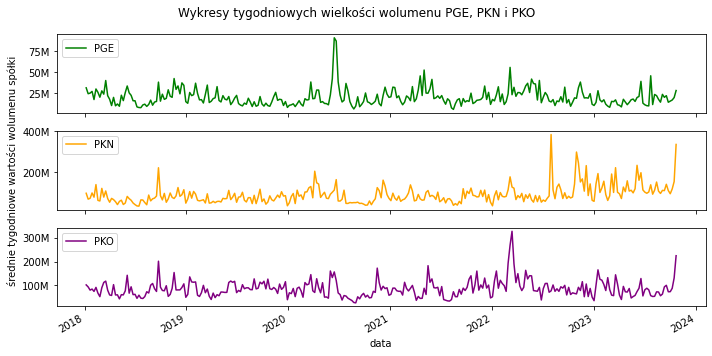

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(10,5))
ax1.plot(PGE_resample["daily_turnover"], color="green", label="PGE")
ax2.plot(PKN_resample["daily_turnover"], color="orange", label="PKN")
ax3.plot(PKO_resample["daily_turnover"], color="purple", label="PKO")
ax2.set_ylabel("średnie tygodniowe wartości wolumenu spółki")
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Wykresy tygodniowych wielkości wolumenu PGE, PKN i PKO")
plt.gcf().autofmt_xdate()
plt.savefig("4.pdf")

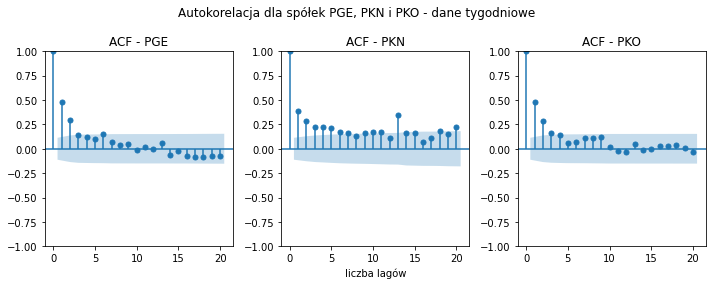

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
plot_acf(PGE_resample["daily_turnover"], lags=20, ax=ax1)
plot_acf(PKN_resample["daily_turnover"], lags=20, ax=ax2)
plot_acf(PKO_resample["daily_turnover"], lags=20, ax=ax3)
ax1.set_title("ACF - PGE")
ax2.set_title("ACF - PKN")
ax3.set_title("ACF - PKO")
ax2.set_xlabel("liczba lagów")
fig.suptitle("Autokorelacja dla spółek PGE, PKN i PKO - dane tygodniowe")
plt.savefig("5.pdf")

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


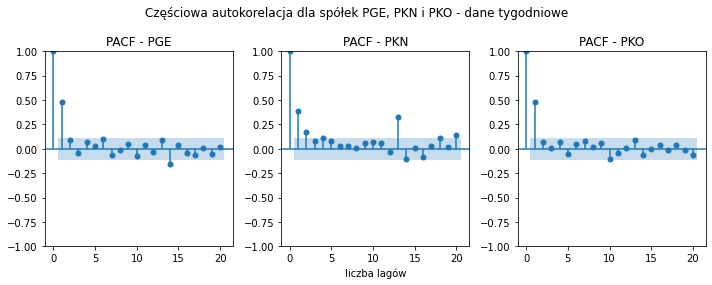

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
plot_pacf(PGE_resample["daily_turnover"], lags=20, ax=ax1)
plot_pacf(PKN_resample["daily_turnover"], lags=20, ax=ax2)
plot_pacf(PKO_resample["daily_turnover"], lags=20, ax=ax3)
ax1.set_title("PACF - PGE")
ax2.set_title("PACF - PKN")
ax3.set_title("PACF - PKO")
ax2.set_xlabel("liczba lagów")
fig.suptitle("Częściowa autokorelacja dla spółek PGE, PKN i PKO - dane tygodniowe")
plt.savefig("6.pdf")

### Sprawdzanie stacjonarności danych - dane tygodniowe

In [94]:
PGE_resample_test = adfuller(PGE_resample["daily_turnover"])
PKN_resample_test = adfuller(PKN_resample["daily_turnover"])
PKO_resample_test = adfuller(PKO_resample["daily_turnover"])

PGE_resample_test1 = kpss(PGE_resample["daily_turnover"])
PKN_resample_test1 = kpss(PKN_resample["daily_turnover"])
PKO_resample_test1 = kpss(PKO_resample["daily_turnover"])

print("PGE: p-value z testu Augmented Dickey-Fuller'a", PGE_resample_test[1]) # stacjonarne
print("PKN: p-value z testu Augmented Dickey-Fuller'a", PKN_resample_test[1]) # NIE stacjonarne
print("PKO: p-value z testu Augmented Dickey-Fuller'a", PKO_resample_test[1]) # stacjonarne

print("PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PGE_resample_test1[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKN_resample_test1[1]) # nie stacjonarne
print("PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKO_resample_test1[1]) # stacjonarne

PGE: p-value z testu Augmented Dickey-Fuller'a 4.804044125096476e-18
PKN: p-value z testu Augmented Dickey-Fuller'a 0.41927023745743464
PKO: p-value z testu Augmented Dickey-Fuller'a 1.9019884844886317e-16
PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.01
PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Tworzenie danych stacjonarnych

In [95]:
diff_weekly = np.diff(PKN_resample["daily_turnover"])
diff_weekly_0 = np.insert(diff_weekly, 0, PKN_resample["daily_turnover"].iloc[0])
PKN_resample['diff_weekly'] = diff_weekly_0

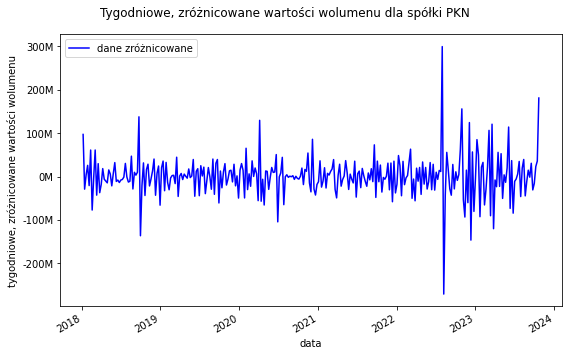

In [212]:
fig, (ax2) = plt.subplots(1,1, tight_layout=True, figsize=(8,5))
ax2.plot(PKN_resample['diff_weekly'], color="blue", label="dane zróżnicowane")
ax2.set_ylabel("tygodniowe, zróżnicowane wartości wolumenu")
ax2.set_xlabel("data")
fig.suptitle("Tygodniowe, zróżnicowane wartości wolumenu dla spółki PKN")
plt.gcf().autofmt_xdate()
ax2.yaxis.set_major_formatter(formatter)
ax2.legend()
plt.savefig('roznicowanie_obrona.png')

### Testy na stacjonarność danych zlogarytmizowanych - dane tygodniowe

In [97]:
returns_PKN_test_resample = adfuller(PKN_resample['diff_weekly'])
returns_PKN_test1_resample = kpss(PKN_resample['diff_weekly'])

print("PKN: p-value z testu Augmented Dickey-Fuller'a", returns_PKN_test_resample[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", returns_PKN_test1_resample[1]) # stacjonarne

PKN: p-value z testu Augmented Dickey-Fuller'a 8.819222379225559e-08
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Dane testowe i treningowe dla danych tygodniowych

In [98]:
df_train_PGE_week = PGE_resample["daily_turnover"][:273]
df_test_PGE_week = PGE_resample["daily_turnover"][273:]

df_train_PKN_week = PKN_resample["diff_weekly"][:273]
df_test_PKN_week = PKN_resample["diff_weekly"][273:]

df_train_PKO_week = PKO_resample["daily_turnover"][:273]
df_test_PKO_week = PKO_resample["daily_turnover"][273:]

### Model ARIMA - dane tygodniowe

In [99]:
data_PGE_ARIMA_week = df_train_PGE_week
data_PKN_ARIMA_week = df_train_PKN_week
data_PKO_ARIMA_week = df_train_PKO_week

df_PGE_ARIMA_week = pd.DataFrame()
df_PKN_ARIMA_week = pd.DataFrame()
df_PKO_ARIMA_week = pd.DataFrame()

ps_PGE_ARIMA_week = []
ps_PKN_ARIMA_week = []
ps_PKO_ARIMA_week = []
ds_PGE_ARIMA_week = []
ds_PKN_ARIMA_week = []
ds_PKO_ARIMA_week = []
qs_PGE_ARIMA_week = []
qs_PKN_ARIMA_week = []
qs_PKO_ARIMA_week = []
BIC_PGE_ARIMA_week = []
BIC_PKN_ARIMA_week = []
BIC_PKO_ARIMA_week = []
AIC_PGE_ARIMA_week = []
AIC_PKN_ARIMA_week = []
AIC_PKO_ARIMA_week = []
HQIC_PGE_ARIMA_week = []
HQIC_PKN_ARIMA_week = []
HQIC_PKO_ARIMA_week = []

max_p = 3
max_d = 3 
max_q = 3

for p in range(1, max_p):
    for d in range(1, max_d):
        for q in range(1, max_q):
            model_PGE_week = ARIMA(data_PGE_ARIMA_week, order=(p, d, q))
            model_PKN_week = ARIMA(data_PKN_ARIMA_week, order=(p, d, q))
            model_PKO_week = ARIMA(data_PKO_ARIMA_week, order=(p, d, q))
            model_fit_PGE_week = model_PGE_week.fit()
            model_fit_PKN_week = model_PKN_week.fit()
            model_fit_PKO_week = model_PKO_week.fit()
            ps_PGE_ARIMA_week.append(p)
            ps_PKN_ARIMA_week.append(p)
            ps_PKO_ARIMA_week.append(p)
            ds_PGE_ARIMA_week.append(d)
            ds_PKN_ARIMA_week.append(d)
            ds_PKO_ARIMA_week.append(d)
            qs_PGE_ARIMA_week.append(q)
            qs_PKN_ARIMA_week.append(q)
            qs_PKO_ARIMA_week.append(q)
            AIC_PGE_ARIMA_week.append(model_fit_PGE_week.aic)
            AIC_PKN_ARIMA_week.append(model_fit_PKN_week.aic)
            AIC_PKO_ARIMA_week.append(model_fit_PKO_week.aic)
            BIC_PGE_ARIMA_week.append(model_fit_PGE_week.bic)
            BIC_PKN_ARIMA_week.append(model_fit_PKN_week.bic)
            BIC_PKO_ARIMA_week.append(model_fit_PKO_week.bic)
            HQIC_PGE_ARIMA_week.append(model_fit_PGE_week.hqic)
            HQIC_PKN_ARIMA_week.append(model_fit_PKN_week.hqic)
            HQIC_PKO_ARIMA_week.append(model_fit_PKO_week.hqic)

df_PGE_ARIMA_week['p']    = ps_PGE_ARIMA_week
df_PGE_ARIMA_week['d']    = ds_PGE_ARIMA_week
df_PGE_ARIMA_week['q']    = qs_PGE_ARIMA_week
df_PGE_ARIMA_week['AIC']  = AIC_PGE_ARIMA_week
df_PGE_ARIMA_week['BIC']  = BIC_PGE_ARIMA_week
df_PGE_ARIMA_week['HQIC'] = HQIC_PGE_ARIMA_week

df_PKN_ARIMA_week['p']    = ps_PKN_ARIMA_week
df_PKN_ARIMA_week['d']    = ds_PKN_ARIMA_week
df_PKN_ARIMA_week['q']    = qs_PKN_ARIMA_week
df_PKN_ARIMA_week['AIC']  = AIC_PKN_ARIMA_week
df_PKN_ARIMA_week['BIC']  = BIC_PKN_ARIMA_week
df_PKN_ARIMA_week['HQIC'] = HQIC_PKN_ARIMA_week

df_PKO_ARIMA_week['p']    = ps_PKO_ARIMA_week
df_PKO_ARIMA_week['d']    = ds_PKO_ARIMA_week
df_PKO_ARIMA_week['q']    = qs_PKO_ARIMA_week
df_PKO_ARIMA_week['AIC']  = AIC_PKO_ARIMA_week
df_PKO_ARIMA_week['BIC']  = BIC_PKO_ARIMA_week
df_PKO_ARIMA_week['HQIC'] = HQIC_PKO_ARIMA_week

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Prog

In [100]:
df_PGE_ARIMA_week.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  9484.509830  9498.918305  9490.294989
5  2  1  2  9491.114320  9509.143330  9498.352341
1  1  1  2  9492.738035  9507.161243  9498.528452
4  2  1  1  9492.770350  9507.193558  9498.560767
0  1  1  1  9492.848276  9503.665682  9497.191089

In [101]:
df_PGE_ARIMA_week.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  9484.509830  9498.918305  9490.294989
0  1  1  1  9492.848276  9503.665682  9497.191089
1  1  1  2  9492.738035  9507.161243  9498.528452
4  2  1  1  9492.770350  9507.193558  9498.560767
5  2  1  2  9491.114320  9509.143330  9498.352341

In [102]:
df_PGE_ARIMA_week.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  9484.509830  9498.918305  9490.294989
0  1  1  1  9492.848276  9503.665682  9497.191089
5  2  1  2  9491.114320  9509.143330  9498.352341
1  1  1  2  9492.738035  9507.161243  9498.528452
4  2  1  1  9492.770350  9507.193558  9498.560767

In [103]:
df_PKN_ARIMA_week.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
1  1  1  2  10302.054933  10316.478141  10307.845350
5  2  1  2  10337.404590  10355.433600  10344.642611
4  2  1  1  10339.213275  10353.636483  10345.003692
7  2  2  2  10344.911854  10362.922448  10352.143303
0  1  1  1  10350.058831  10360.876238  10354.401644

In [104]:
df_PKN_ARIMA_week.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
1  1  1  2  10302.054933  10316.478141  10307.845350
4  2  1  1  10339.213275  10353.636483  10345.003692
5  2  1  2  10337.404590  10355.433600  10344.642611
0  1  1  1  10350.058831  10360.876238  10354.401644
7  2  2  2  10344.911854  10362.922448  10352.143303

In [105]:
df_PKN_ARIMA_week.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
1  1  1  2  10302.054933  10316.478141  10307.845350
5  2  1  2  10337.404590  10355.433600  10344.642611
4  2  1  1  10339.213275  10353.636483  10345.003692
7  2  2  2  10344.911854  10362.922448  10352.143303
0  1  1  1  10350.058831  10360.876238  10354.401644

In [106]:
df_PKO_ARIMA_week.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
3  1  2  2  10176.193228  10190.601704  10181.978387
0  1  1  1  10180.248903  10191.066310  10184.591716
1  1  1  2  10180.467974  10194.891182  10186.258391
4  2  1  1  10180.471263  10194.894471  10186.261680
5  2  1  2  10180.722212  10198.751223  10187.960234

In [107]:
df_PKO_ARIMA_week.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
3  1  2  2  10176.193228  10190.601704  10181.978387
0  1  1  1  10180.248903  10191.066310  10184.591716
1  1  1  2  10180.467974  10194.891182  10186.258391
4  2  1  1  10180.471263  10194.894471  10186.261680
5  2  1  2  10180.722212  10198.751223  10187.960234

In [108]:
df_PKO_ARIMA_week.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
3  1  2  2  10176.193228  10190.601704  10181.978387
0  1  1  1  10180.248903  10191.066310  10184.591716
1  1  1  2  10180.467974  10194.891182  10186.258391
4  2  1  1  10180.471263  10194.894471  10186.261680
5  2  1  2  10180.722212  10198.751223  10187.960234

In [109]:
p1, d1, q1 = 1,2,2

model_PGE_ARIMA_week = ARIMA(data_PGE_ARIMA_week, order=(p1,d1,q1))
model_PKN_ARIMA_week = ARIMA(data_PKN_ARIMA_week, order=(p1,d1,q1))
model_PKO_ARIMA_week = ARIMA(data_PKO_ARIMA_week, order=(p1,d1,q1))
result_PGE_ARIMA_week = model_PGE_ARIMA_week.fit()
result_PKN_ARIMA_week = model_PKN_ARIMA_week.fit()
result_PKO_ARIMA_week = model_PKO_ARIMA_week.fit()
print(result_PKO_ARIMA_week.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         daily_turnover   No. Observations:                  273
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -5084.097
Date:                Sun, 04 Feb 2024   AIC                          10176.193
Time:                        11:32:59   BIC                          10190.602
Sample:                    01-07-2018   HQIC                         10181.978
                         - 03-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4634      0.082      5.629      0.000       0.302       0.625
ma.L1         -1.9415      0.039    -50.378      0.000      -2.017      -1.866
ma.L2          0.9419      0.037     25.119      0.0

In [110]:
predicted_result_PGE_ARIMA_week = result_PGE_ARIMA_week.predict(start=0, end=len(df_train_PGE_week))
predicted_result_PKN_ARIMA_week = result_PKN_ARIMA_week.predict(start=0, end=len(df_train_PKN_week))
predicted_result_PKO_ARIMA_week = result_PKO_ARIMA_week.predict(start=0, end=len(df_train_PKO_week))

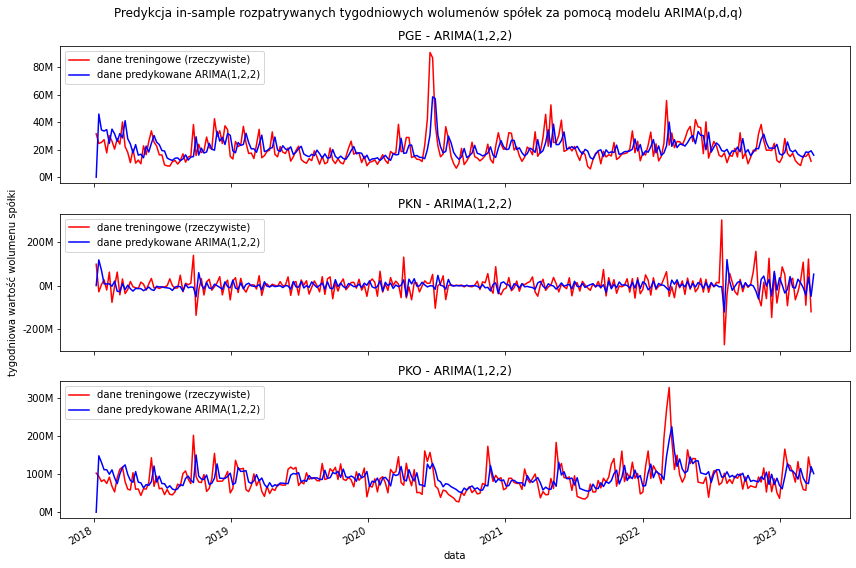

In [111]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA_week, color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_ARIMA_week, color='blue', label="dane predykowane ARIMA(1,2,2)")
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_ARIMA_week, color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_ARIMA_week, color='blue', label="dane predykowane ARIMA(1,2,2)")
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_ARIMA_week, color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_ARIMA_week, color='blue', label="dane predykowane ARIMA(1,2,2)")
ax3.title.set_text("PKO - ARIMA(1,2,2)")
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.yaxis.set_major_formatter(formatter)

fig.suptitle("Predykcja in-sample rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("24.pdf")

### Forecasting dla modelu ARIMA(p, d, q) - 1 rok do przodu 

In [112]:
# PGE
forecast_test_PGE_ARIMA_week = result_PGE_ARIMA_week.get_forecast(len(df_test_PGE_week.index))
PGE_pred_df_ARIMA_week = forecast_test_PGE_ARIMA_week.conf_int(alpha = 0.05) 
PGE_pred_df_ARIMA_week["Predictions"] = result_PGE_ARIMA_week.predict(start = PGE_pred_df_ARIMA_week.index[0], end = PGE_pred_df_ARIMA_week.index[-1])
PGE_pred_df_ARIMA_week.index = df_test_PGE_week.index
PGE_pred_out_ARIMA_week = PGE_pred_df_ARIMA_week["Predictions"] 

# PKN
forecast_test_PKN_ARIMA_week = result_PKN_ARIMA_week.get_forecast(len(df_test_PKN_week.index))
PKN_pred_df_ARIMA_week = forecast_test_PKN_ARIMA_week.conf_int(alpha = 0.05) 
PKN_pred_df_ARIMA_week["Predictions"] = result_PKN_ARIMA_week.predict(start = PKN_pred_df_ARIMA_week.index[0], end = PKN_pred_df_ARIMA_week.index[-1])
PKN_pred_df_ARIMA_week.index = df_test_PKN_week.index
PKN_pred_out_ARIMA_week = PKN_pred_df_ARIMA_week["Predictions"] 

# PKO
forecast_test_PKO_ARIMA_week = result_PKO_ARIMA_week.get_forecast(len(df_test_PKO_week.index))
PKO_pred_df_ARIMA_week = forecast_test_PKO_ARIMA_week.conf_int(alpha = 0.05) 
PKO_pred_df_ARIMA_week["Predictions"] = result_PKO_ARIMA_week.predict(start = PKO_pred_df_ARIMA_week.index[0], end = PKO_pred_df_ARIMA_week.index[-1])
PKO_pred_df_ARIMA_week.index = df_test_PKO_week.index
PKO_pred_out_ARIMA_week = PKO_pred_df_ARIMA_week["Predictions"] 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


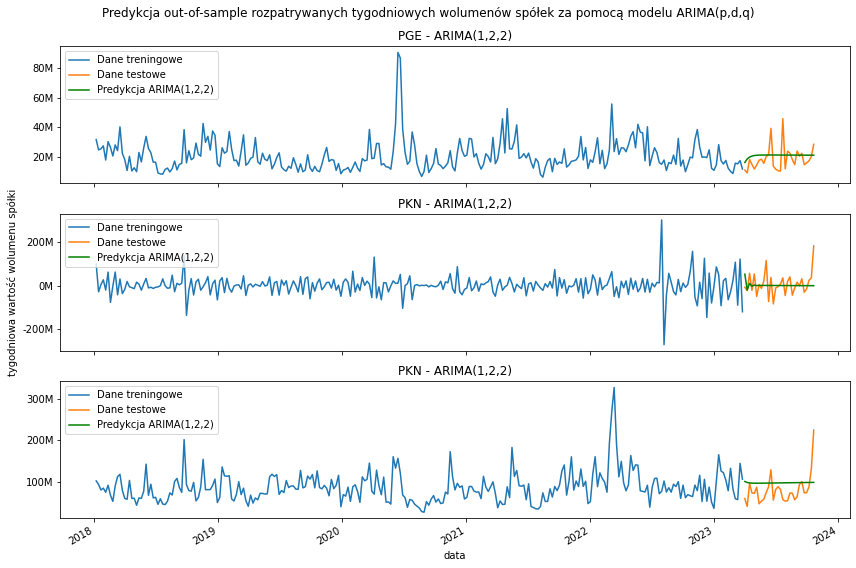

In [113]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA_week, label="Dane treningowe")
ax1.plot(df_test_PGE_week, label="Dane testowe")
ax1.plot(PGE_pred_out_ARIMA_week, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_ARIMA_week, label="Dane treningowe")
ax2.plot(df_test_PKN_week, label="Dane testowe")
ax2.plot(PKN_pred_out_ARIMA_week, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_ARIMA_week, label="Dane treningowe")
ax3.plot(df_test_PKO_week, label="Dane testowe")
ax3.plot(PKO_pred_out_ARIMA_week, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax3.title.set_text("PKN - ARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja out-of-sample rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)") 
plt.gcf().autofmt_xdate()
plt.savefig("25.pdf")

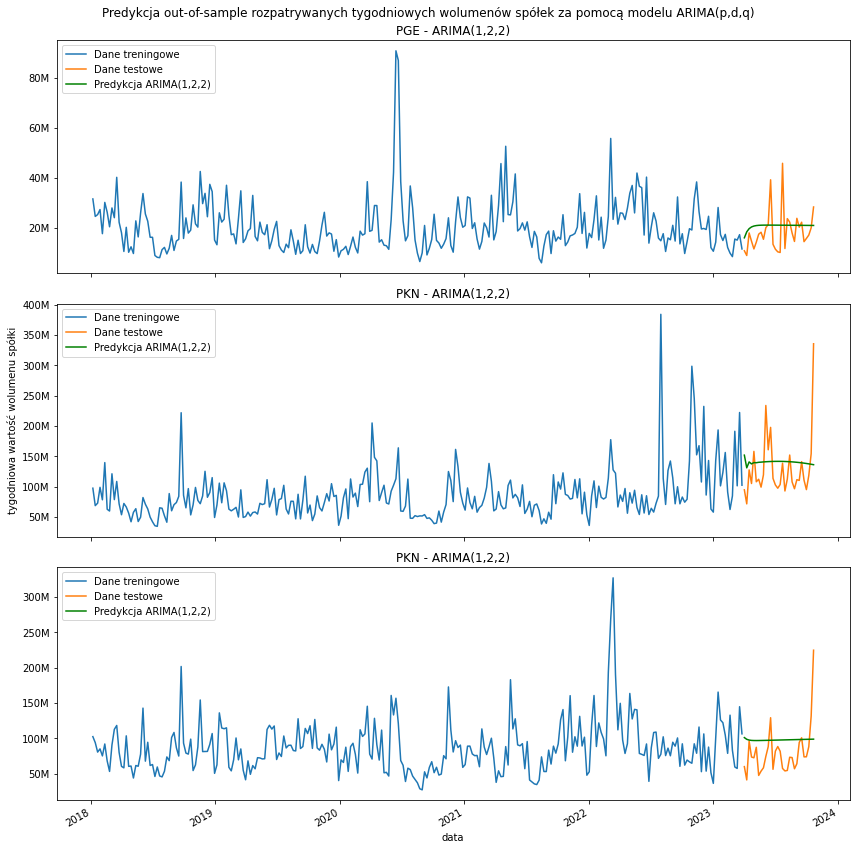

In [114]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,12))
ax1.plot(data_PGE_ARIMA_week, label="Dane treningowe")
ax1.plot(df_test_PGE_week, label="Dane testowe")
ax1.plot(PGE_pred_out_ARIMA_week, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(PKN_resample["daily_turnover"][:273], label="Dane treningowe")
ax2.plot(PKN_resample["daily_turnover"][273:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_ARIMA_week) + 100000000, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_ARIMA_week, label="Dane treningowe")
ax3.plot(df_test_PKO_week, label="Dane testowe")
ax3.plot(PKO_pred_out_ARIMA_week, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax3.title.set_text("PKN - ARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja out-of-sample rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)") 
plt.gcf().autofmt_xdate()
plt.savefig("26.pdf")

### Miary błędów predykcji

In [115]:
PGE_pred = PGE_pred_out_ARIMA_week
PGE_true = df_test_PGE_week

mape_PGE_ARIMA_week = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_ARIMA_week = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_ARIMA_week = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_ARIMA_week = np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_ARIMA_week = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [116]:
PKN_pred = np.cumsum(PKN_pred_out_ARIMA_week) + 100000000
PKN_true = PKN_resample["daily_turnover"][273:]

mape_PKN_ARIMA_week = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_ARIMA_week = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_ARIMA_week = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_ARIMA_week = np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_ARIMA_week = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [117]:
PKO_pred = PKO_pred_out_ARIMA_week
PKO_true = df_test_PKO_week

mape_PKO_ARIMA_week = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARIMA_week = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARIMA_week = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARIMA_week = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARIMA_week = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar dla szeregu ARIMA - dane tygodniowe

In [118]:
results_ARIMA_week = pd.DataFrame({'Method':['ARIMA_week - PGE', 'ARIMA_week - PKN', 'ARIMA_week - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_week, mape_PKN_ARIMA_week, mape_PKO_ARIMA_week],'MAE': [mae_PGE_ARIMA_week,mae_PKN_ARIMA_week, mae_PKO_ARIMA_week], 'MPE': [mpe_PGE_ARIMA_week, mpe_PKN_ARIMA_week, mpe_PKO_ARIMA_week], 'RMSE': [rmse_PGE_ARIMA_week, rmse_PKN_ARIMA_week, rmse_PKO_ARIMA_week], 'CORR': [corr_PGE_ARIMA_week,corr_PKN_ARIMA_week,corr_PKO_ARIMA_week]})
results_ARIMA_week

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARIMA_week - PGE  0.389156  6.143307e+06  0.281492  8.072089e+06  0.283356
1  ARIMA_week - PKN  0.303510  3.853773e+07  0.189211  5.206021e+07 -0.127931
2  ARIMA_week - PKO  0.438445  3.041992e+07  0.366484  3.820467e+07  0.172543

### model SARIMA - dane tygodniowe

In [119]:
data_PGE_SARIMA_week = df_train_PGE_week
data_PKN_SARIMA_week = df_train_PKN_week
data_PKO_SARIMA_week = df_train_PKO_week

df_PGE_SARIMA_week = pd.DataFrame()
df_PKN_SARIMA_week = pd.DataFrame()
df_PKO_SARIMA_week = pd.DataFrame()

ps_PGE_SARIMA_week = []
ps_PKN_SARIMA_week = []
ps_PKO_SARIMA_week = []
ds_PGE_SARIMA_week = []
ds_PKN_SARIMA_week = []
ds_PKO_SARIMA_week = []
qs_PGE_SARIMA_week = []
qs_PKN_SARIMA_week = []
qs_PKO_SARIMA_week = []
BIC_PGE_SARIMA_week = []
BIC_PKN_SARIMA_week = []
BIC_PKO_SARIMA_week = []
AIC_PGE_SARIMA_week = []
AIC_PKN_SARIMA_week = []
AIC_PKO_SARIMA_week = []
HQIC_PGE_SARIMA_week = []
HQIC_PKN_SARIMA_week = []
HQIC_PKO_SARIMA_week = []

max_p = 3
max_d = 3 
max_q = 3

for p in range(1, max_p):
    for d in range(1, max_d):
        for q in range(1, max_q):
            model_PGE_SARIMA_week = SARIMAX(data_PGE_SARIMA_week, order=(p, d, q))
            model_PKN_SARIMA_week = SARIMAX(data_PKN_SARIMA_week, order=(p, d, q))
            model_PKO_SARIMA_week = SARIMAX(data_PKO_SARIMA_week, order=(p, d, q))
            model_fit_PGE_SARIMA_week = model_PGE_SARIMA_week.fit()
            model_fit_PKN_SARIMA_week = model_PKN_SARIMA_week.fit()
            model_fit_PKO_SARIMA_week = model_PKO_SARIMA_week.fit()
            ps_PGE_SARIMA_week.append(p)
            ps_PKN_SARIMA_week.append(p)
            ps_PKO_SARIMA_week.append(p)
            ds_PGE_SARIMA_week.append(d)
            ds_PKN_SARIMA_week.append(d)
            ds_PKO_SARIMA_week.append(d)
            qs_PGE_SARIMA_week.append(q)
            qs_PKN_SARIMA_week.append(q)
            qs_PKO_SARIMA_week.append(q)
            AIC_PGE_SARIMA_week.append(model_fit_PGE_SARIMA_week.aic)
            AIC_PKN_SARIMA_week.append(model_fit_PKN_SARIMA_week.aic)
            AIC_PKO_SARIMA_week.append(model_fit_PKO_SARIMA_week.aic)
            BIC_PGE_SARIMA_week.append(model_fit_PGE_SARIMA_week.bic)
            BIC_PKN_SARIMA_week.append(model_fit_PKN_SARIMA_week.bic)
            BIC_PKO_SARIMA_week.append(model_fit_PKO_SARIMA_week.bic)
            HQIC_PGE_SARIMA_week.append(model_fit_PGE_SARIMA_week.hqic)
            HQIC_PKN_SARIMA_week.append(model_fit_PKN_SARIMA_week.hqic)
            HQIC_PKO_SARIMA_week.append(model_fit_PKO_SARIMA_week.hqic)
            

df_PGE_SARIMA_week['p']    = ps_PGE_SARIMA_week
df_PGE_SARIMA_week['d']    = ds_PGE_SARIMA_week
df_PGE_SARIMA_week['q']    = qs_PGE_SARIMA_week
df_PGE_SARIMA_week['AIC']  = AIC_PGE_SARIMA_week
df_PGE_SARIMA_week['BIC']  = BIC_PGE_SARIMA_week
df_PGE_SARIMA_week['HQIC'] = HQIC_PGE_SARIMA_week

df_PKN_SARIMA_week['p']    = ps_PKN_SARIMA_week
df_PKN_SARIMA_week['d']    = ds_PKN_SARIMA_week
df_PKN_SARIMA_week['q']    = qs_PKN_SARIMA_week
df_PKN_SARIMA_week['AIC']  = AIC_PKN_SARIMA_week
df_PKN_SARIMA_week['BIC']  = BIC_PKN_SARIMA_week
df_PKN_SARIMA_week['HQIC'] = HQIC_PKN_SARIMA_week

df_PKO_SARIMA_week['p']    = ps_PKO_SARIMA_week
df_PKO_SARIMA_week['d']    = ds_PKO_SARIMA_week
df_PKO_SARIMA_week['q']    = qs_PKO_SARIMA_week
df_PKO_SARIMA_week['AIC']  = AIC_PKO_SARIMA_week
df_PKO_SARIMA_week['BIC']  = BIC_PKO_SARIMA_week
df_PKO_SARIMA_week['HQIC'] = HQIC_PKO_SARIMA_week

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Prog

In [120]:
df_PGE_SARIMA_week.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  9484.509830  9498.918305  9490.294989
5  2  1  2  9491.114320  9509.143330  9498.352341
1  1  1  2  9492.738035  9507.161243  9498.528452
4  2  1  1  9492.770350  9507.193558  9498.560767
0  1  1  1  9492.848276  9503.665682  9497.191089

In [121]:
df_PGE_SARIMA_week.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  9484.509830  9498.918305  9490.294989
0  1  1  1  9492.848276  9503.665682  9497.191089
1  1  1  2  9492.738035  9507.161243  9498.528452
4  2  1  1  9492.770350  9507.193558  9498.560767
5  2  1  2  9491.114320  9509.143330  9498.352341

In [122]:
df_PGE_SARIMA_week.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  9484.509830  9498.918305  9490.294989
0  1  1  1  9492.848276  9503.665682  9497.191089
5  2  1  2  9491.114320  9509.143330  9498.352341
1  1  1  2  9492.738035  9507.161243  9498.528452
4  2  1  1  9492.770350  9507.193558  9498.560767

In [123]:
df_PKN_SARIMA_week.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
1  1  1  2  10302.054933  10316.478141  10307.845350
5  2  1  2  10337.404590  10355.433600  10344.642611
4  2  1  1  10339.213275  10353.636483  10345.003692
7  2  2  2  10344.911854  10362.922448  10352.143303
0  1  1  1  10350.058831  10360.876238  10354.401644

In [124]:
df_PKN_SARIMA_week.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
1  1  1  2  10302.054933  10316.478141  10307.845350
4  2  1  1  10339.213275  10353.636483  10345.003692
5  2  1  2  10337.404590  10355.433600  10344.642611
0  1  1  1  10350.058831  10360.876238  10354.401644
7  2  2  2  10344.911854  10362.922448  10352.143303

In [125]:
df_PKN_SARIMA_week.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
1  1  1  2  10302.054933  10316.478141  10307.845350
5  2  1  2  10337.404590  10355.433600  10344.642611
4  2  1  1  10339.213275  10353.636483  10345.003692
7  2  2  2  10344.911854  10362.922448  10352.143303
0  1  1  1  10350.058831  10360.876238  10354.401644

In [126]:
df_PKO_SARIMA_week.sort_values(by='AIC').head()

p  d  q           AIC           BIC          HQIC
3  1  2  2  10176.193228  10190.601704  10181.978387
0  1  1  1  10180.248903  10191.066310  10184.591716
1  1  1  2  10180.467974  10194.891182  10186.258391
4  2  1  1  10180.471263  10194.894471  10186.261680
5  2  1  2  10180.722212  10198.751223  10187.960234

In [127]:
df_PKO_SARIMA_week.sort_values(by='BIC').head()

p  d  q           AIC           BIC          HQIC
3  1  2  2  10176.193228  10190.601704  10181.978387
0  1  1  1  10180.248903  10191.066310  10184.591716
1  1  1  2  10180.467974  10194.891182  10186.258391
4  2  1  1  10180.471263  10194.894471  10186.261680
5  2  1  2  10180.722212  10198.751223  10187.960234

In [128]:
df_PKO_SARIMA_week.sort_values(by='HQIC').head()

p  d  q           AIC           BIC          HQIC
3  1  2  2  10176.193228  10190.601704  10181.978387
0  1  1  1  10180.248903  10191.066310  10184.591716
1  1  1  2  10180.467974  10194.891182  10186.258391
4  2  1  1  10180.471263  10194.894471  10186.261680
5  2  1  2  10180.722212  10198.751223  10187.960234

In [129]:
p1, d1, q1 = 1,2,2

model_PGE_SARIMA_week = SARIMAX(data_PGE_SARIMA_week, order=(p1,d1,q1), seasonal_order=(p1,d1,q1,18))
model_PKN_SARIMA_week = SARIMAX(data_PKN_SARIMA_week, order=(p1,d1,q1), seasonal_order=(p1,d1,q1,18))
model_PKO_SARIMA_week = SARIMAX(data_PKO_SARIMA_week, order=(p1,d1,q1), seasonal_order=(p1,d1,q1,18))
result_PGE_SARIMA_week = model_PGE_SARIMA_week.fit()
result_PKN_SARIMA_week = model_PKN_SARIMA_week.fit()
result_PKO_SARIMA_week = model_PKO_SARIMA_week.fit()
print(result_PKO_SARIMA_week.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                     daily_turnover   No. Observations:                  273
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 18)   Log Likelihood               -4560.663
Date:                            Sun, 04 Feb 2024   AIC                           9135.327
Time:                                    11:34:50   BIC                           9159.544
Sample:                                01-07-2018   HQIC                          9145.090
                                     - 03-26-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3968      0.408      0.973      0.331      -0.402       1.196
ma.L1         -1.8483      0.221   

In [130]:
predicted_result_PGE_SARIMA_week = result_PGE_SARIMA_week.predict(start=0, end=len(df_train_PGE_week))
predicted_result_PKN_SARIMA_week = result_PKN_SARIMA_week.predict(start=0, end=len(df_train_PKN_week))
predicted_result_PKO_SARIMA_week = result_PKO_SARIMA_week.predict(start=0, end=len(df_train_PKO_week))

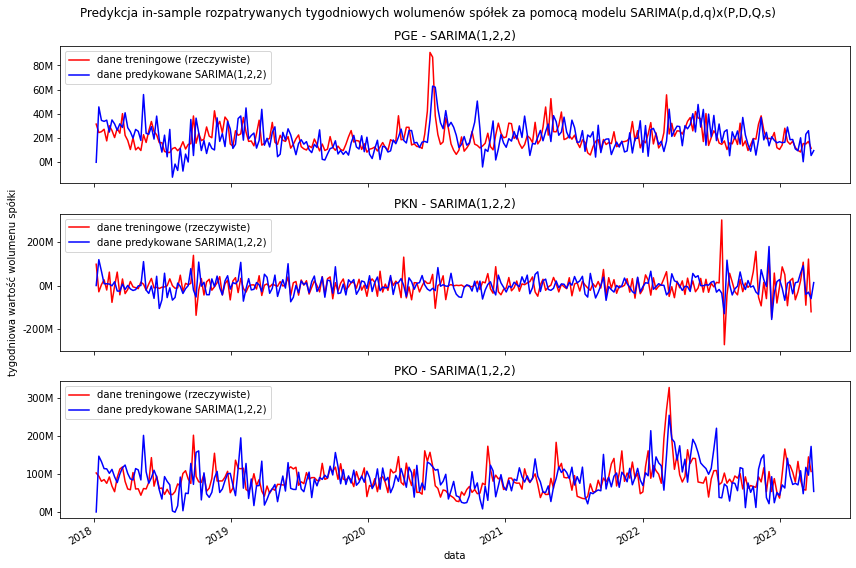

In [131]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA_week, color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_SARIMA_week, color='blue', label="dane predykowane SARIMA(1,2,2)")
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_SARIMA_week, color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_SARIMA_week, color='blue', label="dane predykowane SARIMA(1,2,2)")
ax2.title.set_text("PKN - SARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_SARIMA_week, color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_SARIMA_week, color='blue', label="dane predykowane SARIMA(1,2,2)")
ax3.title.set_text("PKO - SARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja in-sample rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)")   
plt.gcf().autofmt_xdate()
plt.savefig("27.pdf")

### Forecasting dla modelu SARIMA(p, d, q) - 1 rok do przodu 

In [132]:
#PGE
forecast_test_PGE_SARIMA_week = result_PGE_SARIMA_week.get_forecast(len(df_test_PGE_week.index))
PGE_pred_df_SARIMA_week = forecast_test_PGE_SARIMA_week.conf_int(alpha = 0.05) 
PGE_pred_df_SARIMA_week["Predictions"] = result_PGE_SARIMA_week.predict(start = PGE_pred_df_SARIMA_week.index[0], end = PGE_pred_df_SARIMA_week.index[-1])
PGE_pred_df_SARIMA_week.index = df_test_PGE_week.index
PGE_pred_out_SARIMA_week = PGE_pred_df_SARIMA_week["Predictions"] 

#PKN
forecast_test_PKN_SARIMA_week = result_PKN_SARIMA_week.get_forecast(len(df_test_PKN_week.index))
PKN_pred_df_SARIMA_week = forecast_test_PKN_SARIMA_week.conf_int(alpha = 0.05) 
PKN_pred_df_SARIMA_week["Predictions"] = result_PKN_SARIMA_week.predict(start = PKN_pred_df_SARIMA_week.index[0], end = PKN_pred_df_SARIMA_week.index[-1])
PKN_pred_df_SARIMA_week.index = df_test_PKN_week.index
PKN_pred_out_SARIMA_week = PKN_pred_df_SARIMA_week["Predictions"] 

#PKO
forecast_test_PKO_SARIMA_week = result_PKO_SARIMA_week.get_forecast(len(df_test_PKO_week.index))
PKO_pred_df_SARIMA_week = forecast_test_PKO_SARIMA_week.conf_int(alpha = 0.05) 
PKO_pred_df_SARIMA_week["Predictions"] = result_PKO_SARIMA_week.predict(start = PKO_pred_df_SARIMA_week.index[0], end = PKO_pred_df_SARIMA_week.index[-1])
PKO_pred_df_SARIMA_week.index = df_test_PKO_week.index
PKO_pred_out_SARIMA_week = PKO_pred_df_SARIMA_week["Predictions"] 

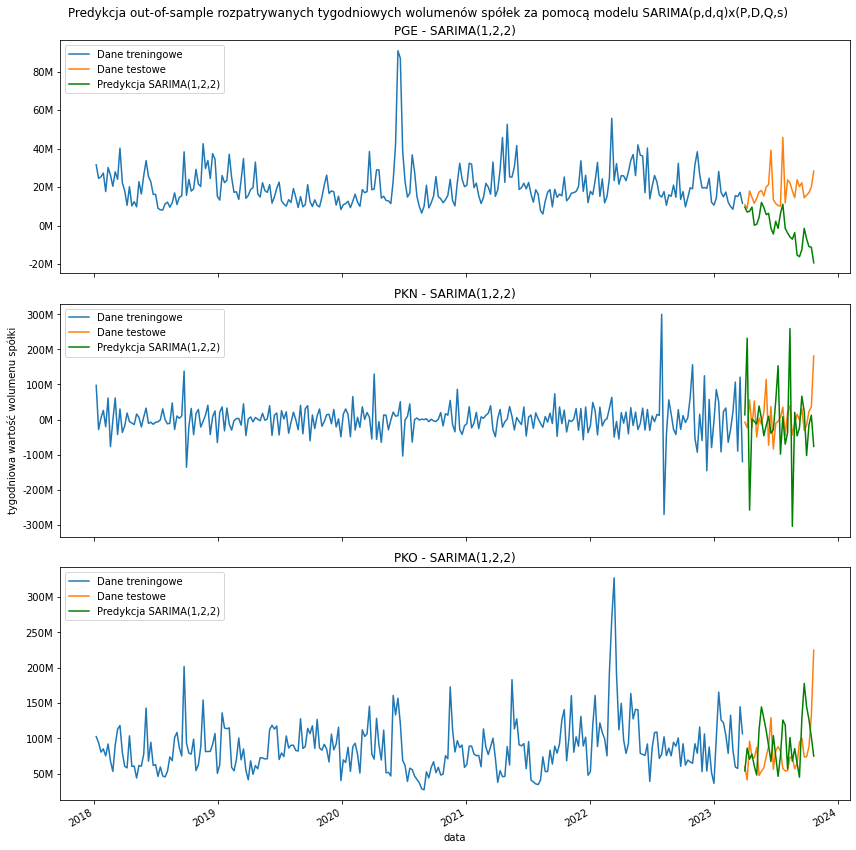

In [133]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,12))
ax1.plot(data_PGE_SARIMA_week, label="Dane treningowe")
ax1.plot(df_test_PGE_week, label="Dane testowe")
ax1.plot(PGE_pred_out_SARIMA_week, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_SARIMA_week, label="Dane treningowe")
ax2.plot(df_test_PKN_week, label="Dane testowe")
ax2.plot(PKN_pred_out_SARIMA_week, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax2.title.set_text("PKN - SARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_SARIMA_week, label="Dane treningowe")
ax3.plot(df_test_PKO_week, label="Dane testowe")
ax3.plot(PKO_pred_out_SARIMA_week, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax3.title.set_text("PKO - SARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja out-of-sample rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)") 
plt.gcf().autofmt_xdate()

plt.savefig("28.pdf")

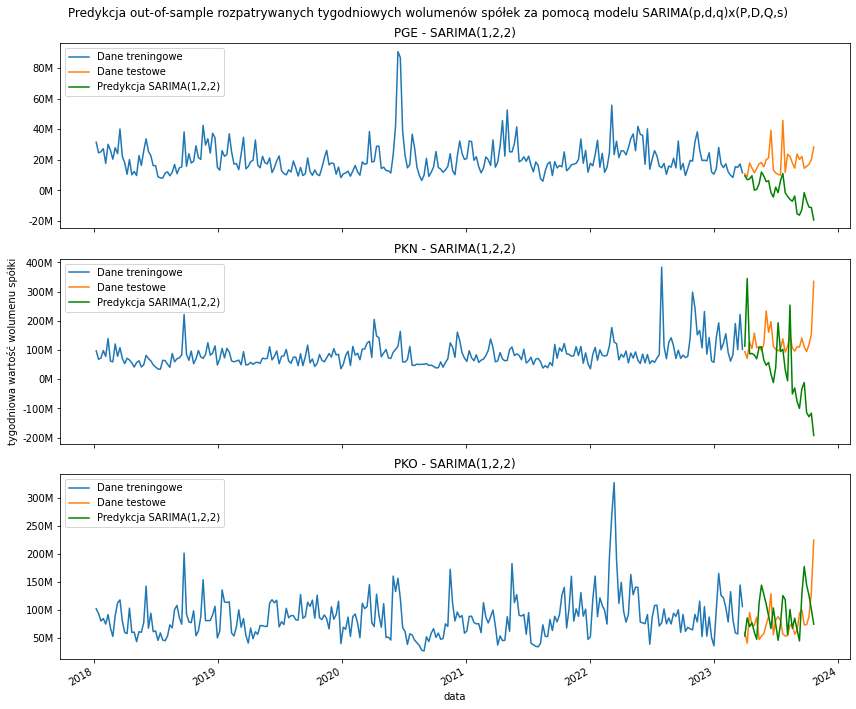

In [134]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,10))
ax1.plot(data_PGE_SARIMA_week, label="Dane treningowe")
ax1.plot(df_test_PGE_week, label="Dane testowe")
ax1.plot(PGE_pred_out_SARIMA_week, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(PKN_resample["daily_turnover"][:273], label="Dane treningowe")
ax2.plot(PKN_resample["daily_turnover"][273:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_SARIMA_week) + 100000000, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax2.title.set_text("PKN - SARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_SARIMA_week, label="Dane treningowe")
ax3.plot(df_test_PKO_week, label="Dane testowe")
ax3.plot(PKO_pred_out_SARIMA_week, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax3.title.set_text("PKO - SARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja out-of-sample rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)") 
plt.gcf().autofmt_xdate()
plt.savefig("29.pdf")

### miary błędów predykcji

In [135]:
PGE_pred = PGE_pred_out_SARIMA_week
PGE_true = df_test_PGE_week

mape_PGE_SARIMA_week = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_SARIMA_week = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_SARIMA_week = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_SARIMA_week= np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_SARIMA_week = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [136]:
PKN_pred = np.cumsum(PKN_pred_out_SARIMA_week) + 100000000
PKN_true = PKN_resample["daily_turnover"][273:]

mape_PKN_SARIMA_week = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_SARIMA_week = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_SARIMA_week = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_SARIMA_week= np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_SARIMA_week = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [137]:
PKO_pred = PKO_pred_out_SARIMA_week
PKO_true = df_test_PKO_week

mape_PKO_SARIMA_week = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_SARIMA_week = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_SARIMA_week = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_SARIMA_week= np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_SARIMA_week = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar dla szeregu SARIMA - dane tygodniowe

In [138]:
results_SARIMA_week = pd.DataFrame({'Method':['SARIMA_week - PGE', 'SARIMA_week - PKN', 'SARIMA_week - PKO'], 
                        'MAPE': [mape_PGE_SARIMA_week, mape_PKN_SARIMA_week, mape_PKO_SARIMA_week],'MAE': [mae_PGE_SARIMA_week,mae_PKN_SARIMA_week, mae_PKO_SARIMA_week], 'MPE': [mpe_PGE_SARIMA_week, mpe_PKN_SARIMA_week, mpe_PKO_SARIMA_week], 'RMSE': [rmse_PGE_SARIMA_week, rmse_PKN_SARIMA_week, rmse_PGE_SARIMA_week], 'CORR': [corr_PGE_SARIMA_week,corr_PKN_SARIMA_week,corr_PKO_SARIMA_week]})
results_SARIMA_week

Method      MAPE           MAE       MPE          RMSE      CORR
0  SARIMA_week - PGE  1.004571  1.947009e+07 -1.004571  2.315141e+07 -0.143348
1  SARIMA_week - PKN  0.999360  1.279126e+08 -0.611379  1.677124e+08 -0.346992
2  SARIMA_week - PKO  0.558039  4.094470e+07  0.318312  2.315141e+07 -0.194143

### Podsumowanie miar  dla obu modeli ARMA I SARIMA - dane tygodniowe 

In [139]:
results_all_week = pd.DataFrame({'Method':['ARIMA - PGE','ARIMA - PKN' , 'ARIMA - PKO', 'SARIMA - PGE', 'SARIMA - PKN', 'SARIMA - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_week, mape_PKN_ARIMA_week, mape_PKO_ARIMA_week, mape_PGE_SARIMA_week, mape_PKN_SARIMA_week, mape_PKO_SARIMA_week], 'MAE': [mae_PGE_ARIMA_week, mae_PKN_ARIMA_week, mae_PKO_ARIMA_week ,mape_PGE_SARIMA_week, mape_PKN_SARIMA_week, mape_PKO_SARIMA_week], 'MPE': [mpe_PGE_ARIMA_week, mpe_PKN_ARIMA_week, mpe_PKO_ARIMA_week, mpe_PGE_SARIMA_week, mpe_PKN_SARIMA_week, mpe_PKO_SARIMA_week], 'RMSE': [rmse_PGE_ARIMA_week, rmse_PKN_ARIMA_week, rmse_PKO_ARIMA_week, rmse_PGE_SARIMA_week, rmse_PKN_SARIMA_week, rmse_PKO_SARIMA_week], 'CORR': [corr_PGE_ARIMA_week, corr_PKN_ARIMA_week, corr_PKO_ARIMA_week, corr_PGE_SARIMA_week, corr_PKN_SARIMA_week, corr_PKO_SARIMA_week]})
results_all_week

Method      MAPE           MAE       MPE          RMSE      CORR
0   ARIMA - PGE  0.389156  6.143307e+06  0.281492  8.072089e+06  0.283356
1   ARIMA - PKN  0.303510  3.853773e+07  0.189211  5.206021e+07 -0.127931
2   ARIMA - PKO  0.438445  3.041992e+07  0.366484  3.820467e+07  0.172543
3  SARIMA - PGE  1.004571  1.004571e+00 -1.004571  2.315141e+07 -0.143348
4  SARIMA - PKN  0.999360  9.993604e-01 -0.611379  1.677124e+08 -0.346992
5  SARIMA - PKO  0.558039  5.580388e-01  0.318312  5.336267e+07 -0.194143

## Dane dwutygodniowe 

In [140]:
PGE_resample_w2 = PGE.resample('2W-SUN').mean()
PKN_resample_w2 = PKN.resample('2W-SUN').mean()
PKO_resample_w2 = PKO.resample('2W-SUN').mean()
print(PGE_resample_w2)

            daily_turnover
date                      
2018-01-07    3.155500e+07
2018-01-21    2.493153e+07
2018-02-04    2.249427e+07
2018-02-18    2.821100e+07
2018-03-04    2.419035e+07
...                    ...
2023-08-27    1.606908e+07
2023-09-10    2.204543e+07
2023-09-24    1.836831e+07
2023-10-08    1.643474e+07
2023-10-22    2.418464e+07

[152 rows x 1 columns]


### Sprawdzanie stacjonarności danych - dane dwutygodniowe

In [141]:
PGE_test_resample_w2 = adfuller(PGE_resample_w2["daily_turnover"])
PKN_test_resample_w2 = adfuller(PKN_resample_w2["daily_turnover"])
PKO_test_resample_w2 = adfuller(PKO_resample_w2["daily_turnover"])

PGE_test_resample1_w2 = kpss(PGE_resample_w2["daily_turnover"])
PKN_test_resample1_w2 = kpss(PKN_resample_w2["daily_turnover"])
PKO_test_resample1_w2 = kpss(PKO_resample_w2["daily_turnover"])

print("PGE: p-value z testu Augmented Dickey-Fuller'a", PGE_test_resample_w2[1]) # stacjonarne
print("PKN: p-value z testu Augmented Dickey-Fuller'a", PKN_test_resample_w2[1]) # niestacjonarne
print("PKO: p-value z testu Augmented Dickey-Fuller'a", PKO_test_resample_w2[1]) # stacjonarne

print("PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PGE_test_resample1_w2[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKN_test_resample1_w2[1]) # niestacjonarne
print("PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", PKO_test_resample1_w2[1]) # stacjonarne

PGE: p-value z testu Augmented Dickey-Fuller'a 8.668944265543532e-13
PKN: p-value z testu Augmented Dickey-Fuller'a 0.4829082579113375
PKO: p-value z testu Augmented Dickey-Fuller'a 1.0182180648126413e-12
PGE: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.01
PKO: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Tworzenie danych stacjonarnych

In [142]:
diff_weekly2 = np.diff(PKN_resample_w2["daily_turnover"])
diff_weekly2_0 = np.insert(diff_weekly2, 0, PKN_resample_w2["daily_turnover"].iloc[0])
PKN_resample_w2['diff_weekly'] = diff_weekly2_0

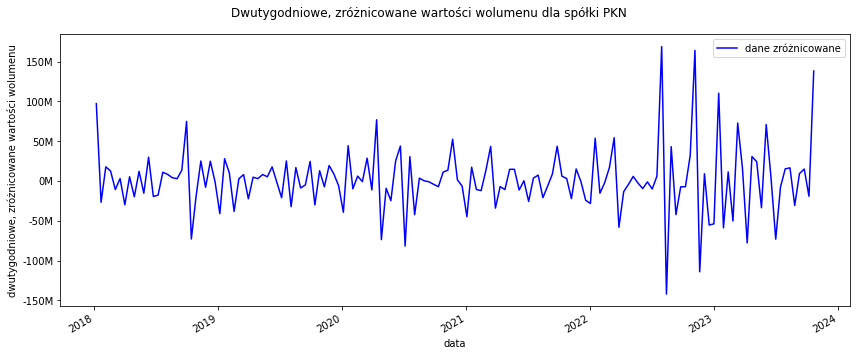

In [143]:
fig, (ax2) = plt.subplots(1,1, tight_layout=True, figsize=(12,5))
ax2.plot(PKN_resample_w2['diff_weekly'], color="blue", label="dane zróżnicowane")
ax2.set_ylabel("dwutygodniowe, zróżnicowane wartości wolumenu")
ax2.set_xlabel("data")
fig.suptitle("Dwutygodniowe, zróżnicowane wartości wolumenu dla spółki PKN")
plt.gcf().autofmt_xdate()
ax2.yaxis.set_major_formatter(formatter)
ax2.legend()
plt.savefig('12.pdf')

### Sprawdzanie stacjonarności zlogarytmizowanych danych - dane dwutygodniowe

In [144]:
returns_PKN_test_resample_w2 = adfuller(PKN_resample_w2['diff_weekly'])
returns_PKN_test1_resample_w2 = kpss(PKN_resample_w2['diff_weekly'])

print("PKN: p-value z testu Augmented Dickey-Fuller'a", returns_PKN_test_resample_w2[1]) # stacjonarne
print("PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a", returns_PKN_test1_resample_w2[1]) # stacjonarne

PKN: p-value z testu Augmented Dickey-Fuller'a 4.224174267352557e-06
PKN: p-value z testu Kwiatkowski-Phillips-Schmidt-Shin'a 0.1


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


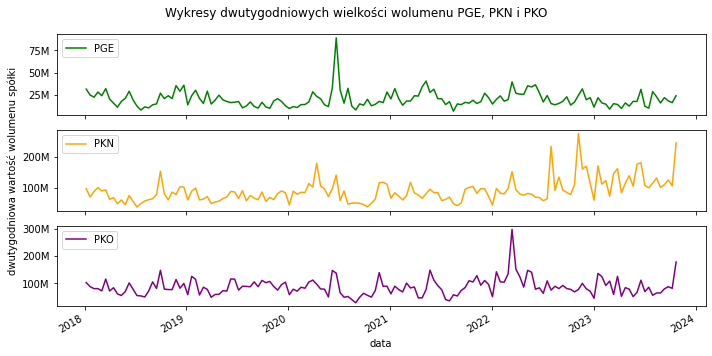

In [145]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(10,5))
ax1.plot(PGE_resample_w2["daily_turnover"], color="green", label="PGE")
ax2.plot(PKN_resample_w2["daily_turnover"], color="orange", label="PKN")
ax3.plot(PKO_resample_w2["daily_turnover"], color="purple", label="PKO")
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Wykresy dwutygodniowych wielkości wolumenu PGE, PKN i PKO")
plt.gcf().autofmt_xdate()
plt.savefig("7.pdf")

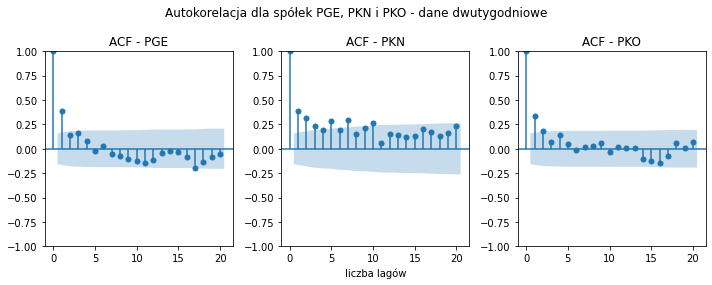

In [146]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
plot_acf(PGE_resample_w2["daily_turnover"], lags=20, ax=ax1)
plot_acf(PKN_resample_w2["daily_turnover"], lags=20, ax=ax2)
plot_acf(PKO_resample_w2["daily_turnover"], lags=20, ax=ax3)
ax1.set_title("ACF - PGE")
ax2.set_title("ACF - PKN")
ax3.set_title("ACF - PKO")
ax2.set_xlabel("liczba lagów")
fig.suptitle("Autokorelacja dla spółek PGE, PKN i PKO - dane dwutygodniowe")
plt.savefig("8.pdf")

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


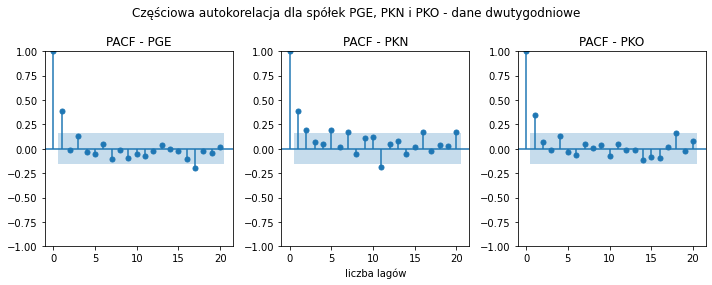

In [147]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
plot_pacf(PGE_resample_w2["daily_turnover"], lags=20, ax=ax1)
plot_pacf(PKN_resample_w2["daily_turnover"], lags=20, ax=ax2)
plot_pacf(PKO_resample_w2["daily_turnover"], lags=20, ax=ax3)
ax1.set_title("PACF - PGE")
ax2.set_title("PACF - PKN")
ax3.set_title("PACF - PKO")
ax2.set_xlabel("liczba lagów")
fig.suptitle("Częściowa autokorelacja dla spółek PGE, PKN i PKO - dane dwutygodniowe")
plt.savefig("9.pdf")

### Dane treningowe i testowe dla danych dwutygodniowych 

In [148]:
df_train_PGE_week2 = PGE_resample_w2["daily_turnover"][:137]
df_test_PGE_week2 = PGE_resample_w2["daily_turnover"][137:]

df_train_PKN_week2 = PKN_resample_w2['diff_weekly'][:137]
df_test_PKN_week2 = PKN_resample_w2['diff_weekly'][137:]

df_train_PKO_week2 = PKO_resample_w2["daily_turnover"][:137]
df_test_PKO_week2 = PKO_resample_w2["daily_turnover"][137:]

### model ARIMA - dane dwutygodniowe 

In [149]:
data_PGE_ARIMA_week2 = df_train_PGE_week2
data_PKN_ARIMA_week2 = df_train_PKN_week2
data_PKO_ARIMA_week2 = df_train_PKO_week2

df_PGE_ARIMA_week2 = pd.DataFrame()
df_PKN_ARIMA_week2 = pd.DataFrame()
df_PKO_ARIMA_week2 = pd.DataFrame()

ps_PGE_ARIMA_week2 = []
ps_PKN_ARIMA_week2 = []
ps_PKO_ARIMA_week2 = []
ds_PGE_ARIMA_week2 = []
ds_PKN_ARIMA_week2 = []
ds_PKO_ARIMA_week2 = []
qs_PGE_ARIMA_week2 = []
qs_PKN_ARIMA_week2 = []
qs_PKO_ARIMA_week2 = []
BIC_PGE_ARIMA_week2 = []
BIC_PKN_ARIMA_week2 = []
BIC_PKO_ARIMA_week2 = []
AIC_PGE_ARIMA_week2 = []
AIC_PKN_ARIMA_week2 = []
AIC_PKO_ARIMA_week2 = []
HQIC_PGE_ARIMA_week2 = []
HQIC_PGE_ARIMA_week2 = []
HQIC_PKN_ARIMA_week2 = []
HQIC_PKO_ARIMA_week2 = []

max_p = 3
max_d = 3 
max_q = 3

for p in range(1, max_p):
    for d in range(1, max_d):
        for q in range(1, max_q):
            model_PGE_ARIMA_week2 = ARIMA(data_PGE_ARIMA_week2, order=(p, d, q))
            model_PKN_ARIMA_week2 = ARIMA(data_PKN_ARIMA_week2, order=(p, d, q))
            model_PKO_ARIMA_week2 = ARIMA(data_PKN_ARIMA_week2, order=(p, d, q))
            model_fit_PGE_ARIMA_week2 = model_PGE_ARIMA_week2.fit()
            model_fit_PKN_ARIMA_week2 = model_PKN_ARIMA_week2.fit()
            model_fit_PKO_ARIMA_week2 = model_PKO_ARIMA_week2.fit()
            ps_PGE_ARIMA_week2.append(p)
            ps_PKN_ARIMA_week2.append(p)
            ps_PKO_ARIMA_week2.append(p)
            ds_PGE_ARIMA_week2.append(d)
            ds_PKN_ARIMA_week2.append(d)
            ds_PKO_ARIMA_week2.append(d)
            qs_PGE_ARIMA_week2.append(q)
            qs_PKN_ARIMA_week2.append(q)
            qs_PKO_ARIMA_week2.append(q)
            AIC_PGE_ARIMA_week2.append(model_fit_PGE_ARIMA_week2.aic)
            AIC_PKN_ARIMA_week2.append(model_fit_PKN_ARIMA_week2.aic)
            AIC_PKO_ARIMA_week2.append(model_fit_PKO_ARIMA_week2.aic)
            BIC_PGE_ARIMA_week2.append(model_fit_PGE_ARIMA_week2.bic)
            BIC_PKN_ARIMA_week2.append(model_fit_PKN_ARIMA_week2.bic)
            BIC_PKO_ARIMA_week2.append(model_fit_PKO_ARIMA_week2.bic)
            HQIC_PGE_ARIMA_week2.append(model_fit_PGE_ARIMA_week2.hqic)
            HQIC_PKN_ARIMA_week2.append(model_fit_PKN_ARIMA_week2.hqic)
            HQIC_PKO_ARIMA_week2.append(model_fit_PKO_ARIMA_week2.hqic)

df_PGE_ARIMA_week2['p']    = ps_PGE_ARIMA_week2
df_PGE_ARIMA_week2['d']    = ds_PGE_ARIMA_week2
df_PGE_ARIMA_week2['q']    = qs_PGE_ARIMA_week2
df_PGE_ARIMA_week2['AIC']  = AIC_PGE_ARIMA_week2
df_PGE_ARIMA_week2['BIC']  = BIC_PGE_ARIMA_week2
df_PGE_ARIMA_week2['HQIC'] = HQIC_PGE_ARIMA_week2

df_PKN_ARIMA_week2['p']    = ps_PKN_ARIMA_week2
df_PKN_ARIMA_week2['d']    = ds_PKN_ARIMA_week2
df_PKN_ARIMA_week2['q']    = qs_PKN_ARIMA_week2
df_PKN_ARIMA_week2['AIC']  = AIC_PKN_ARIMA_week2
df_PKN_ARIMA_week2['BIC']  = BIC_PKN_ARIMA_week2
df_PKN_ARIMA_week2['HQIC'] = HQIC_PKN_ARIMA_week2

df_PKO_ARIMA_week2['p']    = ps_PKO_ARIMA_week2
df_PKO_ARIMA_week2['d']    = ds_PKO_ARIMA_week2
df_PKO_ARIMA_week2['q']    = qs_PKO_ARIMA_week2
df_PKO_ARIMA_week2['AIC']  = AIC_PKO_ARIMA_week2
df_PKO_ARIMA_week2['BIC']  = BIC_PKO_ARIMA_week2
df_PKO_ARIMA_week2['HQIC'] = HQIC_PKO_ARIMA_week2

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\P

In [150]:
df_PGE_ARIMA_week2.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
7  2  2  2  4728.523987  4743.050361  4734.427098
0  1  1  1  4738.425921  4747.163886  4741.976808
6  2  2  1  4739.116831  4750.737930  4743.839320
1  1  1  2  4739.443357  4751.093976  4744.177873
4  2  1  1  4739.881830  4751.532449  4744.616346

In [151]:
df_PGE_ARIMA_week2.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
7  2  2  2  4728.523987  4743.050361  4734.427098
0  1  1  1  4738.425921  4747.163886  4741.976808
6  2  2  1  4739.116831  4750.737930  4743.839320
1  1  1  2  4739.443357  4751.093976  4744.177873
4  2  1  1  4739.881830  4751.532449  4744.616346

In [152]:
df_PGE_ARIMA_week2.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
7  2  2  2  4728.523987  4743.050361  4734.427098
0  1  1  1  4738.425921  4747.163886  4741.976808
6  2  2  1  4739.116831  4750.737930  4743.839320
1  1  1  2  4739.443357  4751.093976  4744.177873
4  2  1  1  4739.881830  4751.532449  4744.616346

In [153]:
df_PKN_ARIMA_week2.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [154]:
df_PKN_ARIMA_week2.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [155]:
df_PKN_ARIMA_week2.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [156]:
df_PKO_ARIMA_week2.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [157]:
df_PKO_ARIMA_week2.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [158]:
df_PKO_ARIMA_week2.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [159]:
p1, d1, q1 = 1,2,2

model_PGE_ARIMA_week2 = ARIMA(data_PGE_ARIMA_week2, order=(p1,d1,q1))
model_PKN_ARIMA_week2 = ARIMA(data_PKN_ARIMA_week2, order=(p1,d1,q1))
model_PKO_ARIMA_week2 = ARIMA(data_PKO_ARIMA_week2, order=(p1,d1,q1))
result_PGE_ARIMA_week2 = model_PGE_ARIMA_week2.fit()
result_PKN_ARIMA_week2 = model_PKN_ARIMA_week2.fit()
result_PKO_ARIMA_week2 = model_PKO_ARIMA_week2.fit()
print(result_PGE_ARIMA_week2.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         daily_turnover   No. Observations:                  137
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -2372.991
Date:                Sun, 04 Feb 2024   AIC                           4753.981
Time:                        11:35:08   BIC                           4765.602
Sample:                    01-07-2018   HQIC                          4758.704
                         - 03-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9208      0.292     -3.152      0.002      -1.493      -0.348
ma.L1         -0.1056      0.286     -0.369      0.712      -0.666       0.455
ma.L2         -0.8883      0.337     -2.637      0.0

In [160]:
predicted_result_PGE_ARIMA_week2 = result_PGE_ARIMA_week2.predict(start=0, end=len(df_train_PGE_week2))
predicted_result_PKN_ARIMA_week2 = result_PKN_ARIMA_week2.predict(start=0, end=len(df_train_PKN_week2))
predicted_result_PKO_ARIMA_week2 = result_PKO_ARIMA_week2.predict(start=0, end=len(df_train_PKO_week2))

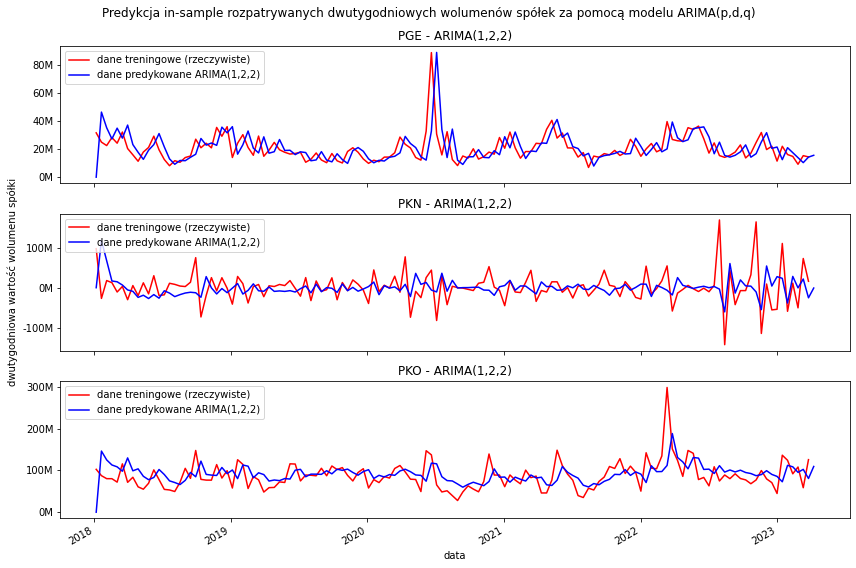

In [161]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA_week2, color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_ARIMA_week2, color='blue', label="dane predykowane ARIMA(1,2,2)")
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_ARIMA_week2, color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_ARIMA_week2, color='blue', label="dane predykowane ARIMA(1,2,2)")
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_ARIMA_week2, color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_ARIMA_week2, color='blue', label="dane predykowane ARIMA(1,2,2)")
ax3.title.set_text("PKO - ARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlabel("data")
fig.suptitle("Predykcja in-sample rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("30.pdf")

### Forecasting dla modelu ARIMA(p, d, q) - 1 rok do przodu

In [162]:
# PGE
forecast_test_PGE_ARIMA_week2 = result_PGE_ARIMA_week2.get_forecast(len(df_test_PGE_week2.index))
PGE_pred_df_ARIMA_week2 = forecast_test_PGE_ARIMA_week2.conf_int(alpha = 0.05) 
PGE_pred_df_ARIMA_week2["Predictions"] = result_PGE_ARIMA_week2.predict(start = PGE_pred_df_ARIMA_week2.index[0], end = PGE_pred_df_ARIMA_week2.index[-1])
PGE_pred_df_ARIMA_week2.index = df_test_PGE_week2.index
PGE_pred_out_ARIMA_week2 = PGE_pred_df_ARIMA_week2["Predictions"] 

# PKN
forecast_test_PKN_ARIMA_week2 = result_PKN_ARIMA_week2.get_forecast(len(df_test_PKN_week2.index))
PKN_pred_df_ARIMA_week2 = forecast_test_PKN_ARIMA_week2.conf_int(alpha = 0.05) 
PKN_pred_df_ARIMA_week2["Predictions"] = result_PKN_ARIMA_week2.predict(start = PKN_pred_df_ARIMA_week2.index[0], end = PKN_pred_df_ARIMA_week2.index[-1])
PKN_pred_df_ARIMA_week2.index = df_test_PKN_week2.index
PKN_pred_out_ARIMA_week2 = PKN_pred_df_ARIMA_week2["Predictions"] 

# PKO
forecast_test_PKO_ARIMA_week2 = result_PKO_ARIMA_week2.get_forecast(len(df_test_PKO_week2.index))
PKO_pred_df_ARIMA_week2 = forecast_test_PKO_ARIMA_week2.conf_int(alpha = 0.05) 
PKO_pred_df_ARIMA_week2["Predictions"] = result_PKO_ARIMA_week2.predict(start = PKO_pred_df_ARIMA_week2.index[0], end = PKO_pred_df_ARIMA_week2.index[-1])
PKO_pred_df_ARIMA_week2.index = df_test_PKO_week2.index
PKO_pred_out_ARIMA_week2 = PKO_pred_df_ARIMA_week2["Predictions"] 

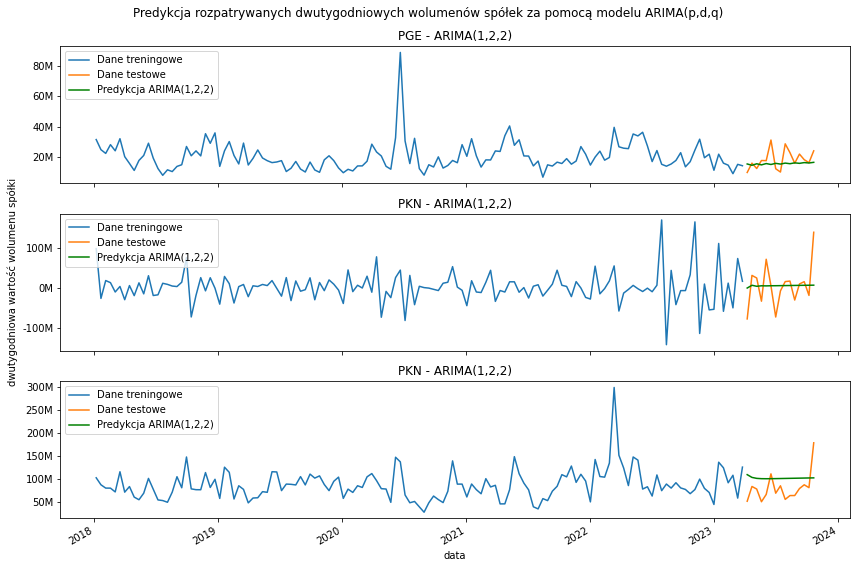

In [163]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA_week2, label="Dane treningowe")
ax1.plot(df_test_PGE_week2, label="Dane testowe")
ax1.plot(PGE_pred_out_ARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_ARIMA_week2, label="Dane treningowe")
ax2.plot(df_test_PKN_week2, label="Dane testowe")
ax2.plot(PKN_pred_out_ARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_ARIMA_week2, label="Dane treningowe")
ax3.plot(df_test_PKO_week2, label="Dane testowe")
ax3.plot(PKO_pred_out_ARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax3.title.set_text("PKN - ARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlabel("data")

fig.suptitle("Predykcja rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)") 
plt.gcf().autofmt_xdate()
plt.savefig("31.pdf")

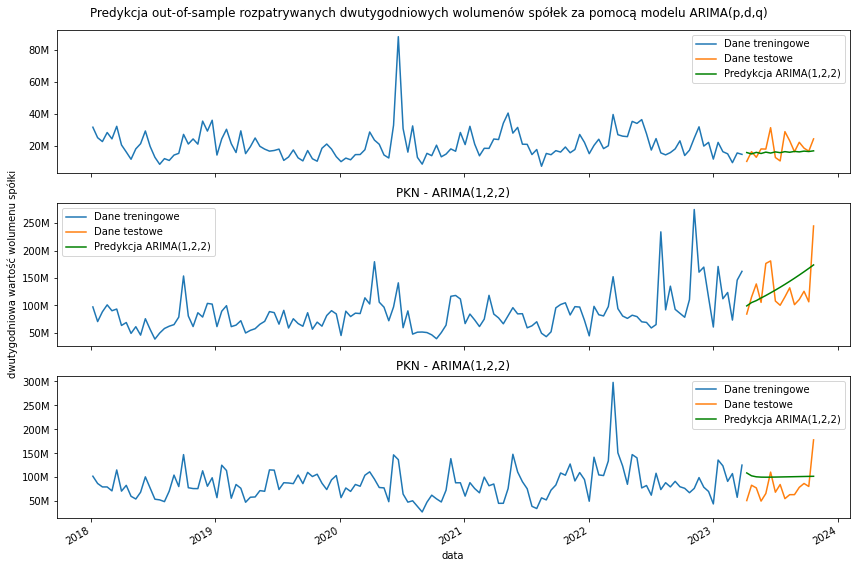

In [164]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_ARIMA_week2, label="Dane treningowe")
ax1.plot(df_test_PGE_week2, label="Dane testowe")
ax1.plot(PGE_pred_out_ARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax2.title.set_text("PGE - ARIMA(1,2,2)")
ax1.legend()
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(PKN_resample_w2["daily_turnover"][:137], label="Dane treningowe")
ax2.plot(PKN_resample_w2["daily_turnover"][137:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_ARIMA_week2) + 100000000, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.legend()
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_ARIMA_week2, label="Dane treningowe")
ax3.plot(df_test_PKO_week2, label="Dane testowe")
ax3.plot(PKO_pred_out_ARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax3.title.set_text("PKN - ARIMA(1,2,2)")
ax3.set_xlabel("data")
ax3.legend()
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja out-of-sample rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)") 
plt.gcf().autofmt_xdate()
plt.savefig("32.pdf")

### Miary błędów predykcji - ARIMA

In [165]:
PGE_pred = PGE_pred_out_ARIMA_week2
PGE_true = df_test_PGE_week2

mape_PGE_ARIMA_week2 = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_ARIMA_week2 = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_ARIMA_week2 = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_ARIMA_week2= np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_ARIMA_week2 = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [166]:
PKN_pred = np.cumsum(PKN_pred_out_ARIMA_week2) + 100000000
PKN_true = PKN_resample_w2["daily_turnover"][137:]

mape_PKN_ARIMA_week2 = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_ARIMA_week2 = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_ARIMA_week2 = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_ARIMA_week2= np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_ARIMA_week2 = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [167]:
PKO_pred = PKO_pred_out_ARIMA_week2
PKO_true = df_test_PKO_week2

mape_PKO_ARIMA_week2 = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARIMA_week2 = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARIMA_week2 = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARIMA_week2= np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARIMA_week2 = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar dla szeregu ARIMA - dane dwutygodniowe

In [168]:
results_ARIMA_week2 = pd.DataFrame({'Method':['ARIMA_week2 - PGE', 'ARIMA_week2 - PKN', 'ARIMA_week2 - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_week2, mape_PKN_ARIMA_week2, mape_PKO_ARIMA_week2],'MAE': [mae_PGE_ARIMA_week2,mae_PKN_ARIMA_week2, mae_PKO_ARIMA_week2], 'MPE': [mpe_PGE_ARIMA_week2, mpe_PKN_ARIMA_week2, mpe_PKO_ARIMA_week2], 'RMSE': [rmse_PGE_ARIMA_week2, rmse_PKN_ARIMA_week2, rmse_PKO_ARIMA_week2], 'CORR': [corr_PGE_ARIMA_week2,corr_PKN_ARIMA_week2,corr_PKO_ARIMA_week2]})
results_ARIMA_week2

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARIMA_week2 - PGE  0.262533  5.033091e+06 -0.047719  6.635052e+06  0.134069
1  ARIMA_week2 - PKN  0.268605  3.516590e+07  0.102620  4.048069e+07  0.285654
2  ARIMA_week2 - PKO  0.466552  3.309317e+07  0.397147  3.744531e+07 -0.105650

### model SARIMA - dane dwutygodniowe 

In [169]:
data_PGE_SARIMA_week2 = df_train_PGE_week2
data_PKN_SARIMA_week2 = df_train_PKN_week2
data_PKO_SARIMA_week2 = df_train_PKO_week2

df_PGE_SARIMA_week2 = pd.DataFrame()
df_PKN_SARIMA_week2 = pd.DataFrame()
df_PKO_SARIMA_week2 = pd.DataFrame()

ps_PGE_SARIMA_week2 = []
ps_PKN_SARIMA_week2 = []
ps_PKO_SARIMA_week2 = []
ds_PGE_SARIMA_week2 = []
ds_PKN_SARIMA_week2 = []
ds_PKO_SARIMA_week2 = []
qs_PGE_SARIMA_week2 = []
qs_PKN_SARIMA_week2 = []
qs_PKO_SARIMA_week2 = []
BIC_PGE_SARIMA_week2 = []
BIC_PKN_SARIMA_week2 = []
BIC_PKO_SARIMA_week2 = []
AIC_PGE_SARIMA_week2 = []
AIC_PKN_SARIMA_week2 = []
AIC_PKO_SARIMA_week2 = []
HQIC_PGE_SARIMA_week2 = []
HQIC_PKN_SARIMA_week2 = []
HQIC_PKO_SARIMA_week2 = []

max_p = 3
max_d = 3 
max_q = 3

for p in range(1, max_p):
    for d in range(1, max_d):
        for q in range(1, max_q):
            model_PGE_SARIMA_week2 = SARIMAX(data_PGE_SARIMA_week2, order=(p, d, q))
            model_PKN_SARIMA_week2 = SARIMAX(data_PKN_SARIMA_week2, order=(p, d, q))
            model_PKO_SARIMA_week2 = SARIMAX(data_PKO_SARIMA_week2, order=(p, d, q))
            model_fit_PGE_SARIMA_week2 = model_PGE_SARIMA_week2.fit()
            model_fit_PKN_SARIMA_week2 = model_PKN_SARIMA_week2.fit()
            model_fit_PKO_SARIMA_week2 = model_PKO_SARIMA_week2.fit()
            ps_PGE_SARIMA_week2.append(p)
            ps_PKN_SARIMA_week2.append(p)
            ps_PKO_SARIMA_week2.append(p)
            ds_PGE_SARIMA_week2.append(d)
            ds_PKN_SARIMA_week2.append(d)
            ds_PKO_SARIMA_week2.append(d)
            qs_PGE_SARIMA_week2.append(q)
            qs_PKN_SARIMA_week2.append(q)
            qs_PKO_SARIMA_week2.append(q)
            AIC_PGE_SARIMA_week2.append(model_fit_PGE_SARIMA_week2.aic)
            AIC_PKN_SARIMA_week2.append(model_fit_PKN_SARIMA_week2.aic)
            AIC_PKO_SARIMA_week2.append(model_fit_PKO_SARIMA_week2.aic)
            BIC_PGE_SARIMA_week2.append(model_fit_PGE_SARIMA_week2.bic)
            BIC_PKN_SARIMA_week2.append(model_fit_PKN_SARIMA_week2.bic)
            BIC_PKO_SARIMA_week2.append(model_fit_PKO_SARIMA_week2.bic)
            HQIC_PGE_SARIMA_week2.append(model_fit_PGE_SARIMA_week2.hqic)
            HQIC_PKN_SARIMA_week2.append(model_fit_PKN_SARIMA_week2.hqic)
            HQIC_PKO_SARIMA_week2.append(model_fit_PKO_SARIMA_week2.hqic)



df_PGE_SARIMA_week2['p']    = ps_PGE_SARIMA_week2
df_PGE_SARIMA_week2['d']    = ds_PGE_SARIMA_week2
df_PGE_SARIMA_week2['q']    = qs_PGE_SARIMA_week2
df_PGE_SARIMA_week2['AIC']  = AIC_PGE_SARIMA_week2
df_PGE_SARIMA_week2['BIC']  = BIC_PGE_SARIMA_week2
df_PGE_SARIMA_week2['HQIC'] = HQIC_PGE_SARIMA_week2

df_PKN_SARIMA_week2['p']    = ps_PKN_SARIMA_week2
df_PKN_SARIMA_week2['d']    = ds_PKN_SARIMA_week2
df_PKN_SARIMA_week2['q']    = qs_PKN_SARIMA_week2
df_PKN_SARIMA_week2['AIC']  = AIC_PKN_SARIMA_week2
df_PKN_SARIMA_week2['BIC']  = BIC_PKN_SARIMA_week2
df_PKN_SARIMA_week2['HQIC'] = HQIC_PKN_SARIMA_week2

df_PKO_SARIMA_week2['p']    = ps_PKO_SARIMA_week2
df_PKO_SARIMA_week2['d']    = ds_PKO_SARIMA_week2
df_PKO_SARIMA_week2['q']    = qs_PKO_SARIMA_week2
df_PKO_SARIMA_week2['AIC']  = AIC_PKO_SARIMA_week2
df_PKO_SARIMA_week2['BIC']  = BIC_PKO_SARIMA_week2
df_PKO_SARIMA_week2['HQIC'] = HQIC_PKO_SARIMA_week2

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\P

In [170]:
df_PGE_SARIMA_week2.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
7  2  2  2  4728.523987  4743.050361  4734.427098
0  1  1  1  4738.425921  4747.163886  4741.976808
6  2  2  1  4739.116831  4750.737930  4743.839320
1  1  1  2  4739.443357  4751.093976  4744.177873
4  2  1  1  4739.881830  4751.532449  4744.616346

In [171]:
df_PGE_SARIMA_week2.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
7  2  2  2  4728.523987  4743.050361  4734.427098
0  1  1  1  4738.425921  4747.163886  4741.976808
6  2  2  1  4739.116831  4750.737930  4743.839320
1  1  1  2  4739.443357  4751.093976  4744.177873
4  2  1  1  4739.881830  4751.532449  4744.616346

In [172]:
df_PGE_SARIMA_week2.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
7  2  2  2  4728.523987  4743.050361  4734.427098
0  1  1  1  4738.425921  4747.163886  4741.976808
6  2  2  1  4739.116831  4750.737930  4743.839320
1  1  1  2  4739.443357  4751.093976  4744.177873
4  2  1  1  4739.881830  4751.532449  4744.616346

In [173]:
df_PKN_SARIMA_week2.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [174]:
df_PKN_SARIMA_week2.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [175]:
df_PKN_SARIMA_week2.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
1  1  1  2  5114.192352  5125.842972  5118.926868
7  2  2  2  5117.487714  5132.014088  5123.390825
5  2  1  2  5128.261565  5142.824839  5134.179710
0  1  1  1  5135.708630  5144.446594  5139.259517
4  2  1  1  5135.809128  5147.459747  5140.543644

In [176]:
df_PKO_SARIMA_week2.sort_values(by='AIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  5069.524509  5081.145608  5074.246998
0  1  1  1  5082.530372  5091.268337  5086.081259
4  2  1  1  5084.033998  5095.684617  5088.768514
1  1  1  2  5084.690988  5096.341608  5089.425504
6  2  2  1  5084.883884  5096.504983  5089.606372

In [177]:
df_PKO_SARIMA_week2.sort_values(by='BIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  5069.524509  5081.145608  5074.246998
0  1  1  1  5082.530372  5091.268337  5086.081259
4  2  1  1  5084.033998  5095.684617  5088.768514
1  1  1  2  5084.690988  5096.341608  5089.425504
6  2  2  1  5084.883884  5096.504983  5089.606372

In [178]:
df_PKO_SARIMA_week2.sort_values(by='HQIC').head()

p  d  q          AIC          BIC         HQIC
3  1  2  2  5069.524509  5081.145608  5074.246998
0  1  1  1  5082.530372  5091.268337  5086.081259
4  2  1  1  5084.033998  5095.684617  5088.768514
1  1  1  2  5084.690988  5096.341608  5089.425504
6  2  2  1  5084.883884  5096.504983  5089.606372

In [179]:
p1, d1, q1 = 1,2,2

model_PGE_SARIMA_week2 = SARIMAX(data_PGE_SARIMA_week2, order=(p1,d1,q1), seasonal_order=(p1,d1,q1,12)) # 8 i 9 stestowac
model_PKN_SARIMA_week2 = SARIMAX(data_PKN_SARIMA_week2, order=(p1,d1,q1), seasonal_order=(p1,d1,q1,12)) # 8 i 9 stestowac
model_PKO_SARIMA_week2 = SARIMAX(data_PKO_SARIMA_week2, order=(p1,d1,q1), seasonal_order=(p1,d1,q1,12)) # 8 i 9 stestowac
result_PGE_SARIMA_week2 = model_PGE_SARIMA_week2.fit()
result_PKN_SARIMA_week2 = model_PKN_SARIMA_week2.fit()
result_PKO_SARIMA_week2 = model_PKO_SARIMA_week2.fit()
print(result_PGE_SARIMA_week2.summary())

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                     daily_turnover   No. Observations:                  137
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -2016.647
Date:                            Sun, 04 Feb 2024   AIC                           4047.295
Time:                                    11:35:38   BIC                           4066.261
Sample:                                01-07-2018   HQIC                          4054.989
                                     - 03-26-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3281      0.547      0.600      0.548      -0.744       1.400
ma.L1         -1.8184      0.359   

In [180]:
predicted_result_PGE_SARIMA_week2 = result_PGE_SARIMA_week2.predict(start=0, end=len(df_train_PGE_week2))
predicted_result_PKN_SARIMA_week2 = result_PKN_SARIMA_week2.predict(start=0, end=len(df_train_PKN_week2))
predicted_result_PKO_SARIMA_week2 = result_PKO_SARIMA_week2.predict(start=0, end=len(df_train_PKO_week2))

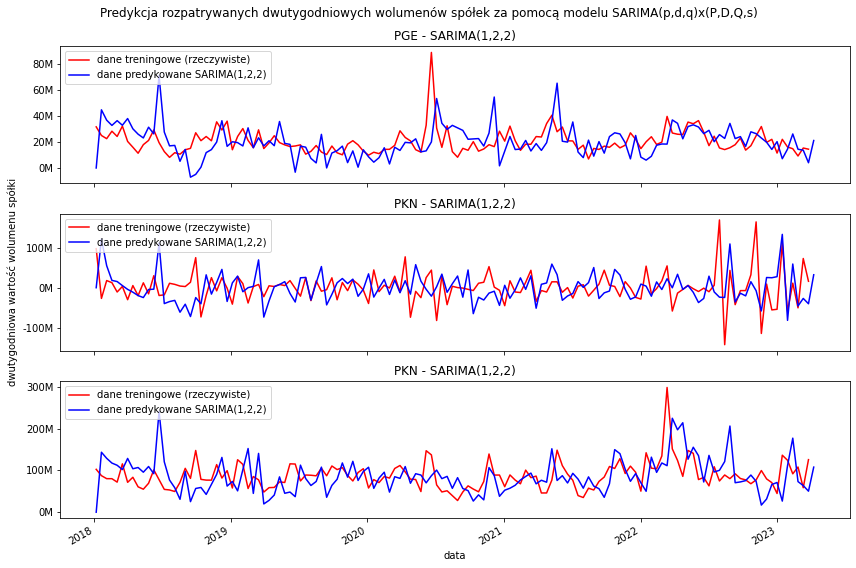

In [181]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA_week2, color='red', label="dane treningowe (rzeczywiste)")
ax1.plot(predicted_result_PGE_SARIMA_week2, color='blue', label="dane predykowane SARIMA(1,2,2)")
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_SARIMA_week2, color='red', label="dane treningowe (rzeczywiste)")
ax2.plot(predicted_result_PKN_SARIMA_week2, color='blue', label="dane predykowane SARIMA(1,2,2)")
ax2.title.set_text("PKN - SARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_SARIMA_week2, color='red', label="dane treningowe (rzeczywiste)")
ax3.plot(predicted_result_PKO_SARIMA_week2, color='blue', label="dane predykowane SARIMA(1,2,2)")
ax3.title.set_text("PKN - SARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("data")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)")   
plt.gcf().autofmt_xdate()
plt.savefig("33.pdf")

### Forecasting dla modelu SARIMA(p, d, q) - 1 rok do przodu

In [182]:
# PGE
forecast_test_PGE_SARIMA_week2 = result_PGE_SARIMA_week2.get_forecast(len(df_test_PGE_week2.index))
PGE_pred_df_SARIMA_week2 = forecast_test_PGE_SARIMA_week2.conf_int(alpha = 0.05) 
PGE_pred_df_SARIMA_week2["Predictions"] = result_PGE_SARIMA_week2.predict(start = PGE_pred_df_SARIMA_week2.index[0], end = PGE_pred_df_SARIMA_week2.index[-1])
PGE_pred_df_SARIMA_week2.index = df_test_PGE_week2.index
PGE_pred_out_SARIMA_week2 = PGE_pred_df_SARIMA_week2["Predictions"] 

# PKN
forecast_test_PKN_SARIMA_week2 = result_PKN_SARIMA_week2.get_forecast(len(df_test_PKN_week2.index))
PKN_pred_df_SARIMA_week2 = forecast_test_PKN_SARIMA_week2.conf_int(alpha = 0.05) 
PKN_pred_df_SARIMA_week2["Predictions"] = result_PKN_SARIMA_week2.predict(start = PKN_pred_df_SARIMA_week2.index[0], end = PKN_pred_df_SARIMA_week2.index[-1])
PKN_pred_df_SARIMA_week2.index = df_test_PKN_week2.index
PKN_pred_out_SARIMA_week2 = PKN_pred_df_SARIMA_week2["Predictions"] 

# PKO
forecast_test_PKO_SARIMA_week2 = result_PKO_SARIMA_week2.get_forecast(len(df_test_PKO_week2.index))
PKO_pred_df_SARIMA_week2 = forecast_test_PKO_SARIMA_week2.conf_int(alpha = 0.05) 
PKO_pred_df_SARIMA_week2["Predictions"] = result_PKO_SARIMA_week2.predict(start = PKO_pred_df_SARIMA_week2.index[0], end = PKO_pred_df_SARIMA_week2.index[-1])
PKO_pred_df_SARIMA_week2.index = df_test_PKO_week2.index
PKO_pred_out_SARIMA_week2 = PKO_pred_df_SARIMA_week2["Predictions"] 

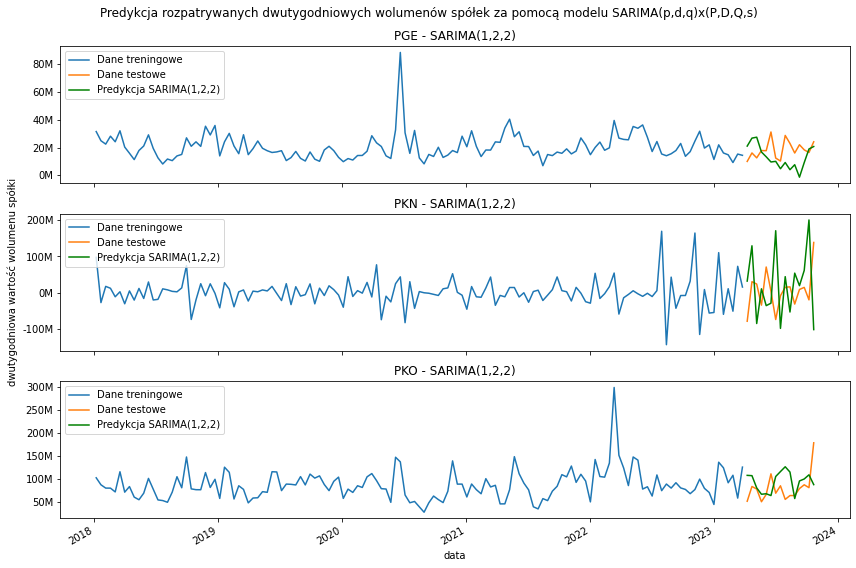

In [183]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA_week2, label="Dane treningowe")
ax1.plot(df_test_PGE_week2, label="Dane testowe")
ax1.plot(PGE_pred_out_SARIMA_week2, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - SARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(data_PKN_SARIMA_week2, label="Dane treningowe")
ax2.plot(df_test_PKN_week2, label="Dane testowe")
ax2.plot(PKN_pred_out_SARIMA_week2, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax2.title.set_text("PKN - SARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_SARIMA_week2, label="Dane treningowe")
ax3.plot(df_test_PKO_week2, label="Dane testowe")
ax3.plot(PKO_pred_out_SARIMA_week2, color='green', label = 'Predykcja SARIMA(1,2,2)')
ax3.title.set_text("PKO - SARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlabel("data")
fig.suptitle("Predykcja rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)") 
plt.gcf().autofmt_xdate()
plt.savefig("34.pdf")

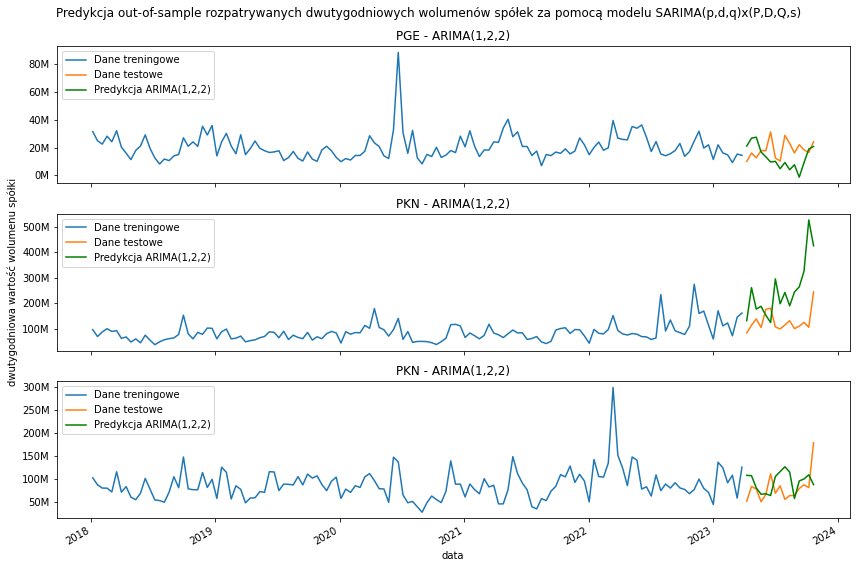

In [184]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, tight_layout=True, figsize=(12,8))
ax1.plot(data_PGE_SARIMA_week2, label="Dane treningowe")
ax1.plot(df_test_PGE_week2, label="Dane testowe")
ax1.plot(PGE_pred_out_SARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.plot(PKN_resample_w2["daily_turnover"][:137], label="Dane treningowe")
ax2.plot(PKN_resample_w2["daily_turnover"][137:], label="Dane testowe")
ax2.plot(np.cumsum(PKN_pred_out_SARIMA_week2) + 100000000, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax2.yaxis.set_major_formatter(formatter)
ax3.plot(data_PKO_SARIMA_week2, label="Dane treningowe")
ax3.plot(df_test_PKO_week2, label="Dane testowe")
ax3.plot(PKO_pred_out_SARIMA_week2, color='green', label = 'Predykcja ARIMA(1,2,2)')
ax3.title.set_text("PKN - ARIMA(1,2,2)")
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlabel("data")
fig.suptitle("Predykcja out-of-sample rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu SARIMA(p,d,q)x(P,D,Q,s)") 
plt.gcf().autofmt_xdate()
plt.savefig("35.pdf")

### Miary błędów predykcji - SARIMA

In [185]:
PGE_pred = PGE_pred_out_SARIMA_week2
PGE_true = df_test_PGE_week2

mape_PGE_SARIMA_week2 = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_SARIMA_week2 = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_SARIMA_week2 = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_SARIMA_week2= np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_SARIMA_week2 = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [186]:
PKN_pred = np.cumsum(PKN_pred_out_SARIMA_week2) + 100000000
PKN_true = PKN_resample_w2["daily_turnover"][137:]

mape_PKN_SARIMA_week2 = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_SARIMA_week2 = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_SARIMA_week2 = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_SARIMA_week2= np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_SARIMA_week2 = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [187]:
PKO_pred = PKO_pred_out_SARIMA_week2
PKO_true = df_test_PKO_week2

mape_PKO_SARIMA_week2 = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_SARIMA_week2 = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_SARIMA_week2 = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_SARIMA_week2= np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_SARIMA_week2 = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

### Zebranie wszystkich miar szeregu SARIMA - dane dwutygodniowe 

In [188]:
results_SARIMA_week2 = pd.DataFrame({'Method':['SARIMA_week2 - PGE', 'SARIMA_week2 - PKN', 'SARIMA_week2 - PKO'], 
                        'MAPE': [mape_PGE_SARIMA_week2, mape_PKN_SARIMA_week2, mape_PKO_SARIMA_week2],'MAE': [mae_PGE_SARIMA_week2,mae_PKN_SARIMA_week2, mae_PKO_SARIMA_week2], 'MPE': [mpe_PGE_SARIMA_week2, mpe_PKN_SARIMA_week2, mape_PKO_SARIMA_week2], 'RMSE': [rmse_PGE_SARIMA_week2, rmse_PKN_SARIMA_week2, rmse_PGE_SARIMA_week2], 'CORR': [corr_PGE_SARIMA_week2,corr_PKN_SARIMA_week2,corr_PKO_SARIMA_week2]})
results_SARIMA_week2

Method      MAPE           MAE       MPE          RMSE  \
0  SARIMA_week2 - PGE  0.571461  1.047914e+07 -0.156664  1.277476e+07   
1  SARIMA_week2 - PKN  1.109624  1.307378e+08  1.051091  1.616916e+08   
2  SARIMA_week2 - PKO  0.427631  3.261241e+07  0.427631  1.277476e+07   

       CORR  
0 -0.308144  
1  0.138831  
2 -0.126766

### Podsumowanie miar błędów predykcji dla danych dwutygodniowych - model ARIMA i SARIMA

In [189]:
results_all_week2 = pd.DataFrame({'Method':['ARIMA - PGE','ARIMA - PKN' , 'ARIMA - PKO', 'SARIMA - PGE', 'SARIMA - PKN', 'SARIMA - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_week2, mape_PKN_ARIMA_week2, mape_PKO_ARIMA_week2, mape_PGE_SARIMA_week2, mape_PKN_SARIMA_week2, mape_PKO_SARIMA_week2], 'MAE': [mae_PGE_ARIMA_week2, mae_PKN_ARIMA_week2, mae_PKO_ARIMA_week2 ,mape_PGE_SARIMA_week2, mape_PKN_SARIMA_week2, mape_PKO_SARIMA_week2], 'MPE': [mpe_PGE_ARIMA_week2, mpe_PKN_ARIMA_week2, mpe_PKO_ARIMA_week2, mpe_PGE_SARIMA_week2, mpe_PKN_SARIMA_week2, mpe_PKO_SARIMA_week2], 'RMSE': [rmse_PGE_ARIMA_week2, rmse_PKN_ARIMA_week2, rmse_PKO_ARIMA_week2, rmse_PGE_SARIMA_week2, rmse_PKN_SARIMA_week2, rmse_PKO_SARIMA_week2], 'CORR': [corr_PGE_ARIMA_week2, corr_PKN_ARIMA_week2, corr_PKO_ARIMA_week2, corr_PGE_SARIMA_week2, corr_PKN_SARIMA_week2, corr_PKO_SARIMA_week2]})
results_all_week2

Method      MAPE           MAE       MPE          RMSE      CORR
0   ARIMA - PGE  0.262533  5.033091e+06 -0.047719  6.635052e+06  0.134069
1   ARIMA - PKN  0.268605  3.516590e+07  0.102620  4.048069e+07  0.285654
2   ARIMA - PKO  0.466552  3.309317e+07  0.397147  3.744531e+07 -0.105650
3  SARIMA - PGE  0.571461  5.714614e-01 -0.156664  1.277476e+07 -0.308144
4  SARIMA - PKN  1.109624  1.109624e+00  1.051091  1.616916e+08  0.138831
5  SARIMA - PKO  0.427631  4.276308e-01  0.289846  4.120997e+07 -0.126766

## Predykcja one-step-ahead

### ARMA - dane dzienne 

In [190]:
forecast_values_ARMA_PGE = []
forecast_values_ARMA_PKN = []
forecast_values_ARMA_PKO = []
forecast_steps_ARMA_PGE = len(df_test_PGE)
p1, q1 = 2, 1
p2, q2 = 2, 2

for i in range(forecast_steps_ARMA_PGE):

    # Predict the next value
    forecast_ARMA_PGE = result_PGE_ARMA.forecast(steps=1)
    forecast_values_ARMA_PGE.append(forecast_ARMA_PGE.values[0])

    forecast_ARMA_PKN = result_PKN_ARMA.forecast(steps=1)
    forecast_ARMA_PKN_daily_real = np.cumsum(forecast_ARMA_PKN) + 10000000
    forecast_values_ARMA_PKN.append(forecast_ARMA_PKN_daily_real.values[0])

    forecast_ARMA_PKO = result_PKO_ARMA.forecast(steps=1)
    forecast_values_ARMA_PKO.append(forecast_ARMA_PKO.values[0])
    
    # Update the model with the actual observed value
    actual_value_ARMA_PGE = df_test_PGE.iloc[i]
    actual_value_ARMA_PKN = PKN["daily_turnover"][1307:].iloc[i]
    actual_value_ARMA_PKO = df_test_PKO.iloc[i]

    # Update the last observation in the training set with the actual value

    df_train_PGE.iloc[-1] = actual_value_ARMA_PGE
    PKN["daily_turnover"][:1307].iloc[-1] = actual_value_ARMA_PKN
    df_train_PKO.iloc[-1] = actual_value_ARMA_PKO
    
    # Update the model with the extended training set
    model_PGE_ARMA = ARIMA(df_train_PGE, order=(p1,0,q1))
    model_PKN_ARMA = ARIMA(PKN["daily_turnover"][:1307], order=(p2,0,q2))
    model_PKO_ARMA = ARIMA(df_train_PKO, order=(p1,0,q1))
    result_PGE_ARMA = model_PGE_ARMA.fit()
    result_PKN_ARMA = model_PKN_ARMA.fit()
    result_PKO_ARMA = model_PKO_ARMA.fit()


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, fr

c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, fr

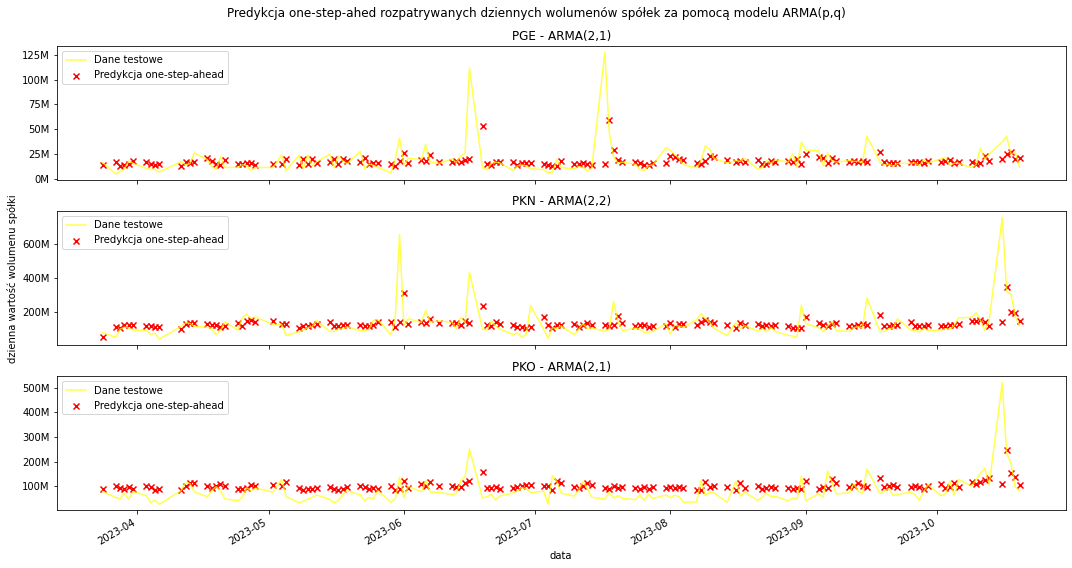

In [191]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(15,8))
ax1.scatter(np.array(df_test_PGE.index), forecast_values_ARMA_PGE, color='red', marker='x', label='Predykcja one-step-ahead')
ax1.plot(df_test_PGE, label="Dane testowe", color="yellow", alpha=0.7)
ax2.scatter(np.array(df_test_PGE.index), forecast_values_ARMA_PKN, color='red', marker='x', label='Predykcja one-step-ahead')
ax2.plot(PKN["daily_turnover"][1307:], label="Dane testowe", color="yellow", alpha=0.7)
ax3.scatter(np.array(df_test_PKO.index), forecast_values_ARMA_PKO, color='red', marker='x', label='Predykcja one-step-ahead')
ax3.plot(df_test_PKO, label="Dane testowe", color="yellow", alpha=0.7)
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARMA(2,1)")
ax2.title.set_text("PKN - ARMA(2,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARMA(2,1)")
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja one-step-ahed rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARMA(p,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("36.pdf")

### ARIMA - dzienne

In [192]:
forecast_values_ARIMA_PGE = []
forecast_values_ARIMA_PKN = []
forecast_values_ARIMA_PKO = []
forecast_steps_ARIMA_PGE = len(df_test_PGE)
p1, d1, q1 = 1,1,1
p2, d2, q2 = 1,1,2
p3, d3, q3 = 2,1,2

for i in range(forecast_steps_ARIMA_PGE):

    # Predict the next value
    forecast_ARIMA_PGE = result_PGE_ARIMA.forecast(steps=1)
    forecast_values_ARIMA_PGE.append(forecast_ARIMA_PGE.values[0])

    forecast_ARIMA_PKN = result_PKN_ARIMA.forecast(steps=1)
    forecast_ARIMA_PKN_daily_real = np.cumsum(forecast_ARIMA_PKN) + 10000000
    forecast_values_ARIMA_PKN.append(forecast_ARIMA_PKN_daily_real.values[0])

    forecast_ARIMA_PKO = result_PKO_ARIMA.forecast(steps=1)
    forecast_values_ARIMA_PKO.append(forecast_ARIMA_PKO.values[0])
    
    # Update the model with the actual observed value
    actual_value_ARIMA_PGE = df_test_PGE.iloc[i]
    actual_value_ARIMA_PKN = PKN["daily_turnover"][1307:].iloc[i]
    actual_value_ARIMA_PKO = df_test_PKO.iloc[i]

    # Update the last observation in the training set with the actual value

    df_train_PGE.iloc[-1] = actual_value_ARIMA_PGE
    PKN["daily_turnover"][:1307].iloc[-1] = actual_value_ARIMA_PKN
    df_train_PKO.iloc[-1] = actual_value_ARIMA_PKO
    
    # Update the model with the extended training set
    model_PGE_ARIMA = ARIMA(df_train_PGE, order=(p1,d1,q1))
    model_PKN_ARIMA = ARIMA(PKN["daily_turnover"][:1307], order=(p2,d2,q2))
    model_PKO_ARIMA = ARIMA(df_train_PKO, order=(p3,d3,q3))
    result_PGE_ARIMA = model_PGE_ARIMA.fit()
    result_PKN_ARIMA = model_PKN_ARIMA.fit()
    result_PKO_ARIMA = model_PKO_ARIMA.fit()


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, fr

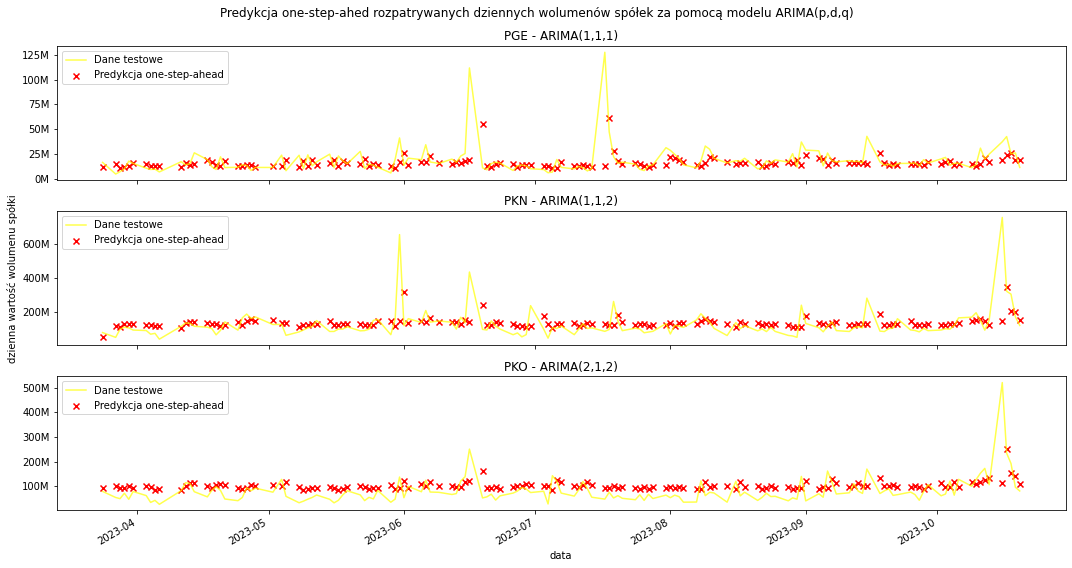

In [193]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(15,8))
ax1.scatter(np.array(df_test_PGE.index), forecast_values_ARIMA_PGE, color='red', marker='x', label='Predykcja one-step-ahead')
ax1.plot(df_test_PGE, label="Dane testowe", color="yellow", alpha=0.7)
ax2.scatter(np.array(df_test_PGE.index), forecast_values_ARIMA_PKN, color='red', marker='x', label='Predykcja one-step-ahead')
ax2.plot(PKN["daily_turnover"][1307:], label="Dane testowe", color="yellow", alpha=0.7)
ax3.scatter(np.array(df_test_PKO.index), forecast_values_ARIMA_PKO, color='red', marker='x', label='Predykcja one-step-ahead')
ax3.plot(df_test_PKO, label="Dane testowe", color="yellow", alpha=0.7)
ax2.set_ylabel("dzienna wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,1,1)")
ax2.title.set_text("PKN - ARIMA(1,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARIMA(2,1,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
fig.suptitle("Predykcja one-step-ahed rozpatrywanych dziennych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("37.pdf")

In [194]:
PGE_pred_daily = forecast_values_ARIMA_PGE 
PGE_true_daily = df_test_PGE

mape_PGE_ARIMA_daily = np.mean(np.abs(PGE_pred_daily - PGE_true_daily)/np.abs(PGE_true_daily)) # mean absolute percentage error
mae_PGE_ARIMA_daily  = np.mean(np.abs(PGE_pred_daily - PGE_true_daily)) # Mean absolute error
mpe_PGE_ARIMA_daily  = np.mean((PGE_pred_daily - PGE_true_daily)/PGE_true_daily) # Mean percentage error
rmse_PGE_ARIMA_daily = np.mean((PGE_pred_daily - PGE_true_daily)**2)**0.5 # RMSE
corr_PGE_ARIMA_daily = np.corrcoef(PGE_pred_daily, PGE_true_daily)[0,1] # Correlation Coefficient

In [195]:
PKN_pred_daily = forecast_values_ARIMA_PKN
PKN_true_daily = PKN["daily_turnover"][1307:]

mape_PKN_ARIMA_daily = np.mean(np.abs(PKN_pred_daily - PKN_true_daily)/np.abs(PKN_true_daily)) # mean absolute percentage error
mae_PKN_ARIMA_daily  = np.mean(np.abs(PKN_pred_daily - PKN_true_daily)) # Mean absolute error
mpe_PKN_ARIMA_daily  = np.mean((PKN_pred_daily - PKN_true_daily)/PKN_true_daily) # Mean percentage error
rmse_PKN_ARIMA_daily = np.mean((PKN_pred_daily - PKN_true_daily)**2)**0.5 # RMSE
corr_PKN_ARIMA_daily = np.corrcoef(PKN_pred_daily, PKN_true_daily)[0,1] # Correlation Coefficient

In [196]:
PKO_pred = forecast_values_ARIMA_PKO
PKO_true = df_test_PKO

mape_PKO_ARIMA_daily = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARIMA_daily = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARIMA_daily = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARIMA_daily = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARIMA_daily = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

In [197]:
results_ARIMA_daily = pd.DataFrame({'Method':['ARIMA_daily - PGE', 'ARIMA_daily - PKN', 'ARIMA_daily - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_daily, mape_PKN_ARIMA_daily, mape_PKO_ARIMA_daily],'MAE': [mae_PGE_ARIMA_daily,mae_PKN_ARIMA_daily, mae_PKO_ARIMA_daily], 'MPE': [mpe_PGE_ARIMA_daily, mpe_PKN_ARIMA_daily, mpe_PKO_ARIMA_daily], 'RMSE': [rmse_PGE_ARIMA_daily, rmse_PKN_ARIMA_daily, rmse_PKO_ARIMA_daily], 'CORR': [corr_PGE_ARIMA_daily,corr_PKN_ARIMA_daily,corr_PKO_ARIMA_daily]})
results_ARIMA_daily

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARIMA_daily - PGE  0.356874  6.893065e+06  0.081570  1.475804e+07  0.171251
1  ARIMA_daily - PKN  0.378120  4.607187e+07  0.253434  8.448317e+07  0.243687
2  ARIMA_daily - PKO  0.624151  3.875188e+07  0.538357  5.340893e+07  0.360234

### ARIMA - tygodniowe 

In [198]:
forecast_values_ARIMA_PGE_week = []
forecast_values_ARIMA_PKN_week = []
forecast_values_ARIMA_PKO_week = []
forecast_steps_ARIMA_PGE_week = len(df_test_PGE_week)
p1, d1, q1 = 1,1,1
p2, d2, q2 = 1,1,2
p3, d3, q3 = 2,1,2

for i in range(forecast_steps_ARIMA_PGE_week):

    # Predict the next value
    forecast_ARIMA_PGE_week = result_PGE_ARIMA_week.forecast(steps=1)
    forecast_values_ARIMA_PGE_week.append(forecast_ARIMA_PGE_week.values[0])

    forecast_ARIMA_PKN_week = result_PKN_ARIMA_week.forecast(steps=1)
    forecast_ARIMA_PKN_daily_real_week = np.cumsum(forecast_ARIMA_PKN_week) + 10000000
    forecast_values_ARIMA_PKN_week.append(forecast_ARIMA_PKN_daily_real_week.values[0])

    forecast_ARIMA_PKO_week = result_PKO_ARIMA_week.forecast(steps=1)
    forecast_values_ARIMA_PKO_week.append(forecast_ARIMA_PKO_week.values[0])
    
    # Update the model with the actual observed value
    actual_value_ARIMA_PGE_week = df_test_PGE_week.iloc[i]
    actual_value_ARIMA_PKN_week = PKN_resample["daily_turnover"][273:].iloc[i]
    actual_value_ARIMA_PKO_week = df_test_PKO_week.iloc[i]

    # Update the last observation in the training set with the actual value

    df_train_PGE_week.iloc[-1] = actual_value_ARIMA_PGE_week
    PKN_resample["daily_turnover"][:273].iloc[-1] = actual_value_ARIMA_PKN_week
    df_train_PKO_week.iloc[-1] = actual_value_ARIMA_PKO_week
    
    # Update the model with the extended training set
    model_PGE_ARIMA_week = ARIMA(df_train_PGE_week, order=(p1,d1,q1))
    model_PKN_ARIMA_week = ARIMA(PKN_resample["daily_turnover"][:273], order=(p2,d2,q2))
    model_PKO_ARIMA_week = ARIMA(df_train_PKO_week, order=(p3,d3,q3))
    result_PGE_ARIMA_week = model_PGE_ARIMA_week.fit()
    result_PKN_ARIMA_week = model_PKN_ARIMA_week.fit()
    result_PKO_ARIMA_week = model_PKO_ARIMA_week.fit()

print(forecast_values_ARIMA_PGE_week) 


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

[16017521.275885826, 15388584.128219154, 14392483.749850683, 19121750.491418187, 17387661.269192696, 15769890.624590406, 17186366.139752902, 18853917.357323036, 19264705.485078648, 17791330.579609588, 20218294.450242985, 20873826.729620308, 30189876.19089189, 16738229.859882528, 15717091.599036984, 15159420.321287556, 15030518.221572392, 33609366.79414639, 15855834.91069907, 22108800.47817016, 21376515.831524868, 19114798.529812526, 17336672.407242637, 22172519.41661268, 20329847.73303751, 21361883.56770535, 17295122.570930466, 17963551.17269412, 18672853.86480988, 20197368.32406366]


c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files (x86)\Python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


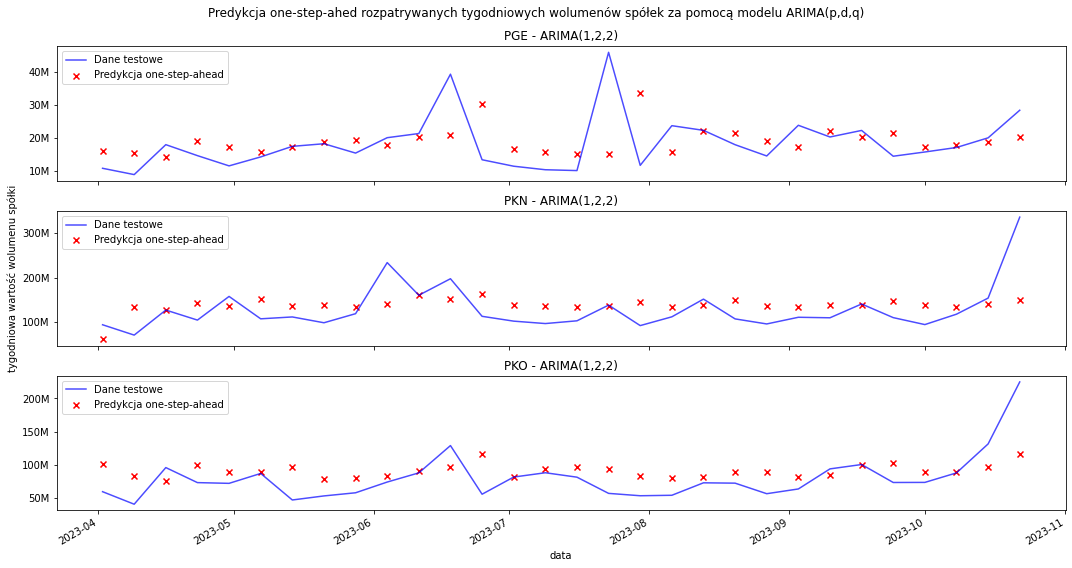

In [199]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(15,8))
ax1.scatter(np.array(df_test_PGE_week.index), forecast_values_ARIMA_PGE_week, color='red', marker='x', label='Predykcja one-step-ahead')
ax1.plot(df_test_PGE_week, label="Dane testowe", color="blue", alpha=0.7)
ax2.scatter(np.array(df_test_PGE_week.index), forecast_values_ARIMA_PKN_week, color='red', marker='x', label='Predykcja one-step-ahead')
ax2.plot(PKN_resample["daily_turnover"][273:], label="Dane testowe", color="blue", alpha=0.7)
ax3.scatter(np.array(df_test_PKO_week.index), forecast_values_ARIMA_PKO_week, color='red', marker='x', label='Predykcja one-step-ahead')
ax3.plot(df_test_PKO_week, label="Dane testowe", color="blue", alpha=0.7)
ax2.set_ylabel("tygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,2,2)")
ax2.title.set_text("PKN - ARIMA(1,2,2)")
ax3.title.set_text("PKO - ARIMA(1,2,2)")
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax3.set_xlabel("data")
fig.suptitle("Predykcja one-step-ahed rozpatrywanych tygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("38.pdf")

In [200]:
PGE_pred = forecast_values_ARIMA_PGE_week 
PGE_true = df_test_PGE_week

mape_PGE_ARIMA_week = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_ARIMA_week = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_ARIMA_week = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_ARIMA_week = np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_ARIMA_week = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [201]:
PKN_pred = forecast_values_ARIMA_PKN_week
PKN_true = PKN_resample["daily_turnover"][273:]

mape_PKN_ARIMA_week = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_ARIMA_week  = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_ARIMA_week  = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_ARIMA_week = np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_ARIMA_week = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [202]:
PKO_pred = forecast_values_ARIMA_PKO_week
PKO_true = df_test_PKO_week

mape_PKO_ARIMA_week = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARIMA_week = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARIMA_week = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARIMA_week = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARIMA_week = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

In [203]:
results_ARIMA_week = pd.DataFrame({'Method':['ARIMA_week - PGE', 'ARIMA_week - PKN', 'ARIMA_week - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_week , mape_PKN_ARIMA_week, mape_PKO_ARIMA_week],'MAE': [mae_PGE_ARIMA_week, mae_PKN_ARIMA_week, mae_PKO_ARIMA_week], 'MPE': [mpe_PGE_ARIMA_week, mpe_PKN_ARIMA_week, mpe_PKO_ARIMA_week], 'RMSE': [rmse_PGE_ARIMA_week, rmse_PKN_ARIMA_week, rmse_PKO_ARIMA_week], 'CORR': [corr_PGE_ARIMA_week,corr_PKN_ARIMA_week,corr_PKO_ARIMA_week]})
results_ARIMA_week

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARIMA_week - PGE  0.358656  6.115523e+06  0.187243  9.210099e+06 -0.061680
1  ARIMA_week - PKN  0.291712  3.657795e+07  0.167107  4.978597e+07  0.255972
2  ARIMA_week - PKO  0.350021  2.465253e+07  0.262787  3.269532e+07  0.461074

### ARIMA - dwutygodniowe 

In [204]:
forecast_values_ARIMA_PGE_week2 = []
forecast_values_ARIMA_PKN_week2 = []
forecast_values_ARIMA_PKO_week2 = []
forecast_steps_ARIMA_PGE_week2 = len(df_test_PGE_week2)
p1, d1, q1 = 1,1,1
p2, d2, q2 = 1,1,2
p3, d3, q3 = 2,1,2

for i in range(forecast_steps_ARIMA_PGE_week2):

    # Predict the next value
    forecast_ARIMA_PGE_week2 = result_PGE_ARIMA_week2.forecast(steps=1)
    forecast_values_ARIMA_PGE_week2.append(forecast_ARIMA_PGE_week2.values[0])

    forecast_ARIMA_PKN_week2 = result_PKN_ARIMA_week2.forecast(steps=1)
    forecast_ARIMA_PKN_daily_real_week2 = np.cumsum(forecast_ARIMA_PKN_week2) + 10000000
    forecast_values_ARIMA_PKN_week2.append(forecast_ARIMA_PKN_daily_real_week2.values[0])

    forecast_ARIMA_PKO_week2 = result_PKO_ARIMA_week2.forecast(steps=1)
    forecast_values_ARIMA_PKO_week2.append(forecast_ARIMA_PKO_week2.values[0])
    
    # Update the model with the actual observed value
    actual_value_ARIMA_PGE_week2 = df_test_PGE_week2.iloc[i]
    actual_value_ARIMA_PKN_week2= PKN_resample_w2["daily_turnover"][137:].iloc[i]
    actual_value_ARIMA_PKO_week2 = df_test_PKO_week2.iloc[i]

    # Update the last observation in the training set with the actual value

    df_train_PGE_week2.iloc[-1] = actual_value_ARIMA_PGE_week2
    PKN_resample_w2["daily_turnover"][:137].iloc[-1] = actual_value_ARIMA_PKN_week2
    df_train_PKO_week2.iloc[-1] = actual_value_ARIMA_PKO_week2
    
    # Update the model with the extended training set
    model_PGE_ARIMA_week2 = ARIMA(df_train_PGE_week2, order=(p1,d1,q1))
    model_PKN_ARIMA_week2 = ARIMA(PKN_resample_w2["daily_turnover"][:137], order=(p2,d2,q2))
    model_PKO_ARIMA_week2 = ARIMA(df_train_PKO_week2, order=(p3,d3,q3))
    result_PGE_ARIMA_week2 = model_PGE_ARIMA_week2.fit()
    result_PKN_ARIMA_week2 = model_PKN_ARIMA_week2.fit()
    result_PKO_ARIMA_week2 = model_PKO_ARIMA_week2.fit()


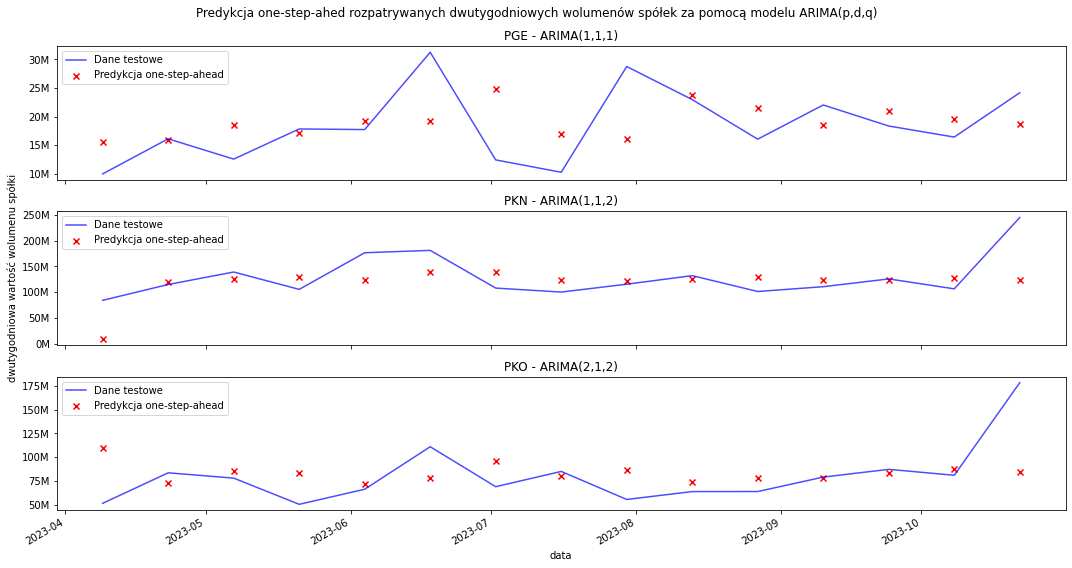

In [205]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, tight_layout=True, figsize=(15,8))
ax1.scatter(np.array(df_test_PGE_week2.index), forecast_values_ARIMA_PGE_week2, color='red', marker='x', label='Predykcja one-step-ahead')
ax1.plot(df_test_PGE_week2, label="Dane testowe", color="blue", alpha=0.7)
ax2.scatter(np.array(df_test_PGE_week2.index), forecast_values_ARIMA_PKN_week2, color='red', marker='x', label='Predykcja one-step-ahead')
ax2.plot(PKN_resample_w2["daily_turnover"][137:], label="Dane testowe", color="blue", alpha=0.7)
ax3.scatter(np.array(df_test_PKO_week2.index), forecast_values_ARIMA_PKO_week2, color='red', marker='x', label='Predykcja one-step-ahead')
ax3.plot(df_test_PKO_week2, label="Dane testowe", color="blue", alpha=0.7)
ax2.set_ylabel("dwutygodniowa wartość wolumenu spółki")
ax1.title.set_text("PGE - ARIMA(1,1,1)")
ax2.title.set_text("PKN - ARIMA(1,1,2)")
ax3.set_xlabel("data")
ax3.title.set_text("PKO - ARIMA(2,1,2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)
fig.suptitle("Predykcja one-step-ahed rozpatrywanych dwutygodniowych wolumenów spółek za pomocą modelu ARIMA(p,d,q)")   
plt.gcf().autofmt_xdate()
plt.savefig("39.pdf")

In [206]:
PGE_pred = forecast_values_ARIMA_PGE_week2 
PGE_true = df_test_PGE_week2

mape_PGE_ARIMA_week2 = np.mean(np.abs(PGE_pred - PGE_true)/np.abs(PGE_true)) # mean absolute percentage error
mae_PGE_ARIMA_week2 = np.mean(np.abs(PGE_pred - PGE_true)) # Mean absolute error
mpe_PGE_ARIMA_week2 = np.mean((PGE_pred - PGE_true)/PGE_true) # Mean percentage error
rmse_PGE_ARIMA_week2 = np.mean((PGE_pred - PGE_true)**2)**0.5 # RMSE
corr_PGE_ARIMA_week2 = np.corrcoef(PGE_pred, PGE_true)[0,1] # Correlation Coefficient

In [207]:
PKN_pred = forecast_values_ARIMA_PKN_week2
PKN_true = PKN_resample_w2["daily_turnover"][137:]

mape_PKN_ARIMA_week2 = np.mean(np.abs(PKN_pred - PKN_true)/np.abs(PKN_true)) # mean absolute percentage error
mae_PKN_ARIMA_week2  = np.mean(np.abs(PKN_pred - PKN_true)) # Mean absolute error
mpe_PKN_ARIMA_week2  = np.mean((PKN_pred - PKN_true)/PKN_true) # Mean percentage error
rmse_PKN_ARIMA_week2 = np.mean((PKN_pred - PKN_true)**2)**0.5 # RMSE
corr_PKN_ARIMA_week2 = np.corrcoef(PKN_pred, PKN_true)[0,1] # Correlation Coefficient

In [208]:
PKO_pred = forecast_values_ARIMA_PKO_week2
PKO_true = df_test_PKO_week2

mape_PKO_ARIMA_week2 = np.mean(np.abs(PKO_pred - PKO_true)/np.abs(PKO_true)) # mean absolute percentage error
mae_PKO_ARIMA_week2 = np.mean(np.abs(PKO_pred - PKO_true)) # Mean absolute error
mpe_PKO_ARIMA_week2 = np.mean((PKO_pred - PKO_true)/PKO_true) # Mean percentage error
rmse_PKO_ARIMA_week2 = np.mean((PKO_pred - PKO_true)**2)**0.5 # RMSE
corr_PKO_ARIMA_week2 = np.corrcoef(PKO_pred, PKO_true)[0,1] # Correlation Coefficient

In [209]:
results_ARIMA_week2 = pd.DataFrame({'Method':['ARIMA_week2 - PGE', 'ARIMA_week2 - PKN', 'ARIMA_week2 - PKO'], 
                        'MAPE': [mape_PGE_ARIMA_week2 , mape_PKN_ARIMA_week2, mape_PKO_ARIMA_week2],'MAE': [mae_PGE_ARIMA_week2, mae_PKN_ARIMA_week2, mae_PKO_ARIMA_week2], 'MPE': [mpe_PGE_ARIMA_week2, mpe_PKN_ARIMA_week2, mpe_PKO_ARIMA_week2], 'RMSE': [rmse_PGE_ARIMA_week2, rmse_PKN_ARIMA_week2, rmse_PKO_ARIMA_week2], 'CORR': [corr_PGE_ARIMA_week2,corr_PKN_ARIMA_week2,corr_PKO_ARIMA_week2]})
results_ARIMA_week2

Method      MAPE           MAE       MPE          RMSE      CORR
0  ARIMA_week2 - PGE  0.316298  5.257864e+06  0.148266  6.648191e+06  0.022083
1  ARIMA_week2 - PKN  0.234522  3.103937e+07 -0.043104  4.376936e+07  0.296267
2  ARIMA_week2 - PKO  0.294102  2.260417e+07  0.151852  3.313775e+07 -0.147642